# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


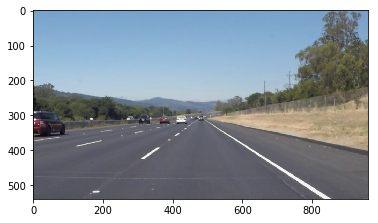

In [6]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [112]:
import math

threshold = 1000

def load_image(source_folder, file_name):
    s = "";
    sequence = (source_folder, file_name)
    fileFullPath = s.join(sequence)
    img = mpimg.imread(fileFullPath)
    return img

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 255)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    global avg_pos_slope
    global avg_neg_slope
    global nFrames
    
    if lines is None:
        return;
    
    # lines is an array of <1,4> tuples
    num_line_segments = lines.shape
    slopes = [None]* num_line_segments[0]
    line_index=0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            slopes[line_index] = (y2 - y1) / (x2 - x1);
        line_index+=1
    
    imshape = img.shape
    bottom_y = imshape[0]
    
    
    mean_negative_slope = compute_mean_slope(slopes, 1)
    print('mean_negative_slope = ', mean_negative_slope)
    if ~np.isinf(mean_negative_slope) and ~np.isnan(mean_negative_slope):
        if avg_neg_slope != 0:
            avg_neg_slope = (mean_negative_slope + avg_neg_slope*nFrames)/(nFrames+1)
        else:
            avg_neg_slope = mean_negative_slope
    else:
        plt.imshow(img)
    print('avg_neg_slope = ', avg_neg_slope)
    if avg_neg_slope != 0:
        rlp1 = compute_highest_point(lines,1,avg_neg_slope)#[485, 300];
        rlp2 = compute_other_point(avg_neg_slope, rlp1, bottom_y)
        cv2.line(img, (rlp1[0], rlp1[1]), (int(rlp2[0]), int(rlp2[1])), color, 10)
        print('end-points = ', rlp1[0], rlp1[1], int(rlp2[0]), int(rlp2[1]))
    
    mean_positive_slope = compute_mean_slope(slopes, 0)
    print('mean_positive_slope = ',mean_positive_slope)
    if ~np.isinf(mean_positive_slope) and ~np.isnan(mean_positive_slope):
        if avg_pos_slope != 0:
            avg_pos_slope = (mean_positive_slope + avg_pos_slope*nFrames)/(nFrames+1)
        else:
            avg_pos_slope = mean_positive_slope
    else:
        plt.imshow(img)
    print('avg_pos_slope = ', avg_pos_slope)
    if avg_pos_slope != 0:
        llp1 = compute_highest_point(lines,0,avg_pos_slope)#[485, 310];
        llp2 = compute_other_point(avg_pos_slope, llp1, bottom_y)
        cv2.line(img, (llp1[0], llp1[1]), (int(llp2[0]), int(llp2[1])), color, 10)
        print('end points = ', llp1[0], llp1[1], int(llp2[0]), int(llp2[1]))

def remove_noisy_slopes(slope_candidates):
    global threshold
    mean_slope = np.mean(slope_candidates)
    new_slope_candidates = []
    for slope in slope_candidates:
        if abs(slope - mean_slope) < threshold:
            new_slope_candidates.append(slope)
    return new_slope_candidates
    
def compute_mean_slope(slopes, is_slope_negative):
    num_line_segments = len(slopes)
    if is_slope_negative==1:
        slope_indices =  [i for i in range(num_line_segments) if slopes[i] < 0]
    else:
        slope_indices = [i for i in range(num_line_segments) if slopes[i] > 0]
    slope_candidates = [slopes[i] for i in slope_indices]
    slope_candidates = remove_noisy_slopes(slope_candidates)
    mean_slope = np.mean(slope_candidates)
    return mean_slope

def compute_highest_point(lines, is_slope_negative, mean_slope):
    global threshold
    highest_x = 0
    highest_y = 1000
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1);
            if abs(slope - mean_slope) < threshold:
                if is_slope_negative and slope < 0:
                    if highest_y > y1:
                        highest_x = x1
                        highest_y = y1
                    if highest_y > y2:
                        highest_x = x2
                        highest_y = y2
            
            if abs(slope - mean_slope) < threshold:
                if not is_slope_negative and slope > 0:
                    if highest_y > y1:
                        highest_x = x1
                        highest_y = y1
                    if highest_y > y2:
                        highest_x = x2
                        highest_y = y2
    print('highest = ', [highest_x, highest_y])
    return [highest_x, highest_y]

def compute_other_point(slope, point, bottom_y):
    bias = point[1] - slope*point[0]
    bottom_x = (bottom_y - bias)/ slope;
    print('bottom = ',[bottom_x, bottom_y])
    return [bottom_x, bottom_y]
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [8]:
import os, sys
src_folder = "test_images/"
file_list = os.listdir(src_folder)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [83]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
i = 0
for file in file_list:
    
    img = load_image(src_folder, file)
    
    # Compute GrayScale of the  image
    gray = grayscale(img)
    
    # Compute guassian blur of the image
    kernel_size=5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Compute canny edges pf the image
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Create masked edge image using region of interest
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]), (450, 320), (490, 320), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 60 #minimum number of pixels making up a line
    max_line_gap = 60   # maximum gap in pixels between connectable line segments
    
    # Run hough on edge detected image and draw lines on image
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create a color binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw lines on edge image
    lane_overlayed_image = weighted_img(line_image, img)
    
    
    # save image in src_folder 
    s = "";
    new_file_name = s.join((src_folder, "modified_", file))
    mpimg.imsave(new_file_name, lane_overlayed_image)
    

NameError: name 'file_list' is not defined

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [113]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # Compute GrayScale of the  image
    global nFrames
    
    nFrames = nFrames + 1
    
    gray = grayscale(image)
    
    # Compute guassian blur of the image
    kernel_size=5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Compute canny edges pf the image
    low_threshold = 40
    high_threshold = 120
    edges = canny(blur_gray, low_threshold, high_threshold)
    
   # Create masked edge image using region of interest
    imshape = image.shape
    print(imshape)
    #vertices = np.array([[(50, imshape[0]-20), (imshape[1]/2-10, imshape[0]/2+40), (imshape[1]/2 + 10, imshape[0]/2+40), (imshape[1]-50, imshape[0]-20)]], dtype=np.int32)
    vertices = np.array([[(0, imshape[0]), (480, 310), 490, 310), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)
    
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 #minimum number of pixels making up a line
    max_line_gap = 150   # maximum gap in pixels between connectable line segments
    # Run hough on edge detected image and draw lines on image
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    #plt.imshow(line_image)
    # Create a color binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw lines on edge image
    lane_overlayed_image = weighted_img(line_image, image)
    
    
    # save image in src_folder 
    #s = "";
    #new_file_name = s.join((src_folder, "modified_", file))
    #mpimg.imsave(new_file_name, lane_overlayed_image)
    plt.imshow(lane_overlayed_image)
    return lane_overlayed_image

SyntaxError: invalid syntax (<ipython-input-113-94aa8004afa9>, line 25)

Let's try the one with the solid white lane on the right first ...

(540, 960, 3)
mean_negative_slope =  -0.732816817826
avg_neg_slope =  -0.578605220297
highest =  [474, 311]
bottom =  [78.22064653597694, 540]
end-points =  474 311 78 540
mean_positive_slope =  0.612251115811
avg_pos_slope =  0.460061092721
highest =  [486, 310]
bottom =  [985.93360368698802, 540]
end points =  486 310 985 540
[MoviePy] >>>> Building video test_videos/modified_solidWhiteRight.mp4
[MoviePy] Writing video test_videos/modified_solidWhiteRight.mp4



  0%|          | 0/222 [00:00<?, ?it/s]

(540, 960, 3)
mean_negative_slope =  -0.732816817826
avg_neg_slope =  -0.578928515051
highest =  [474, 311]
bottom =  [78.441664131902911, 540]
end-points =  474 311 78 540
mean_positive_slope =  0.612251115811
avg_pos_slope =  0.460380149373
highest =  [486, 310]
bottom =  [985.58713535614731, 540]
end points =  486 310 985 540
(540, 960, 3)
mean_negative_slope =  -0.737307978175
avg_neg_slope =  -0.57925985284
highest =  [476, 310]
bottom =  [78.941583345486279, 540]
end-points =  476 310 78 540
mean_positive_slope =  0.629831105076
avg_pos_slope = 


  1%|          | 2/222 [00:00<00:11, 18.36it/s]

 0.46073464928
highest =  [490, 310]
bottom =  [989.20274144641496, 540]
end points =  490 310 989 540
(540, 960, 3)
mean_negative_slope =  -0.758970086665
avg_neg_slope =  -0.579635030781
highest =  [464, 313]
bottom =  [72.374256307034599, 540]
end-points =  464 313 72 540
mean_positive_slope =  0.611723876015
avg_pos_slope =  0.461049866872
highest =  [490, 310]
bottom =  [988.86143891591087, 540]
end points =  490 310 988 540
(540, 960, 3)
mean_negative_slope =  -0.72724466945
avg_neg_slope =  -0.579942550861
highest =  [470, 310]
bottom =  [73.408993428024772, 540]
end-points =  470 310 73 540
mean_positive_slope =  0.61638668463
avg_pos_slope =  0.461373485243
highest =  [491, 310]
bottom =  [989.51152560046251, 540]
end points =  491 310 989 540



  2%|▏         | 4/222 [00:00<00:11, 18.71it/s]

(540, 960, 3)
mean_negative_slope =  -0.716330986716
avg_neg_slope =  -0.580226102703
highest =  [475, 311]
bottom =  [80.326270339783804, 540]
end-points =  475 311 80 540
mean_positive_slope =  0.58543224861
avg_pos_slope =  0.46163140367
highest =  [482, 310]
bottom =  [980.23300185298535, 540]
end points =  482 310 980 540
(540, 960, 3)
mean_negative_slope =  -0.713154040803
avg_neg_slope =  -0.580501886807
highest =  [470, 310]
bottom =  [73.791124150994634, 540]
end-points =  470 310 73 540
mean_positive_slope =  0.588080932622
avg_pos_slope =  0.461893747091
highest =  [487, 313]
bottom =  [978.45501845331648, 540]
end points =  487 313 978 540



  3%|▎         | 6/222 [00:00<00:12, 17.86it/s]

(540, 960, 3)
mean_negative_slope =  -0.712708828586
avg_neg_slope =  -0.580775607183
highest =  [474, 310]
bottom =  [77.977857962248208, 540]
end-points =  474 310 77 540
mean_positive_slope =  0.614113093965
avg_pos_slope =  0.462208901018
highest =  [491, 310]
bottom =  [988.61049493719304, 540]
end points =  491 310 988 540



  4%|▎         | 8/222 [00:00<00:13, 16.01it/s]

(540, 960, 3)
mean_negative_slope =  -0.713311353659
avg_neg_slope =  -0.58104944137
highest =  [470, 310]
bottom =  [74.164493373197828, 540]
end-points =  470 310 74 540
mean_positive_slope =  0.614511888502
avg_pos_slope =  0.462523576612
highest =  [491, 310]
bottom =  [988.27194813443487, 540]
end points =  491 310 988 540
(540, 960, 3)
mean_negative_slope =  -0.716133756521
avg_neg_slope =  -0.581327965731
highest =  [472, 312]
bottom =  [79.794543802550066, 540]
end-points =  472 312 79 540
mean_positive_slope =  0.609231522183
avg_pos_slope =  0.462826067222
highest =  [491, 310]
bottom =  [987.94694462816358, 540]
end points =  491 310 987 540



  5%|▍         | 10/222 [00:00<00:12, 16.46it/s]

(540, 960, 3)
mean_negative_slope =  -0.710434389857
avg_neg_slope =  -0.58159361681
highest =  [478, 311]
bottom =  [84.254275526392334, 540]
end-points =  478 311 84 540
mean_positive_slope =  0.580991300465
avg_pos_slope =  0.463069205562
highest =  [478, 310]
bottom =  [974.68601849933066, 540]
end points =  478 310 974 540
(540, 960, 3)
mean_negative_slope =  -0.732518908232
avg_neg_slope =  -0.581903525006
highest =  [473, 310]
bottom =  [77.74547735772525, 540]
end-points =  473 310 77 540
mean_positive_slope =  0.611190272672
avg_pos_slope =  0.463373355597
highest =  [482, 310]
bottom =  [978.36000262432958, 540]
end points =  482 310 978 540



  6%|▌         | 13/222 [00:00<00:11, 17.66it/s]

(540, 960, 3)
mean_negative_slope =  -0.717417775524
avg_neg_slope =  -0.582181218142
highest =  [477, 310]
bottom =  [81.934008805687156, 540]
end-points =  477 310 81 540
mean_positive_slope =  0.624878501009
avg_pos_slope =  0.463704308763
highest =  [482, 310]
bottom =  [978.00574256754192, 540]
end points =  482 310 978 540
(540, 960, 3)
mean_negative_slope =  -0.731093791283
avg_neg_slope =  -0.582485742831
highest =  [477, 310]
bottom =  [82.140550081179867, 540]
end-points =  477 310 82 540
mean_positive_slope =  0.633863554367
avg_pos_slope =  0.464052282681
highest =  [482, 310]
bottom =  [977.6338080512586, 540]
end points =  482 310 977 540
(540, 960, 3)


mean_negative_slope =  -0.709176768865
avg_neg_slope =  -0.582744295946
highest =  [470, 310]
bottom =  [75.315742084291642, 540]
end-points =  470 310 75 540
mean_positive_slope =  0.641944565559
avg_pos_slope =  0.464415328156
highest =  [482, 310]
bottom =  [977.24635828272062, 540]
end points =  482 310 977 540
(540, 960, 3)
mean_negative_slope =  -0.719361959837
avg_neg_slope =  -0.58302253966
highest =  [474, 311]
bottom =  [81.219302133068737, 540]
end-points =  474 311 81 540
mean_positive_slope =  0.640303245563
avg_pos_slope =  0.464773552021
highest =  [487, 310]
bottom =  [981.86464752592474, 540]
end points =  487 310 981 540
(540, 960, 3)
mean_negative_slope =  -0.71598453632
avg_neg_slope =  -0.583292787621
highest =  [470, 311]
bottom =  [77.401283095030621, 540]
end-points =  470 311 77 540
mean_positive_slope =  0.643923099243
avg_pos_slope =  0.465137677116
highest =  [488, 310]
bottom =  [982.47725117825576, 540]



  7%|▋         | 16/222 [00:00<00:11, 18.57it/s]

end points =  488 310 982 540
(540, 960, 3)
mean_negative_slope =  -0.680619758451
avg_neg_slope =  -0.583490205412
highest =  [474, 310]
bottom =  [79.820289926492961, 540]
end-points =  474 310 79 540
mean_positive_slope =  0.642940435169
avg_pos_slope =  0.465498331798
highest =  [490, 310]
bottom =  [984.09414446567791, 540]
end points =  490 310 984 540
(540, 960, 3)
mean_negative_slope =  


  8%|▊         | 18/222 [00:00<00:10, 18.64it/s]

-0.673136427697
avg_neg_slope =  -0.583671675498
highest =  [473, 310]
bottom =  [78.94284482975533, 540]
end-points =  473 310 78 540
mean_positive_slope =  0.637815748129
avg_pos_slope =  0.465847152479
highest =  [491, 310]
bottom =  [984.7241727808655, 540]
end points =  491 310 984 540
(540, 960, 3)
mean_negative_slope =  -0.708425286465
avg_neg_slope =  -0.583923702994
highest =  [472, 310]
bottom =  [78.112923965001229, 540]
end-points =  472 310 78 540
mean_positive_slope =  0.63647061126
avg_pos_slope =  0.466191846335
highest =  [487, 310]
bottom =  [980.35912201836277, 540]
end points =  487 310 980 540
(540, 960, 3)
mean_negative_slope =  -0.682131712861
avg_neg_slope =  -0.584121703014
highest =  [476, 310]
bottom =  [82.246440060171409, 540]
end-points =  476 310 82 540
mean_positive_slope =  0.641591123268
avg_pos_slope =  0.46654547391
highest =  [484, 310]
bottom =  [976.98517049720431, 540]
end points =  484 310 976 540



  9%|▉         | 20/222 [00:01<00:10, 18.39it/s]

(540, 960, 3)
mean_negative_slope =  -0.709206052588
avg_neg_slope =  -0.584373381786
highest =  [476, 310]
bottom =  [82.416022411862386, 540]
end-points =  476 310 82 540
mean_positive_slope =  0.639948316926
avg_pos_slope =  0.46689437299
highest =  [484, 311]
bottom =  [974.4749623205912, 540]
end points =  484 311 974 540
(540, 960, 3)
mean_negative_slope =  -0.724816946995
avg_neg_slope =  -0.584655396977
highest =  [471, 310]
bottom =  [77.605872127198424, 540]
end-points =  471 310 77 540
mean_positive_slope =  0.639839779802
avg_pos_slope =  0.467241652923
highest =  [484, 311]
bottom =  [974.11041410199289, 540]
end points =  484 311 974 540



 10%|█         | 23/222 [00:01<00:10, 18.87it/s]

(540, 960, 3)
mean_negative_slope =  -0.711284022323
avg_neg_slope =  -0.584909161758
highest =  [471, 310]
bottom =  [77.776547474653114, 540]
end-points =  471 310 77 540
mean_positive_slope =  0.639646467667
avg_pos_slope =  0.467587153554
highest =  [483, 310]
bottom =  [974.88690974879944, 540]
end points =  483 310 974 540
(540, 960, 3)
mean_negative_slope =  -0.714192492804
avg_neg_slope =  -0.58516772842
highest =  [478, 310]
bottom =  [84.950300179456065, 540]
end-points =  478 310 84 540
mean_positive_slope =  0.637768278427
avg_pos_slope =  0.467927515804
highest =  [485, 310]
bottom =  [976.52911985705794, 540]
end points =  485 310 976 540
(540, 960, 3)



 11%|█▏        | 25/222 [00:01<00:10, 18.99it/s]

mean_negative_slope =  -0.715549772857
avg_neg_slope =  -0.585427972021
highest =  [470, 310]
bottom =  [77.12502478163789, 540]
end-points =  470 310 77 540
mean_positive_slope =  0.637990556166
avg_pos_slope =  0.46826696299
highest =  [487, 310]
bottom =  [978.17280991009989, 540]
end points =  487 310 978 540
(540, 960, 3)
mean_negative_slope =  -0.7115890583
avg_neg_slope =  -0.585679288926
highest =  [477, 310]
bottom =  [84.293608722825809, 540]
end-points =  477 310 84 540
mean_positive_slope =  0.638647404309
avg_pos_slope =  0.46860636626
highest =  [487, 310]
bottom =  [977.81706216614123, 540]
end points =  487 310 977 540



 12%|█▏        | 27/222 [00:01<00:10, 18.97it/s]

(540, 960, 3)
mean_negative_slope =  -0.715013052883
avg_neg_slope =  -0.585936413705
highest =  [471, 310]
bottom =  [78.465938931020219, 540]
end-points =  471 310 78 540
mean_positive_slope =  0.636666532093
avg_pos_slope =  0.468940481898
highest =  [485, 310]
bottom =  [975.46735967271502, 540]
end points =  485 310 975 540
(540, 960, 3)
mean_negative_slope =  -0.703428814391
avg_neg_slope =  -0.586169533548
highest =  [470, 310]
bottom =  [77.622049873855062, 540]
end-points =  470 310 77 540
mean_positive_slope =  0.6370636197
avg_pos_slope =  0.469274059552
highest =  [484, 310]
bottom =  [974.11871702338385, 540]
end points =  484 310 974 540
(540, 960, 3)


 13%|█▎        | 29/222 [00:01<00:10, 19.22it/s]


mean_negative_slope =  -0.735181715742
avg_neg_slope =  -0.586464607176
highest =  [470, 310]
bottom =  [77.819470799033454, 540]
end-points =  470 310 77 540
mean_positive_slope =  0.639538133877
avg_pos_slope =  0.469611216135
highest =  [485, 310]
bottom =  [974.76683711478881, 540]
end points =  485 310 974 540
(540, 960, 3)
mean_negative_slope =  -0.746600276184
avg_neg_slope =  -0.58678108083
highest =  [477, 310]
bottom =  [85.030988874894092, 540]
end-points =  477 310 85 540
mean_positive_slope =  0.636277346927
avg_pos_slope =  0.46994059584
highest =  [489, 310]
bottom =  [978.42356126712582, 540]
end points =  489 310 978 540



 14%|█▍        | 31/222 [00:01<00:10, 17.40it/s]

(540, 960, 3)
mean_negative_slope =  -0.712855240995
avg_neg_slope =  -0.587029747813
highest =  [474, 311]
bottom =  [83.900518920599197, 540]
end-points =  474 311 83 540
mean_positive_slope =  0.630928976617
avg_pos_slope =  0.470258127163
highest =  [489, 310]
bottom =  [978.0930889117202, 540]
end points =  489 310 978 540
(540, 960, 3)
mean_negative_slope =  -0.714820674059
avg_neg_slope =  -0.587281304754
highest =  [474, 310]
bottom =  [82.364853200636063, 540]
end-points =  474 310


 15%|█▍        | 33/222 [00:01<00:10, 17.74it/s]

 82 540
mean_positive_slope =  0.633799685591
avg_pos_slope =  0.470580059365
highest =  [488, 310]
bottom =  [976.75849161678138, 540]
end points =  488 310 976 540
(540, 960, 3)
mean_negative_slope =  -0.703405616866
avg_neg_slope =  -0.587509446821
highest =  [474, 310]
bottom =  [82.516933226567303, 540]
end-points =  474 310 82 540
mean_positive_slope =  0.633782632291
avg_pos_slope =  0.470900693103
highest =  [489, 310]
bottom =  [977.42569859966727, 540]
end points =  489 310 977 540
(540, 960, 3)
mean_negative_slope =  -0.718121882042
avg_neg_slope =  -0.587765549636
highest =  [474, 311]
bottom =  [84.388869946537014, 540]
end-points =  474 311 84 540
mean_positive_slope =  0.647959377301
avg_pos_slope =  0.471247866994
highest =  [488, 310]
bottom =  [976.06586959688434, 540]
end points =  488 310 976 540



 16%|█▌        | 35/222 [00:01<00:10, 18.29it/s]

(540, 960, 3)
mean_negative_slope =  -0.722283791935
avg_neg_slope =  -0.588028794728
highest =  [471, 310]
bottom =  [79.862691653822054, 540]
end-points =  471 310 79 540
mean_positive_slope =  0.635049471353
avg_pos_slope =  0.471568418079
highest =  [483, 310]
bottom =  [970.73410428355874, 540]
end points =  483 310 970 540
(540, 960, 3)
mean_negative_slope =  -0.720118444355
avg_neg_slope =  -0.588286782325
highest =  [479, 310]
bottom =  [88.034221216071344, 540]
end-points =  479 310 88 540
mean_positive_slope =  0.63634048729
avg_pos_slope =  0.471890238526
highest =  [483, 310]
bottom =  [970.40147861137064, 540]
end points =  483 310 970 540



 17%|█▋        | 37/222 [00:02<00:09, 18.63it/s]

(540, 960, 3)
mean_negative_slope =  -0.706599281955
avg_neg_slope =  -0.588517410979
highest =  [479, 310]
bottom =  [88.187433185226567, 540]
end-points =  479 310 88 540
mean_positive_slope =  0.634046767169
avg_pos_slope =  0.472206333124
highest =  [484, 310]
bottom =  [971.07521239358778, 540]
end points =  484 310 971 540
(540, 960, 3)
mean_negative_slope =  -0.716732387487
avg_neg_slope =  -0.588766856459
highest =  [480, 310]
bottom =  [89.353010488174476, 540]
end-points =  480 310 89 540
mean_positive_slope =  0.649338600506
avg_pos_slope =  0.47255094843
highest =  [482, 310]
bottom =  [968.72000503655227, 540]
end points =  482 310 968 540



 18%|█▊        | 39/222 [00:02<00:09, 18.78it/s]

(540, 960, 3)
mean_negative_slope =  -0.717319290033
avg_neg_slope =  -0.589016472835
highest =  [471, 310]
bottom =  [80.518560842476518, 540]
end-points =  471 310 80 540
mean_positive_slope =  0.647362409947
avg_pos_slope =  0.472890388161
highest =  [488, 310]
bottom =  [974.3706384353975, 540]
end points =  488 310 974 540
(540, 960, 3)
mean_negative_slope =  -0.71607797302
avg_neg_slope =  -0.589262716052
highest =  [470, 310]
bottom =  [79.681736626891379, 540]
end-points =  470 310 79 540
mean_positive_slope =  0.633474800175
avg_pos_slope =  0.473201598262
highest =  [488, 310]
bottom =  [974.05076746291934, 540]
end points =  488 310 974 540



 18%|█▊        | 41/222 [00:02<00:09, 18.96it/s]

(540, 960, 3)
mean_negative_slope =  -0.717562124855
avg_neg_slope =  -0.589510877384
highest =  [474, 310]
bottom =  [83.846045554814808, 540]
end-points =  474 310 83 540
mean_positive_slope =  0.638131991199
avg_pos_slope =  0.473520612562
highest =  [490, 310]
bottom =  [975.72331150624166, 540]
end points =  490 310 975 540
(540, 960, 3)
mean_negative_slope =  -0.706245161769
avg_neg_slope =  -0.589736233146
highest =  [474, 310]
bottom =  [83.995134989226827, 540]
end-points =  474 310 83 540
mean_positive_slope =  0.627083114298
avg_pos_slope =  0.473817065268
highest =  [490, 310]
bottom =  [975.4194094295857, 540]
end points =  490 310 975 540



 19%|█▉        | 43/222 [00:02<00:09, 18.13it/s]

(540, 960, 3)
mean_negative_slope =  -0.700373535424
avg_neg_slope =  -0.589949407139
highest =  [474, 310]
bottom =  [84.136060453835626, 540]
end-points =  474 310 84 540
mean_positive_slope =  0.638101247962
avg_pos_slope =  0.474133605119
highest =  [490, 310]
bottom =  [975.09533497905568, 540]
end points =  490 310 975 540
(540, 960, 3)
mean_negative_slope =  -0.696729128292
avg_neg_slope =  -0.590154752756
highest =  [474, 310]
bottom =  [84.271714451491349, 540]
end-points =  474 310 84 540
mean_positive_slope =  0.65897720044
avg_pos_slope =  0.474489073571
highest =  [490, 310]
bottom =  [974.7319207348429, 540]



 20%|██        | 45/222 [00:02<00:10, 17.40it/s]

end points =  490 310 974 540
(540, 960, 3)
mean_negative_slope =  -0.719019392327
avg_neg_slope =  -0.590402093715
highest =  [470, 312]
bottom =  [83.822507699283065, 540]
end-points =  470 312 83 540
mean_positive_slope =  0.65722086664
avg_pos_slope =  0.47483980638
highest =  [489, 310]
bottom =  [973.37388127501742, 540]
end points =  489 310 973 540
(540, 960, 3)
mean_negative_slope =  -0.721788683126
avg_neg_slope =  -0.590653792162



 21%|██        | 47/222 [00:02<00:10, 17.16it/s]

highest =  [473, 310]
bottom =  [83.600993251879231, 540]
end-points =  473 310 83 540
mean_positive_slope =  0.659405869974
avg_pos_slope =  0.475193381214
highest =  [495, 313]
bottom =  [972.70025630408043, 540]
end points =  495 313 972 540
(540, 960, 3)
mean_negative_slope =  -0.713893848232
avg_neg_slope =  -0.590889432805
highest =  [473, 310]
bottom =  [83.756281580078252, 540]
end-points =  473 310 83 540
mean_positive_slope =  0.644719263066
avg_pos_slope =  0.47551752248
highest =  [489, 310]
bottom =  [972.68354293368725, 540]
end points =  489 310 972 540
(540, 960, 3)
mean_negative_slope =  -0.731989000807
avg_neg_slope =  -0.59115870679
highest =  [462, 314]
bottom =  [79.699955351517019, 540]
end-points =  462 314 79 540
mean_positive_slope =  0.656709649762
avg_pos_slope = 


 22%|██▏       | 49/222 [00:02<00:10, 16.66it/s]

 0.475863308982
highest =  [489, 310]
bottom =  [972.33207385119033, 540]
end points =  489 310 972 540
(540, 960, 3)
mean_negative_slope =  -0.734233707086
avg_neg_slope =  -0.5914312306
highest =  [464, 313]
bottom =  [80.185300580365848, 540]
end-points =  464 313 80 540
mean_positive_slope =  0.660323762906
avg_pos_slope =  0.476214662228
highest =  [495, 314]
bottom =  [969.57589596844718, 540]
end points =  495 314 969 540
(540, 960, 3)
mean_negative_slope =  -0.717019844939
avg_neg_slope = 


 23%|██▎       | 51/222 [00:02<00:10, 16.28it/s]

 -0.591669992224
highest =  [471, 310]
bottom =  [82.2697905541838, 540]
end-points =  471 310 82 540
mean_positive_slope =  0.642642155325
avg_pos_slope =  0.476531064306
highest =  [488, 310]
bottom =  [970.65478838208753, 540]
end points =  488 310 970 540
(540, 960, 3)
mean_negative_slope =  -0.710234166237
avg_neg_slope =  -0.591894971681
highest =  [471, 310]
bottom =  [82.41754702408717, 540]
end-points =  471 310 82 540
mean_positive_slope =  0.64167141056
avg_pos_slope =  0.476844423597
highest =  [487, 310]
bottom =  [969.3376107981494, 540]
end points =  487 310 969 540



 24%|██▍       | 53/222 [00:02<00:10, 16.03it/s]

(540, 960, 3)
mean_negative_slope =  -0.706468124646
avg_neg_slope =  -0.592111966289
highest =  [471, 310]
bottom =  [82.559953024668729, 540]
end-points =  471 310 82 540
mean_positive_slope =  0.661765229363
avg_pos_slope =  0.477194652395
highest =  [494, 313]
bottom =  [969.6968647081859, 540]
end points =  494 313 969 540
(540, 960, 3)
mean_negative_slope =  -0.682512266157
avg_neg_slope =  -0.592282855325
highest =  [471, 310]
bottom =  [82.672028099010447, 540]
end-points =  471 310 82 540
mean_positive_slope =  0.613448150827
avg_pos_slope =  0.477452220445
highest =  [486, 310]
bottom =  [967.72359484570222, 540]
end points =  486 310 967 540


(540, 960, 3)
mean_negative_slope =  -0.681208422929
avg_neg_slope =  -0.592450639415
highest =  [471, 310]
bottom =  [82.782003936627973, 540]
end-points =  471 310 82 540
mean_positive_slope =  0.653952200601
avg_pos_slope =  0.477785239276
highest =  [491, 310]
bottom =  [972.38783096062639, 540]
end points =  491 310 972 540
(540, 960, 3)
mean_negative_slope =  -0.662627779401
avg_neg_slope =  -0.592582799754


 25%|██▍       | 55/222 [00:03<00:10, 15.27it/s]


highest =  [471, 310]
bottom =  [82.868585966971139, 540]
end-points =  471 310 82 540
mean_positive_slope =  0.637923995316
avg_pos_slope =  0.478086818854
highest =  [491, 310]
bottom =  [972.08416908729998, 540]
end points =  491 310 972 540
(540, 960, 3)
mean_negative_slope =  -0.686615218423
avg_neg_slope =  -0.59275955242
highest =  [475, 310]
bottom =  [86.984321364519289, 540]
end-points =  475 310 86 540
mean_positive_slope =  0.632695879225
avg_pos_slope =  0.478377437389
highest =  [485, 310]
bottom =  [965.79190618926407, 540]
end points =  485 310 965 540
(540, 960, 3)
mean_negative_slope =  -0.694972845225
avg_neg_slope = 


 26%|██▌       | 57/222 [00:03<00:10, 15.31it/s]

 -0.5929513222
highest =  [474, 310]
bottom =  [86.109811735465371, 540]
end-points =  474 310 86 540
mean_positive_slope =  0.638226078856
avg_pos_slope =  0.478677341031
highest =  [481, 310]
bottom =  [961.49067771737964, 540]
end points =  481 310 961 540
(540, 960, 3)
mean_negative_slope =  -0.677224833347
avg_neg_slope =  -0.593109137764
highest =  [473, 310]
bottom =  [85.213022266060918, 540]
end-points =  473 310 85 540
mean_positive_slope =  0.633390817215
avg_pos_slope =  0.478967066642
highest =  [490, 311]
bottom =  [968.11220425972112, 540]
end points =  490 311 968 540
(540, 960, 3)
mean_negative_slope =  -0.692521415808
avg_neg_slope =  -0.593294955106
highest =  [477, 310]
bottom =  [89.334475423377896, 540]
end-points =  477 310 89 540
mean_positive_slope =  0.649173149456
avg_pos_slope =  0.479285208853
highest =  [493, 313]
bottom =  [966.62195996685659, 540]



 27%|██▋       | 59/222 [00:03<00:10, 15.47it/s]

end points =  493 313 966 540
(540, 960, 3)
mean_negative_slope =  -0.686676703796
avg_neg_slope =  -0.593469174787
highest =  [473, 310]
bottom =  [85.448279082707316, 540]
end-points =  473 310 85 540
mean_positive_slope =  0.65734639371
avg_pos_slope =  0.479617412556
highest =  [489, 310]
bottom =  [968.54889455391572, 540]
end points =  489 310 968 540
(540, 960, 3)



 27%|██▋       | 61/222 [00:03<00:10, 15.44it/s]

mean_negative_slope =  -0.669877342796
avg_neg_slope =  -0.593611461878
highest =  [473, 310]
bottom =  [85.541174201190671, 540]
end-points =  473 310 85 540
mean_positive_slope =  0.656030469095
avg_pos_slope =  0.47994592849
highest =  [484, 311]
bottom =  [961.1370823386975, 540]
end points =  484 311 961 540
(540, 960, 3)
mean_negative_slope =  -0.682880138074
avg_neg_slope =  -0.593777388786
highest =  [473, 310]
bottom =  [85.649446839950983, 540]
end-points =  473 310 85 540
mean_positive_slope =  0.658892111754
avg_pos_slope =  0.480278542213
highest =  [492, 312]
bottom =  [966.72451912849226, 540]
end points =  492 312 966 540
(540, 960, 3)
mean_negative_slope = 


 28%|██▊       | 63/222 [00:03<00:10, 15.17it/s]

 -0.687340812467
avg_neg_slope =  -0.593950975842
highest =  [472, 310]
bottom =  [84.762653224408737, 540]
end-points =  472 310 84 540
mean_positive_slope =  0.65912880131
avg_pos_slope =  0.480610360876
highest =  [491, 312]
bottom =  [965.39676411564972, 540]
end points =  491 312 965 540
(540, 960, 3)
mean_negative_slope =  -0.671234134295
avg_neg_slope =  -0.594094092803
highest =  [472, 310]
bottom =  [84.855938501233368, 540]
end-points =  472 


 29%|██▉       | 65/222 [00:03<00:10, 15.37it/s]

310 84 540
mean_positive_slope =  0.629632812777
avg_pos_slope =  0.480886328379
highest =  [483, 311]
bottom =  [959.20401430772176, 540]
end points =  483 311 959 540
(540, 960, 3)
mean_negative_slope =  -0.673433915812
avg_neg_slope =  -0.594240746819
highest =  [472, 310]
bottom =  [84.951482658961368, 540]
end-points =  472 310 84 540
mean_positive_slope =  0.662615613812
avg_pos_slope =  0.481222242031
highest =  [486, 310]
bottom =  [963.9496455303663, 540]
end points =  486 310 963 540
(540, 960, 3)
mean_negative_slope =  -0.65327478412
avg_neg_slope =  -0.594349665707
highest =  [473, 310]
bottom =  [86.022412107645408, 540]
end-points =  473 310 86 540
mean_positive_slope =  0.658177493326
avg_pos_slope =  0.481548727734
highest =  [484, 311]
bottom =  [959.54896692885438, 540]
end points =  484 311 959 540
(540, 960, 3)
mean_negative_slope =  -0.688681883756
avg_neg_slope =  -0.594523389866
highest =  [473, 310]
bottom =  [86.135489838394889, 540]
end-points =  473 310 86 54


 30%|███       | 67/222 [00:03<00:09, 15.73it/s]

(540, 960, 3)
mean_negative_slope =  -0.682397989515


 31%|███       | 69/222 [00:04<00:09, 15.44it/s]


avg_neg_slope =  -0.594684924056
highest =  [475, 310]
bottom =  [88.240573796246736, 540]
end-points =  475 310 88 540
mean_positive_slope =  0.661376814906
avg_pos_slope =  0.48220232873
highest =  [485, 310]
bottom =  [961.97820250201789, 540]
end points =  485 310 961 540
(540, 960, 3)
mean_negative_slope =  -0.667655479527
avg_neg_slope =  -0.594818814984
highest =  [475, 310]
bottom =  [88.327631530430295, 540]
end-points =  475 310 88 540
mean_positive_slope =  0.656880647704
avg_pos_slope =  0.482522839407
highest =  [485, 310]
bottom =  [961.66137479124404, 540]
end points =  485 310 961 540
(540, 960, 3)
mean_negative_slope =  -0.673328568044
avg_neg_slope =  -0.59496260574
highest =  [478, 310]
bottom =  [91.421082634502213, 540]
end-points =  478 310 91 540
mean_positive_slope =  0.65460049768
avg_pos_slope =  0.482837999953
highest =  [483, 310]
bottom =  [959.35024588405793, 540]
end points =  483 310 959 540
(540, 960, 3)
mean_negative_slope =  -0.687758620131
avg_neg_s


 33%|███▎      | 73/222 [00:04<00:09, 15.76it/s]

(540, 960, 3)
mean_negative_slope =  -0.64869636679
avg_neg_slope =  -0.595229995841
highest =  [477, 310]
bottom =  [90.5947421888702, 540]
end-points =  477 310 90 540
mean_positive_slope =  0.660270511966
avg_pos_slope =  0.483478676242
highest =  [491, 310]
bottom =  [966.71901575405388, 540]
end points =  491 310 966 540
(540, 960, 3)
mean_negative_slope =  -0.69261978647
avg_neg_slope =  -0.595407390724
highest =  [472, 310]
bottom =  [85.709867255287307, 540]
end-points =  472 310 85 540
mean_positive_slope =  0.648298378307
avg_pos_slope =  0.483778894279
highest =  [482, 310]
bottom =  [957.42379942579521, 540]
end points =  482 310 957 540
(540, 960, 3)
mean_negative_slope =  -0.700269230325
avg_neg_slope =  -0.595598048614
highest =  [473, 310]
bottom =  [86.833523237503542, 540]
end-points =  473 310 86 540
mean_positive_slope =  0.65610006981
avg_pos_slope =  0.484092205507
highest =  [482, 310]
bottom =  [957.1160985108927, 540]
end points =  482 310 957 540
(540, 960, 3)


 35%|███▍      | 77/222 [00:04<00:08, 16.36it/s]

(540, 960, 3)
mean_negative_slope =  -0.681243139315
avg_neg_slope =  -0.595888842847
highest =  [474, 310]
bottom =  [88.021972787809005, 540]
end-points =  474 310 88 540
mean_positive_slope =  0.664647983753
avg_pos_slope =  0.484734713465
highest =  [484, 310]
bottom =  [958.4863398704565, 540]
end points =  484 310 958 540
(540, 960, 3)
mean_negative_slope =  -0.678967806967
avg_neg_slope =  -0.596039076056
highest =  [471, 311]
bottom =  [86.79700190890965, 540]
end-points =  471 311 86 540
mean_positive_slope =  0.676100617576
avg_pos_slope =  0.485080763924
highest =  [485, 310]
bottom =  [959.14784733857948, 540]
end points =  485 310 959 540
(540, 960, 3)
mean_negative_slope =  -0.652307332262
avg_neg_slope =  -0.596140643305
highest =  [466, 314]
bottom =  [86.894829872635398, 540]
end-points =  466 314 86 540
mean_positive_slope =  0.678188553566
avg_pos_slope =  0.485429333942
highest =  [485, 310]
bottom =  [958.80737816656369, 540]
end points =  485 310 958 540
(540, 960


 36%|███▋      | 81/222 [00:04<00:08, 16.19it/s]

(540, 960, 3)
mean_negative_slope =  -0.64867143244
avg_neg_slope =  -0.596396380086
highest =  [473, 310]
bottom =  [87.350442625393512, 540]
end-points =  473 310 87 540
mean_positive_slope =  0.66341024302
avg_pos_slope =  0.486070696509
highest =  [484, 310]
bottom =  [957.18219685292161, 540]
end points =  484 310 957 540
(540, 960, 3)
mean_negative_slope =  -0.655730120376
avg_neg_slope =  -0.596502903857
highest =  [469, 311]
bottom =  [85.095749879216044, 540]
end-points =  469 311 85 540
mean_positive_slope =  0.711848531639
avg_pos_slope =  0.486476042712
highest =  [484, 310]
bottom =  [956.78792747471766, 540]
end points =  484 310 956 540
(540, 960, 3)
mean_negative_slope =  -0.664227622938
avg_neg_slope =  -0.596624274321
highest =  [474, 310]
bottom =  [88.497750260445017, 540]
end-points =  474 310 88 540
mean_positive_slope =  0.684981215057
avg_pos_slope =  0.486831786749
highest =  [484, 310]
bottom =  [956.44244574922811, 540]
end points =  484 310 956 540
(540, 960


 38%|███▊      | 85/222 [00:05<00:08, 15.99it/s]

(540, 960, 3)
mean_negative_slope =  -0.662810388815
avg_neg_slope =  -0.596853800177
highest =  [474, 310]
bottom =  [88.645998849540732, 540]
end-points =  474 310 88 540
mean_positive_slope =  0.681100930543
avg_pos_slope =  0.487548343371
highest =  [485, 310]
bottom =  [956.74809047607312, 540]
end points =  485 310 956 540
(540, 960, 3)
mean_negative_slope =  -0.664258990652
avg_neg_slope =  -0.596973952032
highest =  [474, 310]
bottom =  [88.723558344035766, 540]
end-points =  474 310 88 540
mean_positive_slope =  0.680766548805
avg_pos_slope =  0.487892760849
highest =  [489, 310]
bottom =  [960.41506998295836, 540]
end points =  489 310 960 540
(540, 960, 3)
mean_negative_slope =  -0.660127409471
avg_neg_slope =  -0.597086324732
highest =  [475, 310]
bottom =  [89.796068050302267, 540]
end-points =  475 310 89 540
mean_positive_slope =  0.671958435594
avg_pos_slope =  0.488220279844
highest =  [482, 310]
bottom =  [953.09882464053896, 540]
end points =  482 310 953 540
(540, 9


 40%|████      | 89/222 [00:05<00:08, 16.59it/s]

(540, 960, 3)
mean_negative_slope =  -0.65923165253
avg_neg_slope =  -0.597310401303
highest =  [481, 310]
bottom =  [95.940574451235051, 540]
end-points =  481 310 95 540
mean_positive_slope =  0.686240056774
avg_pos_slope =  0.488918995596
highest =  [483, 310]
bottom =  [953.42557575356216, 540]
end points =  483 310 953 540
(540, 960, 3)
mean_negative_slope =  -0.648702999038
avg_neg_slope =  -0.597401361653
highest =  [476, 310]
bottom =  [90.999203611388836, 540]
end-points =  476 310 90 540
mean_positive_slope =  0.685506441795
avg_pos_slope =  0.489266937978
highest =  [484, 310]
bottom =  [954.09103241334537, 540]
end points =  484 310 954 540
(540, 960, 3)
mean_negative_slope =  -0.660764562043
avg_neg_slope =  -0.59751331077
highest =  [474, 310]
bottom =  [89.071336731333602, 540]
end-points =  474 310 89 540
mean_positive_slope =  0.685586202267
avg_pos_slope =  0.489613791802
highest =  [484, 310]
bottom =  [953.7580089673736, 540]
end points =  484 310 953 540
(540, 960,


 42%|████▏     | 93/222 [00:05<00:07, 16.41it/s]

(540, 960, 3)
mean_negative_slope =  -0.656052833436
avg_neg_slope =  -0.597729802635
highest =  [478, 310]
bottom =  [93.210754113125773, 540]
end-points =  478 310 93 540
mean_positive_slope =  0.690161859643
avg_pos_slope =  0.490353417953
highest =  [487, 310]
bottom =  [956.04944796815676, 540]
end points =  487 310 956 540
(540, 960, 3)
mean_negative_slope =  -0.662032566272
avg_neg_slope =  -0.597842812764
highest =  [478, 310]
bottom =  [93.283490761533031, 540]
end-points =  478 310 93 540
mean_positive_slope =  0.732779292963
avg_pos_slope =  0.490779473972
highest =  [491, 311]
bottom =  [957.60468121585325, 540]
end points =  491 311 957 540
(540, 960, 3)
mean_negative_slope =  -0.648225354535
avg_neg_slope =  -0.597931203188
highest =  [479, 310]
bottom =  [94.340362279947499, 540]
end-points =  479 310 94 540
mean_positive_slope =  0.702944106659
avg_pos_slope =  0.491151692626
highest =  [491, 311]
bottom =  [957.25106548180611, 540]
end points =  491 311 957 540
(540, 9


 44%|████▎     | 97/222 [00:05<00:08, 15.25it/s]

(540, 960, 3)
mean_negative_slope =  -0.66480694394
avg_neg_slope =  -0.598161730903
highest =  [470, 310]
bottom =  [85.488607650195249, 540]
end-points =  470 310 85 540
mean_positive_slope =  0.660688024271
avg_pos_slope =  0.491777993478
highest =  [489, 313]
bottom =  [950.5903985348408, 540]
end points =  489 313 950 540
(540, 960, 3)
mean_negative_slope =  -0.652627659837
avg_neg_slope =  -0.598256784881
highest =  [470, 310]
bottom =  [85.549700709302812, 540]
end-points =  470 310 85 540
mean_positive_slope =  0.694602350771
avg_pos_slope =  0.492131962688
highest =  [499, 315]
bottom =  [956.19444591906495, 540]
end points =  499 315 956 540
(540, 960, 3)
mean_negative_slope =  -0.666324488754
avg_neg_slope =  -0.59837536973
highest =  [475, 310]
bottom =  [90.625890310951775, 540]
end-points =  475 310 90 540
mean_positive_slope =  0.706009229119
avg_pos_slope =  0.492504571166
highest =  [498, 314]
bottom =  [956.87898962054794, 540]
end points =  498 314 956 540
(540, 960,


 45%|████▌     | 101/222 [00:06<00:07, 15.81it/s]

(540, 960, 3)
mean_negative_slope =  -0.649038040975
avg_neg_slope =  -0.598573342738
highest =  [475, 310]
bottom =  [90.753018756315825, 540]
end-points =  475 310 90 540
mean_positive_slope =  0.698870448357
avg_pos_slope =  0.493233039138
highest =  [506, 318]
bottom =  [956.09150317241858, 540]
end points =  506 318 956 540
(540, 960, 3)
mean_negative_slope =  -0.64992871588
avg_neg_slope =  -0.598662346851
highest =  [470, 310]
bottom =  [85.810145385172774, 540]
end-points =  470 310 85 540
mean_positive_slope =  0.707553514231
avg_pos_slope =  0.493604478436
highest =  [519, 324]
bottom =  [956.5973262726792, 540]
end points =  519 324 956 540
(540, 960, 3)
mean_negative_slope =  -0.673899515569
avg_neg_slope =  -0.598792514963
highest =  [478, 310]
bottom =  [93.893662240783868, 540]
end-points =  478 310 93 540
mean_positive_slope =  0.701399183149
avg_pos_slope =  0.493963984846
highest =  [490, 314]
bottom =  [947.52323435174287, 540]
end points =  490 314 947 540
(540, 960


 47%|████▋     | 105/222 [00:06<00:07, 16.12it/s]


highest =  [485, 310]
bottom =  [100.96057224449028, 540]
end-points =  485 310 100 540
mean_positive_slope =  0.684684980883
avg_pos_slope =  0.494293382076
highest =  [487, 310]
bottom =  [952.31070077074276, 540]
end points =  487 310 952 540
(540, 960, 3)
mean_negative_slope =  -0.645376450732
avg_neg_slope =  -0.598976977992
highest =  [485, 310]
bottom =  [101.01195296206686, 540]
end-points =  485 310 101 540
mean_positive_slope =  0.687117182181
avg_pos_slope =  0.494625836904
highest =  [487, 310]
bottom =  [951.99794964182604, 540]
end points =  487 310 951 540
(540, 960, 3)
mean_negative_slope =  -0.668002275911
avg_neg_slope =  -0.599095782292
highest =  [477, 310]
bottom =  [93.088100102863137, 540]
end-points =  477 310 93 540
mean_positive_slope =  0.692123922185
avg_pos_slope =  0.494965764761
highest =  [489, 311]
bottom =  [951.65826104259224, 540]
end points =  489 311 951 540
(540, 960, 3)
mean_negative_slope =  -0.671178042445
avg_neg_slope =  -0.599219634972
high


 49%|████▉     | 109/222 [00:06<00:07, 16.04it/s]

(540, 960, 3)
mean_negative_slope =  -0.680725458254
avg_neg_slope =  -0.59950952054
highest =  [477, 310]
bottom =  [93.353048417546916, 540]
end-points =  477 310 93 540
mean_positive_slope =  0.69939884179
avg_pos_slope =  0.495978208147
highest =  [511, 320]
bottom =  [954.56787533471936, 540]
end points =  511 320 954 540
(540, 960, 3)
mean_negative_slope =  -0.657241550036
avg_neg_slope =  -0.59960820777
highest =  [479, 310]
bottom =  [95.416191407291507, 540]
end-points =  479 310 95 540
mean_positive_slope =  0.687602134792
avg_pos_slope =  0.496305770415
highest =  [493, 311]
bottom =  [954.40910231350063, 540]
end points =  493 311 954 540
(540, 960, 3)
mean_negative_slope =  -0.68599687876
avg_neg_slope =  -0.599755628711
highest =  [477, 310]
bottom =  [93.510476951307069, 540]
end-points =  477 310 93 540
mean_positive_slope =  0.6866217644
avg_pos_slope =  0.496630541735
highest =  [493, 311]
bottom =  [954.10736403727321, 540]
end points =  493 311 954 540
(540, 960, 3)


 51%|█████     | 113/222 [00:06<00:06, 16.05it/s]

(540, 960, 3)
mean_negative_slope =  -0.688399873967
avg_neg_slope =  -0.600058445831
highest =  [480, 310]
bottom =  [96.704003421540349, 540]
end-points =  480 310 96 540
mean_positive_slope =  0.686619702862
avg_pos_slope =  0.497283793399
highest =  [493, 311]
bottom =  [953.50163516254293, 540]
end points =  493 311 953 540
(540, 960, 3)
mean_negative_slope =  -0.6839885377
avg_neg_slope =  -0.600200941742
highest =  [479, 310]
bottom =  [95.795003132813136, 540]
end-points =  479 310 95 540
mean_positive_slope =  0.685531422401
avg_pos_slope =  0.497603398881
highest =  [493, 311]
bottom =  [953.20585975690869, 540]
end points =  493 311 953 540
(540, 960, 3)
mean_negative_slope =  -0.690342764173
avg_neg_slope =  -0.600353724492
highest =  [484, 310]
bottom =  [100.89252416216941, 540]
end-points =  484 310 100 540
mean_positive_slope =  0.657904865274
avg_pos_slope =  0.497875096282
highest =  [483, 311]
bottom =  [942.95471898525511, 540]
end points =  483 311 942 540
(540, 96


 53%|█████▎    | 117/222 [00:06<00:06, 16.35it/s]

(540, 960, 3)
mean_negative_slope =  -0.671370080555
avg_neg_slope =  -0.600543514032
highest =  [478, 310]
bottom =  [95.013597473175125, 540]
end-points =  478 310 95 540
mean_positive_slope =  0.654215420129
avg_pos_slope =  0.498437604296
highest =  [488, 310]
bottom =  [949.44190971454032, 540]
end points =  488 310 949 540
(540, 960, 3)
mean_negative_slope =  -0.702393901384
avg_neg_slope =  -0.60071526848
highest =  [476, 310]
bottom =  [93.123099630698334, 540]
end-points =  476 310 93 540
mean_positive_slope =  0.662136430105
avg_pos_slope =  0.498713656279
highest =  [490, 311]
bottom =  [949.18133004134268, 540]
end points =  490 311 949 540
(540, 960, 3)
mean_negative_slope =  -0.668562856956
avg_neg_slope =  -0.600829490009
highest =  [480, 310]
bottom =  [97.195886978636196, 540]
end-points =  480 310 97 540
mean_positive_slope =  0.667669192924
avg_pos_slope =  0.498998093209
highest =  [487, 310]
bottom =  [947.92360497951813, 540]
end points =  487 310 947 540
(540, 96


 55%|█████▍    | 121/222 [00:07<00:06, 16.50it/s]

(540, 960, 3)
mean_negative_slope =  -0.663183169758
avg_neg_slope =  -0.601044370408
highest =  [476, 310]
bottom =  [93.332743930768018, 540]
end-points =  476 310 93 540
mean_positive_slope =  0.661162834242
avg_pos_slope =  0.499541807631
highest =  [491, 310]
bottom =  [951.42192362387755, 540]
end points =  491 310 951 540
(540, 960, 3)
mean_negative_slope =  -0.696477298186
avg_neg_slope =  -0.601204224559
highest =  [476, 310]
bottom =  [93.434491301459559, 540]
end-points =  476 310 93 540
mean_positive_slope =  0.626602661482
avg_pos_slope =  0.499754639882
highest =  [490, 310]
bottom =  [950.22584213388654, 540]
end points =  490 310 950 540
(540, 960, 3)
mean_negative_slope =  -0.683349207112
avg_neg_slope =  -0.60134159075
highest =  [470, 310]
bottom =  [87.521881842477441, 540]
end-points =  470 310 87 540
mean_positive_slope =  0.634976797309
avg_pos_slope =  0.499980763891
highest =  [490, 310]
bottom =  [950.01769790111007, 540]
end points =  490 310 950 540
(540, 96


 56%|█████▋    | 125/222 [00:07<00:05, 16.75it/s]

(540, 960, 3)
mean_negative_slope =  -0.667859790898
avg_neg_slope =  -0.601602517238
highest =  [485, 311]
bottom =  [104.34999698555102, 540]
end-points =  485 311 104 540
mean_positive_slope =  0.614977453244
avg_pos_slope =  0.50041490971
highest =  [491, 310]
bottom =  [950.6185995604842, 540]
end points =  491 310 950 540
(540, 960, 3)
mean_negative_slope =  -0.693475340288
avg_neg_slope =  -0.601755383832
highest =  [476, 310]
bottom =  [93.784890372793456, 540]
end-points =  476 310 93 540
mean_positive_slope =  0.618761273026
avg_pos_slope =  0.500611825456
highest =  [485, 310]
bottom =  [944.43780850685084, 540]
end points =  485 310 944 540
(540, 960, 3)
mean_negative_slope =  -0.666499379427
avg_neg_slope =  -0.601862931997
highest =  [480, 310]
bottom =  [97.853189202408842, 540]
end-points =  480 310 97 540
mean_positive_slope =  0.637490885928
avg_pos_slope =  0.50083919931
highest =  [488, 311]
bottom =  [945.23258146593082, 540]
end points =  488 311 945 540
(540, 960


 58%|█████▊    | 129/222 [00:07<00:06, 15.47it/s]

(540, 960, 3)
mean_negative_slope =  -0.682961865575
avg_neg_slope =  -0.602139066992
highest =  [476, 310]
bottom =  [94.028437933847627, 540]
end-points =  476 310 94 540
mean_positive_slope =  0.636922693473
avg_pos_slope =  0.501294090676
highest =  [491, 310]
bottom =  [949.81251001780117, 540]
end points =  491 310 949 540
(540, 960, 3)
mean_negative_slope =  -0.682633607946
avg_neg_slope =  -0.60227211582
highest =  [481, 310]
bottom =  [99.112819839195737, 540]
end-points =  481 310 99 540
mean_positive_slope =  0.636916210645
avg_pos_slope =  0.501518259469
highest =  [486, 310]
bottom =  [944.6074298541248, 540]
end points =  486 310 944 540
(540, 960, 3)
mean_negative_slope =  -0.718010163037
avg_neg_slope =  -0.602463102697
highest =  [475, 310]
bottom =  [93.23388192486442, 540]
end-points =  475 310 93 540
mean_positive_slope =  0.625623354421
avg_pos_slope =  0.501723053355
highest =  [485, 310]
bottom =  [943.42023495226135, 540]
end points =  485 310 943 540
(540, 960,


 60%|█████▉    | 133/222 [00:07<00:05, 16.02it/s]

(540, 960, 3)
mean_negative_slope =  -0.716160984986
avg_neg_slope =  -0.602837082469
highest =  [480, 310]
bottom =  [98.470716735074561, 540]
end-points =  480 310 98 540
mean_positive_slope =  0.638750088814
avg_pos_slope =  0.502167075138
highest =  [485, 310]
bottom =  [943.01489461810058, 540]
end points =  485 310 943 540
(540, 960, 3)
mean_negative_slope =  -0.714094370371
avg_neg_slope =  -0.603019770955
highest =  [475, 310]
bottom =  [93.586303338427768, 540]
end-points =  475 310 93 540
mean_positive_slope =  0.637340351009
avg_pos_slope =  0.50238903454
highest =  [485, 310]
bottom =  [942.81254005785502, 540]
end points =  485 310 942 540
(540, 960, 3)
mean_negative_slope =  -0.717104554159
avg_neg_slope =  -0.60320679519
highest =  [481, 310]
bottom =  [99.704560634788152, 540]
end-points =  481 310 99 540
mean_positive_slope =  0.636493933494
avg_pos_slope =  0.502608878637
highest =  [491, 310]
bottom =  [948.61229014469143, 540]
end points =  491 310 948 540
(540, 960


 62%|██████▏   | 137/222 [00:08<00:05, 15.71it/s]

(540, 960, 3)
mean_negative_slope =  -0.696065728698
avg_neg_slope =  -0.603532074826
highest =  [476, 311]
bottom =  [96.566976384666646, 540]
end-points =  476 311 96 540
mean_positive_slope =  0.636885080009
avg_pos_slope =  0.503044236313
highest =  [491, 310]
bottom =  [948.21625136975581, 540]
end points =  491 310 948 540
(540, 960, 3)
mean_negative_slope =  -0.713763832892
avg_neg_slope =  -0.603711898248
highest =  [477, 311]
bottom =  [97.67999543424861, 540]
end-points =  477 311 97 540
mean_positive_slope =  0.63586918862
avg_pos_slope =  0.503260916496
highest =  [491, 310]
bottom =  [948.01939582650652, 540]
end points =  491 310 948 540
(540, 960, 3)
mean_negative_slope =  -0.717075653081
avg_neg_slope =  -0.603896529771
highest =  [473, 310]
bottom =  [92.140053533300801, 540]
end-points =  473 310 92 540
mean_positive_slope =  0.635130637832
avg_pos_slope =  0.503475688029
highest =  [491, 310]
bottom =  [947.82444151462778, 540]
end points =  491 310 947 540
(540, 960


 64%|██████▎   | 141/222 [00:08<00:05, 16.19it/s]

 310 92 540
mean_positive_slope =  0.635113696391
avg_pos_slope =  0.503689733571
highest =  [490, 310]
bottom =  [946.63031161939819, 540]
end points =  490 310 946 540
(540, 960, 3)
mean_negative_slope =  -0.706970935461
avg_neg_slope =  -0.6042182456
highest =  [477, 310]
bottom =  [96.342842300966709, 540]
end-points =  477 310 96 540
mean_positive_slope =  0.639196434074
avg_pos_slope =  0.503909711981
highest =  [489, 311]
bottom =  [943.4464902250063, 540]
end points =  489 311 943 540
(540, 960, 3)
mean_negative_slope =  -0.701157728425
avg_neg_slope =  -0.604375359835
highest =  [485, 310]
bottom =  [104.44179844974296, 540]
end-points =  485 310 104 540
mean_positive_slope =  0.636055803646
avg_pos_slope =  0.50412388717
highest =  [489, 312]
bottom =  [941.26978090632463, 540]
end points =  489 312 941 540
(540, 960, 3)
mean_negative_slope =  -0.703636104241
avg_neg_slope =  -0.604535975926
highest =  [480, 310]
bottom =  [99.542907024367096, 540]
end-points =  480 310 99 54


 66%|██████▌   | 147/222 [00:08<00:04, 16.49it/s]

(540, 960, 3)
mean_negative_slope =  -0.711114825228
avg_neg_slope =  -0.604907666803
highest =  [480, 310]
bottom =  [99.776682257158612, 540]
end-points =  480 310 99 540
mean_positive_slope =  0.633839666676
avg_pos_slope =  0.50478339937
highest =  [496, 313]
bottom =  [945.69783135393857, 540]
end points =  496 313 945 540
(540, 960, 3)
mean_negative_slope =  -0.742572640443
avg_neg_slope =  -0.60512934953
highest =  [477, 310]
bottom =  [96.915973042042424, 540]
end-points =  477 310 96 540
mean_positive_slope =  0.636144420441
avg_pos_slope =  0.504994930805
highest =  [491, 311]
bottom =  [944.4698984703914, 540]
end points =  491 311 944 540
(540, 960, 3)
mean_negative_slope =  -0.707579521797
avg_neg_slope =  -0.605294060418
highest =  [477, 310]
bottom =  [97.019400419983782, 540]
end-points =  477 310 97 540
mean_positive_slope =  0.631999261789
avg_pos_slope =  0.505199117832
highest =  [495, 313]
bottom =  [944.32778381365563, 540]
end points =  495 313 944 540
(540, 960,


 67%|██████▋   | 149/222 [00:08<00:04, 16.31it/s]

(540, 960, 3)
mean_negative_slope =  -0.674951861997
avg_neg_slope =  -0.605549397459
highest =  [486, 310]
bottom =  [106.17962371824329, 540]
end-points =  486 310 106 540
mean_positive_slope =  0.634763074349
avg_pos_slope =  0.50561510858
highest =  [511, 320]
bottom =  [946.11358000743496, 540]
end points =  511 320 946 540
(540, 960, 3)
mean_negative_slope =  -0.706718400764
avg_neg_slope =  -0.605711267864
highest =  [477, 310]
bottom =  [97.281126994651387, 540]
end-points =  477 310 97 540
mean_positive_slope =  0.633805369818
avg_pos_slope =  0.505820212998
highest =  [506, 319]
bottom =  [942.91413336416883, 540]
end points =  506 319 942 540
(540, 960, 3)
mean_negative_slope =  -0.724154117098
avg_neg_slope =  -0.605900473694
highest =  [480, 310]
bottom =  [100.3997026146465, 540]
end-points =  480 310 100 540
mean_positive_slope =  0.58618345145
avg_pos_slope =  0.505948588778
highest =  [488, 310]
bottom =  [942.59164251350148, 540]
end points =  488 310 942 540
(540, 96


 70%|██████▉   | 155/222 [00:09<00:03, 17.62it/s]

(540, 960, 3)
mean_negative_slope =  -0.723242606346
avg_neg_slope =  -0.606317174935
highest =  [481, 310]
bottom =  [101.6605890313168, 540]
end-points =  481 310 101 540
mean_positive_slope =  0.634707746389
avg_pos_slope =  0.506307240976
highest =  [497, 313]
bottom =  [945.34436806084545, 540]
end points =  497 313 945 540
(540, 960, 3)
mean_negative_slope =  -0.711371625095
avg_neg_slope =  -0.606484193139
highest =  [477, 310]
bottom =  [97.765054387131997, 540]
end-points =  477 310 97 540
mean_positive_slope =  0.634705519148
avg_pos_slope =  0.506511371784
highest =  [499, 314]
bottom =  [945.18938999149339, 540]
end points =  499 314 945 540
(540, 960, 3)
mean_negative_slope =  -0.728334602214
avg_neg_slope =  -0.606677606486
highest =  [478, 310]
bottom =  [98.885957317495738, 540]
end-points =  478 310 98 540
mean_positive_slope =  0.634413956572
avg_pos_slope =  0.50671439176
highest =  [501, 315]
bottom =  [945.03712161917611, 540]
end points =  501 315 945 540
(540, 96


 71%|███████   | 157/222 [00:09<00:03, 17.02it/s]

(540, 960, 3)
mean_negative_slope =  -0.71172392781
avg_neg_slope =  -0.607048890902
highest =  [486, 310]
bottom =  [107.11783178063175, 540]
end-points =  486 310 107 540
mean_positive_slope =  0.629365233641
avg_pos_slope =  0.50710728604
highest =  [517, 323]
bottom =  [944.91733815229179, 540]
end points =  517 323 944 540
(540, 960, 3)
mean_negative_slope =  -0.740969778908
avg_neg_slope =  -0.607260456286
highest =  [477, 310]
bottom =  [98.249831733108834, 540]
end-points =  477 310 98 540
mean_positive_slope =  0.618240653521
avg_pos_slope =  0.507282852182
highest =  [519, 324]
bottom =  [944.7979528995545, 540]
end points =  519 324 944 540
(540, 960, 3)
mean_negative_slope =  -0.765864595659
avg_neg_slope =  -0.607510620543
highest =  [480, 310]
bottom =  [101.40579568088032, 540]
end-points =  480 310 101 540
mean_positive_slope =  0.609615861461
avg_pos_slope =  0.507444260714
highest =  [482, 310]
bottom =  [935.25175158457171, 540]
end points =  482 310 935 540
(540, 96


 73%|███████▎  | 161/222 [00:09<00:03, 16.29it/s]

(540, 960, 3)
mean_negative_slope =  -0.738210300255
avg_neg_slope =  -0.607936676246
highest =  [480, 310]
bottom =  [101.67112301830359, 540]
end-points =  480 310 101 540
mean_positive_slope =  0.579340227737
avg_pos_slope =  0.507721944728
highest =  [481, 310]
bottom =  [934.00385848675865, 540]
end points =  481 310 934 540
(540, 960, 3)
mean_negative_slope =  -0.743357937248
avg_neg_slope =  -0.608149268492
highest =  [478, 311]
bottom =  [101.44770952730589, 540]
end-points =  478 311 101 540
mean_positive_slope =  0.58907503263
avg_pos_slope =  0.507849657581
highest =  [498, 314]
bottom =  [943.01359137720283, 540]
end points =  498 314 943 540
(540, 960, 3)
mean_negative_slope =  -0.747642205569
avg_neg_slope =  -0.608367909459
highest =  [481, 310]
bottom =  [102.9392962320951, 540]
end-points =  481 310 102 540
mean_positive_slope =  0.591468893037
avg_pos_slope =  0.507980722214
highest =  [486, 310]
bottom =  [938.77308752513966, 540]
end points =  486 310 938 540
(540, 


 74%|███████▍  | 165/222 [00:09<00:03, 16.00it/s]

(540, 960, 3)
mean_negative_slope =  -0.767316876186
avg_neg_slope =  -0.608790199877
highest =  [480, 310]
bottom =  [102.20153996188408, 540]
end-points =  480 310 102 540
mean_positive_slope =  0.587096646184
avg_pos_slope =  0.508194633528
highest =  [489, 311]
bottom =  [939.61475444952578, 540]
end points =  489 311 939 540
(540, 960, 3)
mean_negative_slope =  -0.754464315708
avg_neg_slope =  -0.609017460589
highest =  [478, 310]
bottom =  [100.3425190835775, 540]
end-points =  478 310 100 540
mean_positive_slope =  0.589852434151
avg_pos_slope =  0.508322024793
highest =  [493, 311]
bottom =  [943.50182528134815, 540]
end points =  493 311 943 540
(540, 960, 3)
mean_negative_slope =  -0.789892210851
avg_neg_slope =  -0.60929919696
highest =  [478, 310]
bottom =  [100.51714568530761, 540]
end-points =  478 310 100 540
mean_positive_slope =  0.589589242143
avg_pos_slope =  0.508448609244
highest =  [489, 310]
bottom =  [941.35643449211864, 540]
end points =  489 310 941 540
(540, 


 76%|███████▌  | 169/222 [00:10<00:03, 16.17it/s]

(540, 960, 3)
mean_negative_slope =  -0.762505301452
avg_neg_slope =  -0.609774531963
highest =  [478, 310]
bottom =  [100.81140332401237, 540]
end-points =  478 310 100 540
mean_positive_slope =  0.585916051792
avg_pos_slope =  0.508690766933
highest =  [483, 310]
bottom =  [935.14109425763002, 540]
end points =  483 310 935 540
(540, 960, 3)
mean_negative_slope =  -0.7939360751
avg_neg_slope =  -0.610060053736
highest =  [479, 310]
bottom =  [101.98793603740125, 540]
end-points =  479 310 101 540
mean_positive_slope =  0.58920814829
avg_pos_slope =  0.508815600083
highest =  [483, 310]
bottom =  [935.03016566826386, 540]
end points =  483 310 935 540
(540, 960, 3)
mean_negative_slope =  -0.76561948782
avg_neg_slope =  -0.610300857813
highest =  [483, 310]
bottom =  [106.1366922469296, 540]
end-points =  483 310 106 540
mean_positive_slope =  0.586118771112
avg_pos_slope =  0.508935264434
highest =  [484, 310]
bottom =  [935.9238812341024, 540]
end points =  484 310 935 540
(540, 960,


 78%|███████▊  | 173/222 [00:10<00:02, 16.55it/s]

(540, 960, 3)
mean_negative_slope =  -0.782576979596
avg_neg_slope =  -0.610807444678
highest =  [477, 310]
bottom =  [100.44925229043182, 540]
end-points =  477 310 100 540
mean_positive_slope =  0.58897814901
avg_pos_slope =  0.509183847692
highest =  [483, 310]
bottom =  [934.70325225881186, 540]
end points =  483 310 934 540
(540, 960, 3)
mean_negative_slope =  -0.760148418764
avg_neg_slope =  -0.611037554037
highest =  [477, 310]
bottom =  [100.59105675182548, 540]
end-points =  477 310 100 540
mean_positive_slope =  0.589310726721
avg_pos_slope =  0.509307309755
highest =  [484, 310]
bottom =  [935.59375409450411, 540]
end points =  484 310 935 540
(540, 960, 3)
mean_negative_slope =  -0.788784669126
avg_neg_slope =  -0.611311011137
highest =  [477, 310]
bottom =  [100.75943536142177, 540]
end-points =  477 310 100 540
mean_positive_slope =  0.591746274341
avg_pos_slope =  0.509434138931
highest =  [491, 311]
bottom =  [940.51836262964025, 540]
end points =  491 311 940 540
(540,


 80%|███████▉  | 177/222 [00:10<00:02, 15.65it/s]

(540, 960, 3)
mean_negative_slope =  -0.797460150034
avg_neg_slope =  -0.611857768514
highest =  [477, 310]
bottom =  [101.09564471406885, 540]
end-points =  477 310 101 540
mean_positive_slope =  0.591956740875
avg_pos_slope =  0.509680484856
highest =  [485, 310]
bottom =  [936.26310862147852, 540]
end points =  485 310 936 540
(540, 960, 3)
mean_negative_slope =  -0.758845576946
avg_neg_slope =  -0.612082864699
highest =  [480, 310]
bottom =  [104.2338852056178, 540]
end-points =  480 310 104 540
mean_positive_slope =  0.599097401193
avg_pos_slope =  0.509817417347
highest =  [485, 310]
bottom =  [936.14190330510598, 540]
end points =  485 310 936 540
(540, 960, 3)
mean_negative_slope =  -0.778434801007
avg_neg_slope =  -0.612337225457
highest =  [472, 310]
bottom =  [96.389975918622554, 540]
end-points =  472 310 96 540
mean_positive_slope =  0.586266038737
avg_pos_slope =  0.509934311263
highest =  [485, 310]
bottom =  [936.03848656532443, 540]
end points =  485 310 936 540
(540, 


 82%|████████▏ | 181/222 [00:10<00:02, 16.54it/s]

 -0.612593412217
highest =  [480, 310]
bottom =  [104.54705615012544, 540]
end-points =  480 310 104 540
mean_positive_slope =  0.589918030393
avg_pos_slope =  0.510056423812
highest =  [485, 310]
bottom =  [935.9305034944324, 540]
end points =  485 310 935 540
(540, 960, 3)
mean_negative_slope =  -0.801141326702
avg_neg_slope =  -0.612880832819
highest =  [474, 310]
bottom =  [98.723131016756895, 540]
end-points =  474 310 98 540
mean_positive_slope =  0.589246345884
avg_pos_slope =  0.510177140156
highest =  [486, 310]
bottom =  [936.82380588339447, 540]
end points =  486 310 936 540
(540, 960, 3)
mean_negative_slope =  -0.795800177003
avg_neg_slope =  -0.613159248868
highest =  [474, 310]
bottom =  [98.893532267869659, 540]
end-points =  474 310 98 540
mean_positive_slope =  0.589186028805
avg_pos_slope =  0.510297397217
highest =  [486, 310]
bottom =  [936.71756441336902, 540]
end points =  486 310 936 540
(540, 960, 3)
mean_negative_slope =  -0.794124326194
avg_neg_slope =  -0.613


 83%|████████▎ | 185/222 [00:11<00:02, 16.29it/s]

(540, 960, 3)
mean_negative_slope =  -0.803742841027
avg_neg_slope =  -0.614012583008
highest =  [475, 310]
bottom =  [100.41484268422258, 540]
end-points =  475 310 100 540
mean_positive_slope =  0.588822461456
avg_pos_slope =  0.510647218987
highest =  [501, 315]
bottom =  [941.61730218864727, 540]
end points =  501 315 941 540
(540, 960, 3)
mean_negative_slope =  -0.804380303377
avg_neg_slope =  -0.614300582585
highest =  [477, 311]
bottom =  [104.21832521093438, 540]
end-points =  477 311 104 540
mean_positive_slope =  0.573447193638
avg_pos_slope =  0.510742226513
highest =  [476, 310]
bottom =  [926.32501340352849, 540]
end points =  476 310 926 540
(540, 960, 3)
mean_negative_slope =  -0.798192045245
avg_neg_slope =  -0.614578364251
highest =  [477, 310]
bottom =  [102.75968602413793, 540]
end-points =  477 310 102 540
mean_positive_slope =  0.590339450673
avg_pos_slope =  0.510862464011
highest =  [501, 315]
bottom =  [941.43165401763133, 540]
end points =  501 315 941 540
(540


 85%|████████▌ | 189/222 [00:11<00:01, 16.72it/s]

(540, 960, 3)
mean_negative_slope =  -0.783975541053
avg_neg_slope =  -0.615094727896
highest =  [481, 310]
bottom =  [107.0738556700139, 540]
end-points =  481 310 107 540
mean_positive_slope =  0.590051189565
avg_pos_slope =  0.511100428705
highest =  [500, 315]
bottom =  [940.2265921982131, 540]
end points =  500 315 940 540
(540, 960, 3)
mean_negative_slope =  -0.79624573695
avg_neg_slope =  -0.615367135429
highest =  [472, 311]
bottom =  [99.864429515842119, 540]
end-points =  472 311 99 540
mean_positive_slope =  0.586830683766
avg_pos_slope =  0.511214308788
highest =  [530, 332]
bottom =  [936.87437034591881, 540]
end points =  530 332 936 540
(540, 960, 3)
mean_negative_slope =  -0.772392824353
avg_neg_slope =  -0.615602909736
highest =  [475, 310]
bottom =  [101.38253269717526, 540]
end-points =  475 310 101 540
mean_positive_slope =  0.587396987073
avg_pos_slope =  0.511328697194
highest =  [525, 327]
bottom =  [941.56179512099027, 540]
end points =  525 327 941 540
(540, 96


 87%|████████▋ | 193/222 [00:11<00:01, 16.28it/s]

(540, 960, 3)
mean_negative_slope =  -0.786215550191
avg_neg_slope =  -0.616125248277
highest =  [476, 310]
bottom =  [102.69927803914406, 540]
end-points =  476 310 102 540
mean_positive_slope =  0.565475017474
avg_pos_slope =  0.511457232154
highest =  [501, 315]
bottom =  [940.91948075949244, 540]
end points =  501 315 940 540
(540, 960, 3)
mean_negative_slope =  -0.775140874736
avg_neg_slope =  -0.616362939796
highest =  [480, 310]
bottom =  [106.84323610355089, 540]
end-points =  480 310 106 540
mean_positive_slope =  0.566315406451
avg_pos_slope =  0.511539232415
highest =  [493, 311]
bottom =  [940.66849830649801, 540]
end points =  493 311 940 540
(540, 960, 3)
mean_negative_slope =  -0.781348290674
avg_neg_slope =  -0.616609186588
highest =  [484, 310]
bottom =  [110.99225862568294, 540]
end-points =  484 310 110 540
mean_positive_slope =  0.58741389053
avg_pos_slope =  0.511652478173
highest =  [490, 311]
bottom =  [937.56941433689587, 540]
end points =  490 311 937 540
(540,


 89%|████████▊ | 197/222 [00:11<00:01, 16.28it/s]

highest =  [481, 310]
bottom =  [108.13086826533706, 540]
end-points =  481 310 108 540
mean_positive_slope =  0.588853906075
avg_pos_slope =  0.511767532462
highest =  [503, 316]
bottom =  [940.69873192679904, 540]
end points =  503 316 940 540
(540, 960, 3)
mean_negative_slope =  -0.772359779868
avg_neg_slope =  -0.617069834297
highest =  [477, 312]
bottom =  [107.51183621763137, 540]
end-points =  477 312 107 540
mean_positive_slope =  0.585928159769
avg_pos_slope =  0.511877890539
highest =  [503, 317]
bottom =  [938.65077554999004, 540]
end points =  503 317 938 540
(540, 960, 3)
mean_negative_slope =  -0.750975860778
avg_neg_slope =  -0.617268803133
highest =  [484, 310]
bottom =  [111.39085657239578, 540]
end-points =  484 310 111 540
mean_positive_slope =  0.578359141308
avg_pos_slope =  0.511976673972
highest =  [479, 311]
bottom =  [926.28600274569976, 540]
end points =  479 311 926 540
(540, 960, 3)
mean_negative_slope =  -0.782495416514
avg_neg_slope =  -0.617513946476
high


 91%|█████████ | 201/222 [00:12<00:01, 16.86it/s]

(540, 960, 3)
mean_negative_slope =  -0.843928337227
avg_neg_slope =  -0.618115496436
highest =  [474, 310]
bottom =  [101.90125579098553, 540]
end-points =  474 310 101 540
mean_positive_slope =  0.589003157532
avg_pos_slope =  0.51230989281
highest =  [489, 310]
bottom =  [937.9470205980216, 540]
end points =  489 310 937 540
(540, 960, 3)
mean_negative_slope =  -0.808991358244
avg_neg_slope =  -0.618397440102
highest =  [471, 311]
bottom =  [100.68798842013932, 540]
end-points =  471 311 100 540
mean_positive_slope =  0.56685043358
avg_pos_slope =  0.512390454909
highest =  [485, 310]
bottom =  [933.87643358024059, 540]
end points =  485 310 933 540
(540, 960, 3)
mean_negative_slope =  -0.78507598438
avg_neg_slope =  -0.618643278663
highest =  [472, 310]
bottom =  [100.21870384315234, 540]
end-points =  472 310 100 540
mean_positive_slope =  0.581314826623
avg_pos_slope =  0.512492113274
highest =  [502, 316]
bottom =  [939.07989683772666, 540]
end points =  502 316 939 540
(540, 96


 92%|█████████▏| 205/222 [00:12<00:01, 16.48it/s]

(540, 960, 3)
mean_negative_slope =  -0.804316533887
avg_neg_slope =  -0.619150748826
highest =  [474, 310]
bottom =  [102.5234243257011, 540]
end-points =  474 310 102 540
mean_positive_slope =  0.563597895215
avg_pos_slope =  0.512631213498
highest =  [489, 311]
bottom =  [935.71489751332479, 540]
end points =  489 311 935 540
(540, 960, 3)
mean_negative_slope =  -0.770904887421
avg_neg_slope =  -0.619373588971
highest =  [478, 310]
bottom =  [106.65707531660539, 540]
end-points =  478 310 106 540
mean_positive_slope =  0.569027763867
avg_pos_slope =  0.512714027816
highest =  [487, 310]
bottom =  [935.59314846473421, 540]
end points =  487 310 935 540
(540, 960, 3)
mean_negative_slope =  -0.776640007146
avg_neg_slope =  -0.619604184892
highest =  [478, 310]
bottom =  [106.79527671330585, 540]
end-points =  478 310 106 540
mean_positive_slope =  0.568664421513
avg_pos_slope =  0.512796066516
highest =  [490, 310]
bottom =  [938.52138114566333, 540]
end points =  490 310 938 540
(540,


 94%|█████████▍| 209/222 [00:12<00:00, 16.78it/s]

(540, 960, 3)
mean_negative_slope =  -0.810523721271
avg_neg_slope =  -0.620145885235
highest =  [467, 314]
bottom =  [102.5696209864993, 540]
end-points =  467 314 102 540
mean_positive_slope =  0.565949803145
avg_pos_slope =  0.512952528683
highest =  [488, 310]
bottom =  [936.38457194144632, 540]
end points =  488 310 936 540
(540, 960, 3)
mean_negative_slope =  -0.80724016194
avg_neg_slope =  -0.620419015566
highest =  [483, 310]
bottom =  [112.28280044730447, 540]
end-points =  483 310 112 540
mean_positive_slope =  0.567642321949
avg_pos_slope =  0.513032367798
highest =  [487, 310]
bottom =  [935.31479344535751, 540]
end points =  487 310 935 540
(540, 960, 3)
mean_negative_slope =  -0.771532830593
avg_neg_slope =  -0.620639298096
highest =  [479, 310]
bottom =  [108.41437851943698, 540]
end-points =  479 310 108 540
mean_positive_slope =  0.564870244544
avg_pos_slope =  0.513107933216
highest =  [488, 310]
bottom =  [936.24877011465446, 540]
end points =  488 310 936 540
(540, 


 96%|█████████▌| 213/222 [00:12<00:00, 16.94it/s]

(540, 960, 3)
mean_negative_slope =  -0.773470791865
avg_neg_slope =  -0.621128294604
highest =  [480, 312]
bottom =  [112.92607665662844, 540]
end-points =  480 312 112 540
mean_positive_slope =  0.567324163816
avg_pos_slope =  0.513257682518
highest =  [489, 311]
bottom =  [935.16964889147857, 540]
end points =  489 311 935 540
(540, 960, 3)
mean_negative_slope =  -0.794332091529
avg_neg_slope =  -0.621379678925
highest =  [481, 312]
bottom =  [114.07457946735131, 540]
end-points =  481 312 114 540
mean_positive_slope =  0.567580546828
avg_pos_slope =  0.513336525572
highest =  [483, 310]
bottom =  [931.04916179217514, 540]
end points =  483 310 931 540
(540, 960, 3)
mean_negative_slope =  -0.774293103482
avg_neg_slope =  -0.621601292584
highest =  [483, 311]
bottom =  [114.59664767084853, 540]
end-points =  483 311 114 540
mean_positive_slope =  0.563531157813
avg_pos_slope =  0.513409271416
highest =  [482, 310]
bottom =  [929.98567693483903, 540]
end points =  482 310 929 540
(540


 98%|█████████▊| 217/222 [00:13<00:00, 16.95it/s]

(540, 960, 3)
mean_negative_slope =  -0.827783765822
avg_neg_slope =  -0.622116148815
highest =  [481, 312]
bottom =  [114.50895096650987, 540]
end-points =  481 312 114 540
mean_positive_slope =  0.56383218742
avg_pos_slope =  0.513558102848
highest =  [483, 311]
bottom =  [928.908649343099, 540]
end points =  483 311 928 540
(540, 960, 3)
mean_negative_slope =  -0.782735095053
avg_neg_slope =  -0.622347922187
highest =  [481, 313]
bottom =  [116.25225696508218, 540]
end-points =  481 313 116 540
mean_positive_slope =  0.565209324276
avg_pos_slope =  0.513632635635
highest =  [482, 310]
bottom =  [929.79086071076017, 540]
end points =  482 310 929 540
(540, 960, 3)
mean_negative_slope =  -0.796714446136
avg_neg_slope =  -0.62259917078
highest =  [482, 312]
bottom =  [115.79328033103016, 540]
end-points =  482 312 115 540
mean_positive_slope =  0.568163743565
avg_pos_slope =  0.513711210718
highest =  [481, 310]
bottom =  [928.72236852385709, 540]
end points =  481 310 928 540
(540, 96


100%|█████████▉| 221/222 [00:13<00:00, 17.11it/s]


(540, 960, 3)
mean_negative_slope =  -0.782151231536
avg_neg_slope =  -0.623038285763
highest =  [479, 313]
bottom =  [114.65641921687308, 540]
end-points =  479 313 114 540
mean_positive_slope =  0.566650683209
avg_pos_slope =  0.51386656571
highest =  [481, 310]
bottom =  [928.58701061315026, 540]
end points =  481 310 928 540
(540, 960, 3)
mean_negative_slope =  -0.774000773855
avg_neg_slope =  -0.623254874699
highest =  [481, 310]
bottom =  [111.96959312013743, 540]
end-points =  481 310 111 540
mean_positive_slope =  0.564691798639
avg_pos_slope =  0.513939485699
highest =  [486, 310]
bottom =  [933.52350500367322, 540]
end points =  486 310 933 540
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/modified_solidWhiteRight.mp4 

CPU times: user 10.3 s, sys: 3.49 s, total: 13.7 s
Wall time: 14.3 s


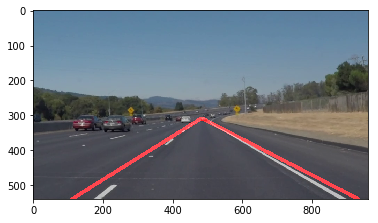

In [114]:
white_output = 'test_videos/modified_solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [254]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

(540, 960, 3)
highest =  [463, 318]
highest =  [509, 319]
[MoviePy] >>>> Building video test_videos/modified_solidYellowLeft.mp4
[MoviePy] Writing video test_videos/modified_solidYellowLeft.mp4



  0%|          | 0/683 [00:00<?, ?it/s]

(540, 960, 3)
highest =  [463, 318]
highest =  [509, 319]
(540, 960, 3)



  0%|          | 3/683 [00:00<00:28, 23.49it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
highest =  [241, 488]
highest =  [512, 321]



  1%|          | 6/683 [00:00<00:30, 22.19it/s]

(540, 960, 3)
highest =  [188, 517]
(540, 960, 3)



  1%|          | 8/683 [00:00<00:32, 20.68it/s]

(540, 960, 3)
highest =  [513, 321]
(540, 960, 3)



  1%|▏         | 10/683 [00:00<00:35, 18.98it/s]

highest =  [512, 322]
(540, 960, 3)
highest =  [513, 321]
(540, 960, 3)
highest =  [514, 331]
highest =  [513, 322]


  2%|▏         | 12/683 [00:00<00:35, 18.65it/s]


(540, 960, 3)
highest =  [494, 317]



  2%|▏         | 14/683 [00:00<00:35, 18.84it/s]

(540, 960, 3)
highest =  [485, 317]
(540, 960, 3)
highest =  [462, 320]
highest =  [502, 319]
(540, 960, 3)
highest =  [303, 441]
highest =  [490, 318]


(540, 960, 3)
highest =  [285, 447]
highest =  [490, 318]



  2%|▏         | 17/683 [00:00<00:34, 19.26it/s]

(540, 960, 3)
highest =  [465, 320]
highest =  [490, 318]
(540, 960, 3)
highest =  [468, 320]
highest =  [494, 318]
(540, 960, 3)
highest =  [479, 317]
highest =  [494, 317]
(540, 960, 3)
highest =  [468, 318]
highest =  [503, 320]



  3%|▎         | 20/683 [00:01<00:32, 20.64it/s]

(540, 960, 3)
highest =  [470, 317]
highest =  [490, 315]



  3%|▎         | 23/683 [00:01<00:31, 20.94it/s]

(540, 960, 3)
highest =  [480, 315]
highest =  [492, 316]
(540, 960, 3)
highest =  [477, 316]
highest =  [490, 315]
(540, 960, 3)
highest =  [480, 315]
highest =  [490, 315]
(540, 960, 3)
highest =  [488, 316]
highest =  [507, 321]
(540, 960, 3)
highest =  [479, 317]
highest =  [491, 317]



  4%|▍         | 29/683 [00:01<00:30, 21.41it/s]

(540, 960, 3)
highest =  [465, 318]
highest =  [480, 316]
(540, 960, 3)
highest =  [450, 324]
highest =  [517, 324]
(540, 960, 3)
highest =  [461, 319]
highest =  [483, 314]
(540, 960, 3)
highest =  [465, 317]
highest =  [480, 314]


(540, 960, 3)
highest =  [448, 325]
highest =  [540, 334]



  5%|▌         | 35/683 [00:01<00:28, 22.86it/s]

(540, 960, 3)
highest =  [436, 331]
highest =  [548, 342]
(540, 960, 3)
highest =  [442, 330]
highest =  [531, 330]
(540, 960, 3)
highest =  [434, 332]
highest =  [533, 332]
(540, 960, 3)
highest =  [437, 334]
highest =  [531, 330]
(540, 960, 3)
highest =  [432, 333]
highest =  [532, 331]



  6%|▌         | 38/683 [00:01<00:28, 22.64it/s]

(540, 960, 3)
highest =  [442, 329]
highest =  [533, 331]
(540, 960, 3)
highest =  [431, 333]
highest =  [535, 332]
(540, 960, 3)
highest =  [439, 330]
highest =  [536, 333]
(540, 960, 3)
highest =  [438, 330]
highest =  [538, 333]
(540, 960, 3)
highest =  [436, 332]
highest =  [539, 334]



  6%|▋         | 44/683 [00:02<00:27, 23.20it/s]

(540, 960, 3)
highest =  [440, 329]
highest =  [533, 331]
(540, 960, 3)
highest =  [440, 329]
highest =  [525, 327]
(540, 960, 3)
highest =  [442, 328]
highest =  [524, 327]
(540, 960, 3)
highest =  [443, 328]
highest =  [525, 327]


(540, 960, 3)
highest =  [431, 333]
highest =  [515, 322]



  7%|▋         | 47/683 [00:02<00:28, 22.21it/s]

(540, 960, 3)
highest =  [444, 327]
highest =  [515, 322]
(540, 960, 3)
highest =  [446, 326]
highest =  [513, 321]
(540, 960, 3)
highest =  [439, 332]
highest =  [516, 323]
(540, 960, 3)


  7%|▋         | 50/683 [00:02<00:29, 21.65it/s]


highest =  [431, 333]
highest =  [517, 323]



  8%|▊         | 53/683 [00:02<00:29, 21.12it/s]

(540, 960, 3)
highest =  [444, 327]
highest =  [519, 324]
(540, 960, 3)
highest =  [444, 327]
highest =  [518, 325]
(540, 960, 3)
highest =  [446, 326]
highest =  [520, 325]


(540, 960, 3)
highest =  [448, 325]
highest =  [511, 320]
(540, 960, 3)


  8%|▊         | 56/683 [00:02<00:31, 20.03it/s]


highest =  [448, 325]
highest =  [511, 320]
(540, 960, 3)
highest =  [446, 326]
highest =  [512, 321]
(540, 960, 3)
highest =  [446, 326]
highest =  [511, 320]
(540, 960, 3)
highest =  [446, 326]
highest =  [507, 318]



  9%|▉         | 61/683 [00:02<00:31, 19.46it/s]

(540, 960, 3)
highest =  [446, 326]
highest =  [511, 320]
(540, 960, 3)
highest =  [448, 325]
highest =  [507, 318]
(540, 960, 3)
highest =  [444, 327]
highest =  [509, 320]
(540, 960, 3)
highest =  [446, 326]
highest =  [514, 323]



  9%|▉         | 63/683 [00:03<00:34, 17.95it/s]

(540, 960, 3)
highest =  [446, 326]
highest =  [513, 321]
(540, 960, 3)
highest =  [448, 325]
highest =  [507, 318]
(540, 960, 3)
highest =  [448, 325]
highest =  [505, 317]



 10%|▉         | 66/683 [00:03<00:33, 18.67it/s]

(540, 960, 3)
highest =  [450, 324]
highest =  [505, 317]



 10%|▉         | 68/683 [00:03<00:34, 17.96it/s]

(540, 960, 3)
highest =  [450, 324]
highest =  [505, 317]
(540, 960, 3)
highest =  [451, 324]
highest =  [503, 316]
(540, 960, 3)
highest =  [452, 324]
highest =  [505, 318]


(540, 960, 3)
highest =  [452, 324]
highest =  [505, 318]



 11%|█         | 72/683 [00:03<00:33, 18.03it/s]

(540, 960, 3)
highest =  [453, 323]
highest =  [503, 316]
(540, 960, 3)
highest =  [453, 323]
highest =  [502, 316]
(540, 960, 3)
highest =  [446, 329]
highest =  [501, 315]


(540, 960, 3)
highest =  [454, 323]
highest =  [501, 315]



 11%|█         | 76/683 [00:03<00:36, 16.44it/s]

(540, 960, 3)
highest =  [453, 324]
highest =  [501, 315]
(540, 960, 3)
highest =  [454, 322]
highest =  [499, 314]


(540, 960, 3)
highest =  [456, 321]
highest =  [499, 314]
(540, 960, 3)
highest =  [442, 328]
highest =  [513, 321]



 11%|█▏        | 78/683 [00:03<00:36, 16.77it/s]

(540, 960, 3)
highest =  [456, 321]
highest =  [508, 319]
(540, 960, 3)
highest =  [452, 324]
highest =  [501, 315]
(540, 960, 3)


 12%|█▏        | 81/683 [00:04<00:34, 17.59it/s]


highest =  [456, 321]
highest =  [501, 315]
(540, 960, 3)
highest =  [452, 323]
highest =  [501, 315]
(540, 960, 3)



 12%|█▏        | 83/683 [00:04<00:33, 17.94it/s]

highest =  [454, 322]
highest =  [503, 316]
(540, 960, 3)
highest =  [452, 323]
highest =  [502, 316]



 12%|█▏        | 85/683 [00:04<00:34, 17.46it/s]

(540, 960, 3)
highest =  [452, 323]
highest =  [503, 316]
(540, 960, 3)
highest =  [454, 322]
highest =  [503, 317]



 13%|█▎        | 87/683 [00:04<00:36, 16.19it/s]

(540, 960, 3)
highest =  [454, 322]
highest =  [503, 317]



 13%|█▎        | 89/683 [00:04<00:37, 15.92it/s]

(540, 960, 3)
highest =  [454, 322]
highest =  [503, 317]
(540, 960, 3)
highest =  [449, 326]
highest =  [501, 315]
(540, 960, 3)


highest =  [456, 321]
highest =  [499, 314]
(540, 960, 3)
highest =  [456, 321]
highest =  [497, 313]



 14%|█▎        | 93/683 [00:04<00:34, 17.28it/s]

(540, 960, 3)
highest =  [459, 320]
highest =  [490, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [485, 310]
(540, 960, 3)


highest =  [467, 316]
highest =  [491, 312]
(540, 960, 3)
highest =  [467, 316]
highest =  [493, 313]
(540, 960, 3)
highest =  [467, 316]
highest =  [491, 312]



 14%|█▍        | 96/683 [00:04<00:32, 17.84it/s]

(540, 960, 3)
highest =  [465, 317]
highest =  [492, 312]
(540, 960, 3)



 14%|█▍        | 99/683 [00:05<00:31, 18.60it/s]

highest =  [492, 311]
highest =  [493, 312]
(540, 960, 3)
highest =  [461, 319]
highest =  [492, 311]
(540, 960, 3)
highest =  [463, 318]
highest =  [501, 316]
(540, 960, 3)
highest =  [463, 318]
highest =  [492, 311]
(540, 960, 3)
highest =  [463, 318]
highest =  [491, 311]



 15%|█▌        | 104/683 [00:05<00:32, 17.77it/s]

(540, 960, 3)
highest =  [463, 318]
highest =  [491, 311]
(540, 960, 3)
highest =  [463, 318]
highest =  [491, 311]
(540, 960, 3)
highest =  [463, 318]
highest =  [493, 311]


(540, 960, 3)
highest =  [463, 318]
highest =  [491, 311]



 16%|█▌        | 108/683 [00:05<00:32, 17.87it/s]

(540, 960, 3)
highest =  [438, 337]
highest =  [490, 311]
(540, 960, 3)
highest =  [450, 324]
highest =  [492, 312]
(540, 960, 3)
highest =  [467, 316]
highest =  [490, 312]



 16%|█▌        | 110/683 [00:05<00:31, 17.91it/s]

(540, 960, 3)
highest =  [443, 335]
highest =  [492, 313]



 16%|█▋        | 112/683 [00:05<00:32, 17.83it/s]

(540, 960, 3)
highest =  [469, 315]
highest =  [491, 310]
(540, 960, 3)
highest =  [469, 315]
highest =  [488, 310]
(540, 960, 3)
highest =  [469, 315]
highest =  [487, 310]


(540, 960, 3)
highest =  [469, 315]
highest =  [487, 310]



 17%|█▋        | 116/683 [00:06<00:32, 17.40it/s]

(540, 960, 3)
highest =  [470, 315]
highest =  [488, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [490, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [490, 310]


(540, 960, 3)
highest =  [480, 310]
highest =  [491, 310]



 18%|█▊        | 120/683 [00:06<00:32, 17.26it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [488, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [488, 310]
(540, 960, 3)
highest =  [487, 310]
highest =  [488, 310]



 18%|█▊        | 122/683 [00:06<00:31, 17.73it/s]

(540, 960, 3)
highest =  [471, 314]
highest =  [488, 310]



 18%|█▊        | 124/683 [00:06<00:32, 17.20it/s]

(540, 960, 3)
highest =  [471, 314]
highest =  [488, 310]
(540, 960, 3)
highest =  [471, 314]
highest =  [490, 311]
(540, 960, 3)


highest =  [471, 315]
highest =  [486, 311]
(540, 960, 3)



 18%|█▊        | 126/683 [00:06<00:34, 15.91it/s]

highest =  [480, 310]
highest =  [483, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [490, 310]



 19%|█▊        | 128/683 [00:06<00:37, 14.72it/s]

(540, 960, 3)
highest =  [479, 310]
highest =  [485, 310]



 19%|█▉        | 130/683 [00:06<00:36, 15.25it/s]

(540, 960, 3)
highest =  [479, 310]
highest =  [485, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [485, 310]
(540, 960, 3)
highest =  [479, 311]
highest =  [488, 310]


(540, 960, 3)
highest =  [478, 311]
highest =  [483, 310]



 20%|█▉        | 134/683 [00:07<00:34, 16.02it/s]

(540, 960, 3)
highest =  [478, 311]
highest =  [483, 310]
(540, 960, 3)
highest =  [477, 311]
highest =  [485, 310]
(540, 960, 3)
highest =  [479, 311]
highest =  [483, 310]



 20%|██        | 138/683 [00:07<00:35, 15.49it/s]

(540, 960, 3)
highest =  [484, 310]
highest =  [485, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [480, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [483, 311]
(540, 960, 3)


 21%|██        | 142/683 [00:07<00:31, 17.02it/s]


highest =  [479, 310]
highest =  [484, 311]
(540, 960, 3)
highest =  [477, 311]
highest =  [484, 310]
(540, 960, 3)
highest =  [480, 311]
highest =  [482, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [483, 311]



 21%|██▏       | 146/683 [00:07<00:31, 17.16it/s]

(540, 960, 3)
highest =  [482, 311]
highest =  [483, 310]
(540, 960, 3)
highest =  [482, 310]
highest =  [481, 311]
(540, 960, 3)
highest =  [482, 310]
highest =  [490, 310]
(540, 960, 3)
highest =  [477, 311]
highest =  [485, 311]



 22%|██▏       | 148/683 [00:08<00:31, 17.03it/s]

(540, 960, 3)
highest =  [477, 313]
highest =  [480, 312]
(540, 960, 3)
highest =  [481, 311]
highest =  [480, 311]
(540, 960, 3)
highest =  [477, 311]
highest =  [493, 311]
(540, 960, 3)
highest =  [484, 311]
highest =  [487, 310]



 22%|██▏       | 152/683 [00:08<00:30, 17.24it/s]

(540, 960, 3)
highest =  [492, 311]
highest =  [483, 310]
(540, 960, 3)
highest =  [486, 310]
highest =  [482, 310]
(540, 960, 3)
highest =  [474, 313]
highest =  [483, 310]
(540, 960, 3)
highest =  [477, 311]
highest =  [485, 310]



 23%|██▎       | 156/683 [00:08<00:31, 16.91it/s]

(540, 960, 3)
highest =  [486, 310]
highest =  [484, 310]
(540, 960, 3)
highest =  [489, 310]
highest =  [493, 312]
(540, 960, 3)
highest =  [485, 311]
highest =  [486, 311]
(540, 960, 3)
highest =  [486, 310]
highest =  [484, 313]



 24%|██▎       | 162/683 [00:08<00:29, 17.82it/s]

(540, 960, 3)
highest =  [489, 310]
highest =  [485, 311]
(540, 960, 3)
highest =  [488, 310]
highest =  [483, 312]
(540, 960, 3)
highest =  [485, 311]
highest =  [485, 312]
(540, 960, 3)
highest =  [489, 310]
highest =  [482, 313]



 24%|██▍       | 164/683 [00:08<00:29, 17.43it/s]

(540, 960, 3)
highest =  [490, 310]
highest =  [478, 311]
(540, 960, 3)
highest =  [485, 310]
highest =  [484, 311]
(540, 960, 3)
highest =  [486, 310]
highest =  [485, 310]
(540, 960, 3)
highest =  [485, 310]
highest =  [486, 310]



 25%|██▍       | 168/683 [00:09<00:33, 15.58it/s]

(540, 960, 3)
highest =  [484, 310]
highest =  [491, 310]
(540, 960, 3)
highest =  [491, 310]
highest =  [491, 311]
(540, 960, 3)
highest =  [486, 310]
highest =  [487, 312]



 25%|██▌       | 172/683 [00:09<00:32, 15.51it/s]

(540, 960, 3)
highest =  [491, 310]
highest =  [486, 310]
(540, 960, 3)
highest =  [487, 310]
highest =  [485, 310]
(540, 960, 3)
highest =  [487, 310]
highest =  [490, 312]
(540, 960, 3)



 26%|██▌       | 176/683 [00:09<00:31, 16.22it/s]

highest =  [485, 310]
highest =  [487, 310]
(540, 960, 3)
highest =  [487, 310]
highest =  [490, 311]
(540, 960, 3)
highest =  [480, 310]
highest =  [484, 310]
(540, 960, 3)
highest =  [484, 310]
highest =  [487, 310]



 26%|██▌       | 178/683 [00:09<00:32, 15.58it/s]

(540, 960, 3)
highest =  [483, 310]
highest =  [484, 310]
(540, 960, 3)
highest =  [483, 310]
highest =  [486, 310]
(540, 960, 3)
highest =  [486, 310]
highest =  [490, 310]



 27%|██▋       | 182/683 [00:10<00:31, 15.80it/s]

(540, 960, 3)
highest =  [487, 310]
highest =  [483, 310]
(540, 960, 3)
highest =  [485, 310]
highest =  [483, 310]
(540, 960, 3)
highest =  [485, 310]
highest =  [485, 311]
(540, 960, 3)
highest =  [483, 310]
highest =  [487, 310]



 27%|██▋       | 186/683 [00:10<00:30, 16.51it/s]

(540, 960, 3)
highest =  [486, 310]
highest =  [487, 311]
(540, 960, 3)
highest =  [485, 310]
highest =  [482, 310]
(540, 960, 3)
highest =  [486, 310]
highest =  [481, 312]
(540, 960, 3)
highest =  [486, 310]
highest =  [482, 311]



 28%|██▊       | 190/683 [00:10<00:28, 17.10it/s]

(540, 960, 3)
highest =  [485, 310]
highest =  [489, 310]
(540, 960, 3)
highest =  [485, 310]
highest =  [475, 313]
(540, 960, 3)
highest =  [484, 310]
highest =  [482, 312]
(540, 960, 3)
highest =  [485, 310]
highest =  [484, 311]



 28%|██▊       | 194/683 [00:10<00:29, 16.56it/s]

(540, 960, 3)
highest =  [484, 311]
highest =  [485, 311]
(540, 960, 3)
highest =  [473, 313]
highest =  [483, 310]
(540, 960, 3)
highest =  [474, 313]
highest =  [484, 311]
(540, 960, 3)
highest = 


 29%|██▉       | 198/683 [00:11<00:27, 17.58it/s]

 [477, 311]
highest =  [487, 310]
(540, 960, 3)
highest =  [483, 310]
highest =  [484, 310]
(540, 960, 3)
highest =  [490, 311]
highest =  [490, 310]
(540, 960, 3)
highest =  [483, 310]
highest =  [489, 312]
(540, 960, 3)
highest =  [481, 310]
highest =  [490, 310]



 30%|██▉       | 202/683 [00:11<00:27, 17.61it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [491, 310]
(540, 960, 3)
highest =  [491, 310]
highest =  [483, 310]
(540, 960, 3)
highest =  [476, 312]
highest =  [477, 313]
(540, 960, 3)
highest =  [479, 310]
highest =  [483, 310]



 30%|███       | 206/683 [00:11<00:28, 16.94it/s]

(540, 960, 3)
highest =  [483, 311]
highest =  [479, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [490, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [481, 310]
(540, 960, 3)
highest =  [483, 310]
highest =  [487, 312]



 31%|███       | 210/683 [00:11<00:27, 17.34it/s]

(540, 960, 3)
highest =  [483, 310]
highest =  [489, 311]
(540, 960, 3)
highest =  [475, 312]
highest =  [488, 311]
(540, 960, 3)
highest =  [483, 310]
highest =  [488, 311]
(540, 960, 3)
highest =  [475, 312]
highest =  [487, 310]



 31%|███▏      | 214/683 [00:11<00:29, 16.11it/s]

(540, 960, 3)
highest =  [475, 313]
highest =  [486, 312]
(540, 960, 3)
highest =  [474, 313]
highest =  [487, 312]
(540, 960, 3)
highest =  [479, 310]
highest =  [481, 313]



 32%|███▏      | 216/683 [00:12<00:29, 15.60it/s]

(540, 960, 3)
highest =  [474, 314]
highest =  [474, 313]
(540, 960, 3)
highest =  [475, 313]
highest =  [478, 312]
(540, 960, 3)
highest =  [478, 311]
highest =  [482, 310]
(540, 960, 3)
highest =  [478, 311]
highest =  [478, 312]



 32%|███▏      | 220/683 [00:12<00:28, 16.38it/s]

(540, 960, 3)
highest =  [479, 310]
highest =  [479, 311]
(540, 960, 3)
highest =  [486, 311]
highest =  [486, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [479, 312]
(540, 960, 3)
highest =  [479, 310]
highest =  [486, 310]



 33%|███▎      | 226/683 [00:12<00:25, 17.89it/s]

(540, 960, 3)
highest =  [475, 312]
highest =  [487, 310]
(540, 960, 3)
highest =  [493, 312]
highest =  [475, 312]
(540, 960, 3)
highest =  [480, 311]
highest =  [487, 310]
(540, 960, 3)
highest =  [475, 312]
highest =  [481, 312]



 33%|███▎      | 228/683 [00:12<00:27, 16.71it/s]

(540, 960, 3)
highest =  [477, 312]
highest =  [481, 310]
(540, 960, 3)
highest =  [477, 311]
highest =  [488, 310]
(540, 960, 3)
highest =  [479, 311]
highest =  [481, 310]
(540, 960, 3)
highest =  [478, 311]
highest =  [491, 310]



 34%|███▍      | 234/683 [00:13<00:24, 18.47it/s]

(540, 960, 3)
highest =  [477, 311]
highest =  [481, 310]
(540, 960, 3)
highest =  [479, 311]
highest =  [480, 311]
(540, 960, 3)
highest =  [477, 312]
highest =  [488, 311]
(540, 960, 3)
highest =  [477, 313]
highest =  [492, 311]



 35%|███▍      | 238/683 [00:13<00:24, 17.94it/s]

(540, 960, 3)
highest =  [477, 313]
highest =  [487, 312]
(540, 960, 3)
highest =  [478, 312]
highest =  [487, 311]
(540, 960, 3)
highest =  [481, 310]
highest =  [487, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [487, 310]



 35%|███▌      | 242/683 [00:13<00:24, 18.11it/s]

(540, 960, 3)
highest =  [478, 311]
highest =  [497, 313]
(540, 960, 3)
highest =  [477, 312]
highest =  [488, 310]
(540, 960, 3)
highest =  [477, 312]
highest =  [486, 310]
(540, 960, 3)
highest =  [477, 312]
highest =  [487, 310]



 36%|███▌      | 244/683 [00:13<00:25, 17.19it/s]

(540, 960, 3)
highest =  [481, 311]
highest =  [485, 310]
(540, 960, 3)
highest =  [476, 312]
highest =  [486, 311]
(540, 960, 3)
highest =  [476, 312]
highest =  [475, 312]
(540, 960, 3)
highest =  [476, 313]
highest =  [487, 312]



 36%|███▋      | 248/683 [00:13<00:24, 17.58it/s]

(540, 960, 3)
highest =  [476, 313]
highest =  [487, 310]
(540, 960, 3)
highest =  [475, 312]
highest =  [486, 311]
(540, 960, 3)
highest =  [475, 312]
highest =  [486, 311]
(540, 960, 3)
highest =  [488, 310]
highest =  [481, 312]
(540, 960, 3)


 37%|███▋      | 251/683 [00:14<00:24, 17.30it/s]


highest =  [480, 312]
highest =  [486, 311]
(540, 960, 3)
highest =  [487, 310]
highest =  [475, 312]
(540, 960, 3)
highest = 


 37%|███▋      | 255/683 [00:14<00:31, 13.46it/s]

 [487, 310]
highest =  [475, 313]
(540, 960, 3)
highest =  [488, 310]
highest =  [481, 313]
(540, 960, 3)
highest =  [489, 313]
highest =  [486, 311]
(540, 960, 3)
highest =  [480, 313]
highest =  [480, 312]



 38%|███▊      | 260/683 [00:14<00:28, 14.66it/s]

(540, 960, 3)
highest =  [474, 313]
highest =  [485, 313]
(540, 960, 3)
highest =  [474, 313]
highest =  [494, 312]
(540, 960, 3)
highest =  [474, 313]
highest =  [485, 312]
(540, 960, 3)
highest =  [475, 312]
highest =  [480, 312]



 38%|███▊      | 262/683 [00:14<00:27, 15.27it/s]

(540, 960, 3)
highest =  [475, 312]
highest =  [485, 312]
(540, 960, 3)
highest =  [486, 310]
highest =  [486, 312]
(540, 960, 3)
highest =  [495, 312]
highest =  [485, 312]
(540, 960, 3)
highest =  [480, 313]
highest =  [485, 311]



 39%|███▉      | 266/683 [00:15<00:29, 14.04it/s]

(540, 960, 3)
highest =  [476, 312]
highest =  [480, 312]
(540, 960, 3)
highest =  [481, 311]
highest =  [487, 310]



 39%|███▉      | 268/683 [00:15<00:30, 13.68it/s]

(540, 960, 3)
highest =  [475, 312]
highest =  [485, 312]
(540, 960, 3)
highest =  [473, 313]
highest =  [476, 313]
(540, 960, 3)
highest =  [476, 312]
highest =  [487, 311]
(540, 960, 3)


 40%|███▉      | 272/683 [00:15<00:26, 15.64it/s]


highest =  [476, 312]
highest =  [488, 310]
(540, 960, 3)
highest =  [477, 311]
highest =  [488, 310]
(540, 960, 3)
highest =  [477, 312]
highest =  [486, 313]
(540, 960, 3)
highest =  [477, 312]
highest =  [487, 312]
(540, 960, 3)


 41%|████      | 277/683 [00:15<00:22, 17.67it/s]


highest =  [488, 310]
highest =  [486, 312]
(540, 960, 3)
highest =  [489, 310]
highest =  [475, 312]
(540, 960, 3)
highest =  [477, 312]
highest =  [487, 310]
(540, 960, 3)
highest =  [477, 312]
highest =  [486, 311]
(540, 960, 3)



 41%|████      | 281/683 [00:16<00:23, 17.40it/s]

highest =  [477, 311]
highest =  [486, 311]
(540, 960, 3)
highest =  [477, 311]
highest =  [486, 311]
(540, 960, 3)
highest =  [476, 313]
highest =  [485, 313]
(540, 960, 3)
highest =  [490, 310]
highest =  [484, 313]



 41%|████▏     | 283/683 [00:16<00:25, 15.76it/s]

(540, 960, 3)
highest =  [486, 311]
highest =  [471, 315]
(540, 960, 3)
highest =  [477, 314]
highest =  [488, 311]
(540, 960, 3)
highest =  [487, 311]
highest =  [490, 311]



 42%|████▏     | 287/683 [00:16<00:24, 16.44it/s]

(540, 960, 3)
highest =  [487, 310]
highest =  [492, 311]
(540, 960, 3)
highest =  [486, 310]
highest =  [476, 312]
(540, 960, 3)
highest =  [485, 310]
highest =  [476, 314]
(540, 960, 3)
highest =  [486, 311]
highest =  [488, 311]



 43%|████▎     | 291/683 [00:16<00:24, 16.08it/s]

(540, 960, 3)
highest =  [485, 312]
highest =  [469, 315]
(540, 960, 3)
highest =  [485, 312]
highest =  [473, 314]
(540, 960, 3)
highest =  [484, 312]
highest =  [488, 312]
(540, 960, 3)



 43%|████▎     | 295/683 [00:16<00:22, 17.03it/s]

highest =  [490, 312]
highest =  [483, 311]
(540, 960, 3)
highest =  [485, 310]
highest =  [478, 313]
(540, 960, 3)
highest =  [477, 312]
highest =  [489, 310]
(540, 960, 3)
highest =  [482, 310]
highest =  [482, 311]



 43%|████▎     | 297/683 [00:17<00:22, 17.50it/s]

(540, 960, 3)
highest =  [482, 310]
highest =  [482, 311]
(540, 960, 3)
highest =  [482, 310]
highest =  [491, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [491, 310]
(540, 960, 3)
highest =  [482, 310]
highest =  [479, 311]



 44%|████▍     | 302/683 [00:17<00:21, 17.36it/s]

(540, 960, 3)
highest =  [483, 310]
highest =  [491, 311]
(540, 960, 3)
highest =  [482, 310]
highest =  [490, 310]
(540, 960, 3)
highest =  [482, 310]
highest =  [495, 312]
(540, 960, 3)
highest =  [481, 310]
highest =  [484, 312]



 45%|████▍     | 306/683 [00:17<00:21, 17.68it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [487, 315]
(540, 960, 3)
highest =  [477, 311]
highest =  [480, 313]
(540, 960, 3)
highest =  [474, 313]
highest =  [491, 311]
(540, 960, 3)
highest =  [474, 313]
highest =  [487, 314]



 45%|████▌     | 310/683 [00:17<00:20, 17.76it/s]

(540, 960, 3)
highest =  [473, 313]
highest =  [480, 312]
(540, 960, 3)
highest =  [480, 312]
highest =  [491, 311]
(540, 960, 3)
highest =  [455, 323]
highest =  [491, 310]
(540, 960, 3)
highest =  [474, 313]
highest =  [491, 310]



 46%|████▌     | 312/683 [00:17<00:22, 16.14it/s]

(540, 960, 3)
highest =  [474, 313]
highest =  [478, 314]
(540, 960, 3)
highest =  [474, 313]
highest =  [491, 313]
(540, 960, 3)
highest =  [490, 311]
highest =  [479, 310]



 46%|████▋     | 316/683 [00:18<00:22, 16.03it/s]

(540, 960, 3)
highest =  [478, 311]
highest =  [490, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [490, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [486, 311]
(540, 960, 3)
highest =  [470, 315]
highest =  [479, 310]



 47%|████▋     | 320/683 [00:18<00:21, 17.22it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [477, 312]
(540, 960, 3)
highest =  [454, 324]
highest =  [477, 311]
(540, 960, 3)
highest =  [490, 312]
highest =  [480, 310]
(540, 960, 3)
highest =  [467, 316]
highest =  [480, 310]



 47%|████▋     | 323/683 [00:18<00:22, 16.01it/s]

(540, 960, 3)
highest =  [490, 310]
highest =  [479, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [479, 310]
(540, 960, 3)
highest =  [496, 313]
highest =  [479, 312]



 48%|████▊     | 327/683 [00:18<00:22, 15.97it/s]

(540, 960, 3)
highest =  [481, 310]
highest =  [480, 311]
(540, 960, 3)
highest =  [481, 310]
highest =  [480, 312]
(540, 960, 3)
highest =  [480, 310]
highest =  [486, 312]
(540, 960, 3)



 48%|████▊     | 331/683 [00:19<00:23, 15.19it/s]

highest =  [480, 310]
highest =  [480, 311]
(540, 960, 3)
highest =  [474, 313]
highest =  [480, 310]
(540, 960, 3)
highest =  [471, 314]
highest =  [479, 310]
(540, 960, 3)
highest =  [471, 314]
highest =  [477, 311]



 49%|████▉     | 335/683 [00:19<00:21, 15.93it/s]

(540, 960, 3)
highest =  [470, 315]
highest =  [480, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [478, 312]
(540, 960, 3)
highest =  [481, 311]
highest =  [481, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [489, 310]



 50%|████▉     | 339/683 [00:19<00:23, 14.72it/s]

(540, 960, 3)
highest =  [481, 310]
highest =  [476, 313]
(540, 960, 3)
highest =  [481, 310]
highest =  [489, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [474, 313]
(540, 960, 3)


 50%|████▉     | 341/683 [00:19<00:21, 15.65it/s]


highest =  [482, 310]
highest =  [481, 310]
(540, 960, 3)
highest =  [482, 310]
highest =  [481, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [482, 310]
(540, 960, 3)
highest =  [482, 310]
highest =  [481, 310]



 51%|█████     | 345/683 [00:20<00:21, 15.96it/s]

(540, 960, 3)
highest =  [481, 310]
highest =  [476, 312]
(540, 960, 3)
highest =  [482, 310]
highest =  [490, 310]
(540, 960, 3)
highest =  [482, 310]
highest =  [481, 310]
(540, 960, 3)
highest =  [482, 310]
highest =  [481, 310]



 51%|█████     | 350/683 [00:20<00:19, 16.97it/s]

(540, 960, 3)
highest =  [482, 310]
highest =  [479, 312]
(540, 960, 3)
highest =  [481, 312]
highest =  [482, 310]
(540, 960, 3)
highest =  [490, 310]
highest =  [481, 310]
(540, 960, 3)
highest =  [482, 311]
highest =  [490, 310]



 52%|█████▏    | 354/683 [00:20<00:18, 17.35it/s]

(540, 960, 3)
highest =  [482, 310]
highest =  [481, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [480, 311]
(540, 960, 3)
highest =  [478, 311]
highest =  [481, 310]
(540, 960, 3)
highest =  [474, 313]
highest =  [480, 310]



 52%|█████▏    | 358/683 [00:20<00:19, 17.09it/s]

(540, 960, 3)
highest =  [478, 311]
highest =  [481, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [477, 312]
(540, 960, 3)
highest =  [479, 310]
highest =  [477, 311]
(540, 960, 3)
highest =  [479, 310]
highest =  [480, 310]



 53%|█████▎    | 360/683 [00:20<00:22, 14.51it/s]

(540, 960, 3)
highest =  [489, 312]
highest =  [489, 313]



 53%|█████▎    | 362/683 [00:21<00:25, 12.38it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [479, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [480, 310]
(540, 960, 3)
highest =  [489, 313]
highest =  [479, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [489, 311]



 54%|█████▍    | 368/683 [00:21<00:20, 15.33it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [490, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [489, 312]
(540, 960, 3)
highest =  [481, 310]
highest =  [489, 312]
(540, 960, 3)
highest =  [481, 310]
highest =  [483, 315]



 54%|█████▍    | 372/683 [00:21<00:18, 16.99it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [484, 311]
(540, 960, 3)
highest =  [479, 310]
highest =  [475, 312]
(540, 960, 3)
highest =  [477, 311]
highest =  [480, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [479, 310]



 55%|█████▌    | 376/683 [00:21<00:17, 17.37it/s]

(540, 960, 3)
highest =  [466, 317]
highest =  [480, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [478, 311]
(540, 960, 3)
highest =  [493, 314]
highest =  [479, 310]
(540, 960, 3)
highest =  [471, 315]
highest =  [490, 311]



 55%|█████▌    | 378/683 [00:22<00:17, 17.01it/s]

(540, 960, 3)
highest =  [471, 314]
highest =  [480, 310]
(540, 960, 3)
highest =  [448, 325]
highest =  [477, 311]
(540, 960, 3)
highest =  [448, 325]
highest =  [479, 311]



 56%|█████▌    | 383/683 [00:22<00:17, 17.26it/s]

(540, 960, 3)
highest =  [482, 320]
highest =  [477, 312]
(540, 960, 3)
highest =  [451, 324]
highest =  [480, 311]
(540, 960, 3)
highest =  [467, 316]
highest =  [478, 312]
(540, 960, 3)
highest =  [467, 316]
highest =  [473, 313]
(540, 960, 3)


 56%|█████▋    | 385/683 [00:22<00:17, 17.41it/s]


highest =  [454, 323]
highest =  [475, 312]
(540, 960, 3)
highest =  [474, 317]
highest =  [479, 311]
(540, 960, 3)
highest =  [483, 310]
highest =  [477, 311]
(540, 960, 3)
highest =  [454, 322]
highest =  [475, 313]
(540, 960, 3)



 57%|█████▋    | 390/683 [00:22<00:16, 17.96it/s]

highest =  [454, 322]
highest =  [478, 314]
(540, 960, 3)
highest =  [454, 322]
highest =  [477, 314]
(540, 960, 3)
highest =  [477, 311]
highest =  [479, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [483, 310]



 57%|█████▋    | 392/683 [00:22<00:16, 17.59it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [479, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [477, 311]



 58%|█████▊    | 396/683 [00:23<00:26, 10.67it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [484, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [484, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [477, 314]
(540, 960, 3)



 58%|█████▊    | 398/683 [00:23<00:25, 11.07it/s]

highest =  [479, 310]
highest =  [480, 310]
(540, 960, 3)
highest =  [470, 316]
highest =  [480, 310]
(540, 960, 3)
highest =  [479, 311]
highest =  [480, 310]



 59%|█████▉    | 402/683 [00:23<00:22, 12.48it/s]

(540, 960, 3)
highest =  [472, 314]
highest =  [479, 311]
(540, 960, 3)
highest =  [477, 311]
highest =  [480, 311]
(540, 960, 3)
highest =  [485, 310]
highest =  [481, 310]
(540, 960, 3)
highest =  [485, 310]
highest =  


 59%|█████▉    | 406/683 [00:24<00:18, 14.64it/s]

[481, 311]
(540, 960, 3)
highest =  [477, 311]
highest =  [481, 311]
(540, 960, 3)
highest =  [482, 310]
highest =  [483, 310]
(540, 960, 3)
highest =  [478, 311]
highest =  [480, 312]
(540, 960, 3)
highest =  [478, 311]
highest =  [484, 310]



 60%|██████    | 410/683 [00:24<00:16, 16.12it/s]

(540, 960, 3)
highest =  [478, 311]
highest =  [484, 310]
(540, 960, 3)
highest =  [483, 310]
highest =  [478, 311]
(540, 960, 3)
highest =  [478, 311]
highest =  [483, 311]
(540, 960, 3)
highest =  [484, 310]
highest =  [481, 311]



 61%|██████    | 415/683 [00:24<00:15, 17.74it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [482, 310]
(540, 960, 3)
highest =  [475, 312]
highest =  [482, 310]
(540, 960, 3)
highest =  [475, 312]
highest =  [481, 313]
(540, 960, 3)
highest =  [472, 314]
highest =  [480, 310]



 61%|██████    | 417/683 [00:24<00:15, 17.45it/s]

(540, 960, 3)
highest =  [481, 310]
highest =  [483, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [485, 310]
(540, 960, 3)
highest =  [486, 310]
highest =  [493, 315]
(540, 960, 3)
highest =  [481, 311]
highest =  [480, 310]



 62%|██████▏   | 422/683 [00:24<00:14, 18.48it/s]

(540, 960, 3)
highest =  [479, 311]
highest =  [477, 311]
(540, 960, 3)
highest =  [483, 310]
highest =  [480, 310]
(540, 960, 3)
highest =  [485, 310]
highest =  [484, 311]
(540, 960, 3)
highest =  [480, 310]
highest =  [485, 310]



 62%|██████▏   | 426/683 [00:25<00:13, 18.54it/s]

(540, 960, 3)
highest =  [481, 310]
highest =  [485, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [486, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [485, 314]
(540, 960, 3)
highest =  [487, 310]
highest =  [481, 311]



 63%|██████▎   | 430/683 [00:25<00:14, 16.96it/s]

(540, 960, 3)
highest =  [482, 311]
highest =  [481, 310]
(540, 960, 3)
highest =  [480, 311]
highest =  [480, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [481, 311]
(540, 960, 3)
highest =  [481, 310]
highest =  [483, 311]



 63%|██████▎   | 432/683 [00:25<00:14, 16.93it/s]

(540, 960, 3)
highest =  [481, 310]
highest =  [486, 310]
(540, 960, 3)
highest =  [485, 310]
highest =  [484, 311]
(540, 960, 3)
highest =  [473, 315]
highest =  [486, 310]



 64%|██████▍   | 436/683 [00:25<00:15, 15.74it/s]

(540, 960, 3)
highest =  [481, 310]
highest =  [486, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [485, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [485, 310]
(540, 960, 3)
highest =  [459, 320]
highest =  [480, 310]



 64%|██████▍   | 440/683 [00:26<00:14, 16.42it/s]

(540, 960, 3)
highest =  [479, 310]
highest =  [480, 310]
(540, 960, 3)
highest =  [498, 315]
highest =  [479, 310]
(540, 960, 3)
highest =  [463, 318]
highest =  [482, 310]
(540, 960, 3)
highest =  [464, 318]
highest =  [483, 313]



 65%|██████▌   | 446/683 [00:26<00:13, 18.22it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [482, 310]
(540, 960, 3)
highest =  [459, 320]
highest =  [482, 310]
(540, 960, 3)
highest =  [463, 318]
highest =  [479, 310]
(540, 960, 3)
highest =  [479, 311]
highest =  [483, 311]



 66%|██████▌   | 448/683 [00:26<00:14, 16.38it/s]

(540, 960, 3)
highest =  [477, 311]
highest =  [479, 311]
(540, 960, 3)
highest =  [479, 310]
highest =  [495, 313]
(540, 960, 3)
highest =  [459, 320]
highest =  [480, 310]
(540, 960, 3)


 66%|██████▌   | 452/683 [00:26<00:13, 17.06it/s]


highest =  [454, 323]
highest =  [481, 310]
(540, 960, 3)
highest =  [457, 321]
highest =  [486, 312]
(540, 960, 3)
highest =  [459, 320]
highest =  [482, 310]
(540, 960, 3)
highest =  [459, 320]
highest =  [497, 313]
(540, 960, 3)


 66%|██████▋   | 454/683 [00:26<00:13, 17.58it/s]


highest =  [457, 321]
highest =  [483, 310]
(540, 960, 3)
highest =  [457, 321]
highest =  [481, 312]
(540, 960, 3)
highest =  [456, 321]
highest =  [495, 312]
(540, 960, 3)
highest =  [463, 318]
highest =  [487, 310]



 67%|██████▋   | 459/683 [00:27<00:13, 16.17it/s]

(540, 960, 3)
highest =  [481, 311]
highest =  [487, 310]
(540, 960, 3)
highest =  [477, 311]
highest =  [483, 310]
(540, 960, 3)
highest =  [480, 311]
highest =  [487, 310]



 68%|██████▊   | 463/683 [00:27<00:13, 16.48it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [479, 310]
(540, 960, 3)
highest =  [465, 317]
highest =  [479, 310]
(540, 960, 3)
highest =  [479, 311]
highest =  [479, 310]
(540, 960, 3)
highest =  [478, 311]
highest =  [488, 310]



 69%|██████▊   | 468/683 [00:27<00:11, 18.18it/s]

(540, 960, 3)
highest =  [478, 311]
highest =  [490, 310]
(540, 960, 3)
highest =  [478, 311]
highest =  [482, 310]
(540, 960, 3)
highest =  [478, 311]
highest =  [482, 310]
(540, 960, 3)
highest =  [489, 310]
highest =  [488, 310]



 69%|██████▉   | 470/683 [00:27<00:11, 17.89it/s]

(540, 960, 3)
highest =  [463, 318]
highest =  [479, 311]
(540, 960, 3)
highest =  [486, 310]
highest =  [483, 311]
(540, 960, 3)
highest =  [482, 310]
highest =  [489, 311]
(540, 960, 3)
highest =  [489, 310]
highest =  [479, 310]
(540, 960, 3)
highest = 


 70%|██████▉   | 475/683 [00:28<00:11, 18.19it/s]

 [489, 310]
highest =  [476, 313]
(540, 960, 3)
highest =  [480, 310]
highest =  [485, 310]
(540, 960, 3)
highest =  [485, 310]
highest =  [479, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [485, 310]



 70%|███████   | 479/683 [00:28<00:12, 16.92it/s]

(540, 960, 3)
highest =  [481, 310]
highest =  [479, 310]
(540, 960, 3)
highest =  [485, 310]
highest =  [476, 313]
(540, 960, 3)
highest =  [480, 310]
highest =  [477, 311]
(540, 960, 3)
highest =  [485, 310]
highest =  [481, 311]



 71%|███████   | 484/683 [00:28<00:11, 17.84it/s]

(540, 960, 3)
highest =  [481, 310]
highest =  [479, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [487, 312]
(540, 960, 3)
highest =  [486, 310]
highest =  [482, 310]
(540, 960, 3)
highest =  [483, 310]
highest =  [490, 310]
(540, 960, 3)


 71%|███████▏  | 488/683 [00:28<00:10, 18.49it/s]


highest =  [484, 310]
highest =  [483, 310]
(540, 960, 3)
highest =  [482, 310]
highest =  [485, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [481, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [489, 310]



 72%|███████▏  | 490/683 [00:28<00:10, 18.36it/s]

(540, 960, 3)
highest =  [481, 310]
highest =  [480, 310]
(540, 960, 3)
highest =  [479, 311]
highest =  [488, 310]
(540, 960, 3)
highest =  [480, 311]
highest =  [479, 311]
(540, 960, 3)
highest =  [480, 311]
highest =  [484, 310]



 72%|███████▏  | 494/683 [00:29<00:12, 15.61it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [484, 310]
(540, 960, 3)
highest =  [479, 311]
highest =  [483, 312]
(540, 960, 3)
highest =  [480, 311]
highest =  [488, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [488, 310]



 73%|███████▎  | 498/683 [00:29<00:10, 16.95it/s]

(540, 960, 3)
highest =  [490, 311]
highest =  [484, 310]
(540, 960, 3)
highest =  [477, 311]
highest =  [488, 310]
(540, 960, 3)
highest =  [477, 311]
highest =  [485, 310]
(540, 960, 3)
highest =  [477, 311]
highest =  [487, 311]



 74%|███████▍  | 504/683 [00:29<00:10, 17.33it/s]

(540, 960, 3)
highest =  [479, 311]
highest =  [487, 311]
(540, 960, 3)
highest =  [490, 310]
highest =  [486, 311]
(540, 960, 3)
highest =  [478, 312]
highest =  [485, 312]
(540, 960, 3)
highest =  [493, 312]
highest =  [489, 310]



 74%|███████▍  | 506/683 [00:29<00:10, 17.60it/s]

(540, 960, 3)
highest =  [475, 312]
highest =  [486, 312]
(540, 960, 3)
highest =  [491, 310]
highest =  [484, 312]
(540, 960, 3)
highest =  [475, 312]
highest =  [486, 311]
(540, 960, 3)
highest =  [475, 312]
highest =  [484, 312]
(540, 960, 3)



 75%|███████▍  | 511/683 [00:30<00:09, 18.02it/s]

highest =  [473, 313]
highest =  [487, 310]
(540, 960, 3)
highest =  [486, 310]
highest =  [489, 311]
(540, 960, 3)
highest =  [486, 310]
highest =  [483, 314]
(540, 960, 3)
highest =  [485, 310]
highest =  [483, 314]



 75%|███████▌  | 515/683 [00:30<00:09, 17.41it/s]

(540, 960, 3)
highest =  [490, 311]
highest =  [481, 314]
(540, 960, 3)
highest =  [475, 314]
highest =  [483, 313]
(540, 960, 3)
highest =  [475, 313]
highest =  [489, 310]
(540, 960, 3)
highest =  [476, 313]
highest =  [483, 311]



 76%|███████▌  | 519/683 [00:30<00:09, 17.79it/s]

(540, 960, 3)
highest =  [482, 311]
highest =  [483, 311]
(540, 960, 3)
highest =  [482, 311]
highest =  [485, 311]
(540, 960, 3)
highest =  [485, 310]
highest =  [483, 311]
(540, 960, 3)
highest =  [481, 310]
highest =  [482, 311]



 77%|███████▋  | 523/683 [00:30<00:09, 17.18it/s]

(540, 960, 3)
highest =  [484, 311]
highest =  [486, 311]
(540, 960, 3)
highest =  [476, 312]
highest =  [486, 310]
(540, 960, 3)
highest =  [482, 311]
highest =  [486, 310]
(540, 960, 3)
highest =  [485, 311]
highest =  [484, 311]



 77%|███████▋  | 527/683 [00:31<00:08, 17.37it/s]

(540, 960, 3)
highest =  [475, 312]
highest =  [486, 310]
(540, 960, 3)
highest =  [477, 312]
highest =  [484, 311]
(540, 960, 3)
highest =  [483, 312]
highest =  [485, 311]
(540, 960, 3)
highest =  [486, 311]
highest =  [495, 312]



 78%|███████▊  | 531/683 [00:31<00:09, 16.82it/s]

(540, 960, 3)
highest =  [486, 310]
highest =  [486, 311]
(540, 960, 3)
highest =  [484, 311]
highest =  [481, 311]
(540, 960, 3)
highest =  [482, 311]
highest =  [484, 311]
(540, 960, 3)
highest =  [489, 310]



 78%|███████▊  | 535/683 [00:31<00:08, 17.53it/s]

highest =  [484, 311]
(540, 960, 3)
highest =  [483, 311]
highest =  [482, 310]
(540, 960, 3)
highest =  [493, 311]
highest =  [493, 312]
(540, 960, 3)
highest =  [485, 310]
highest =  [483, 310]
(540, 960, 3)
highest =  [484, 310]
highest =  [483, 310]



 79%|███████▉  | 539/683 [00:31<00:08, 17.95it/s]

(540, 960, 3)
highest =  [487, 310]
highest =  [487, 311]
(540, 960, 3)
highest =  [475, 317]
highest =  [491, 312]
(540, 960, 3)
highest =  [470, 317]
highest =  [490, 313]
(540, 960, 3)
highest =  [476, 317]
highest =  [490, 311]



 80%|███████▉  | 543/683 [00:31<00:07, 17.61it/s]

(540, 960, 3)
highest =  [482, 311]
highest =  [490, 310]
(540, 960, 3)
highest =  [490, 311]
highest =  [490, 310]
(540, 960, 3)
highest =  [486, 310]
highest =  [482, 310]
(540, 960, 3)
highest =  [483, 310]
highest =  [484, 310]



 80%|████████  | 547/683 [00:32<00:07, 18.18it/s]

(540, 960, 3)
highest =  [482, 310]
highest =  [489, 310]
(540, 960, 3)
highest =  [488, 310]
highest =  [488, 311]
(540, 960, 3)
highest =  [481, 310]
highest =  [488, 311]
(540, 960, 3)
highest =  [480, 310]
highest =  [487, 310]



 81%|████████  | 551/683 [00:32<00:07, 17.09it/s]

(540, 960, 3)
highest =  [469, 315]
highest =  [480, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [483, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [494, 312]
(540, 960, 3)
highest =  [482, 310]
highest =  [485, 310]



 81%|████████▏ | 555/683 [00:32<00:07, 16.11it/s]

(540, 960, 3)
highest =  [479, 310]
highest =  [485, 311]
(540, 960, 3)
highest =  [485, 310]
highest =  [485, 311]
(540, 960, 3)
highest =  [485, 310]
highest =  [495, 314]
(540, 960, 3)
highest =  [481, 311]
highest =  [485, 310]



 82%|████████▏ | 557/683 [00:32<00:07, 16.71it/s]

(540, 960, 3)
highest =  [483, 311]
highest =  [485, 310]
(540, 960, 3)
highest =  [475, 314]
highest =  [484, 310]
(540, 960, 3)
highest =  [484, 310]
highest =  [493, 312]



 82%|████████▏ | 563/683 [00:33<00:07, 16.01it/s]

(540, 960, 3)
highest =  [482, 310]
highest =  [483, 311]
(540, 960, 3)
highest =  [483, 310]
highest =  [487, 313]
(540, 960, 3)
highest =  [480, 310]
highest =  [483, 312]
(540, 960, 3)
highest =  [483, 310]
highest =  [495, 312]



 83%|████████▎ | 565/683 [00:33<00:08, 14.27it/s]

(540, 960, 3)
highest =  [479, 310]
highest =  [494, 312]
(540, 960, 3)
highest =  [479, 310]
highest =  [490, 312]
(540, 960, 3)
highest =  [483, 311]
highest = 


 83%|████████▎ | 569/683 [00:33<00:07, 15.39it/s]

 [493, 311]
(540, 960, 3)
highest =  [482, 310]
highest =  [482, 311]
(540, 960, 3)
highest =  [482, 310]
highest =  [494, 312]
(540, 960, 3)
highest =  [481, 310]
highest =  [489, 313]
(540, 960, 3)
highest =  [482, 310]
highest =  [493, 312]



 84%|████████▍ | 573/683 [00:33<00:06, 16.68it/s]

(540, 960, 3)
highest =  [482, 310]
highest =  [492, 312]
(540, 960, 3)
highest =  [481, 310]
highest =  [493, 311]
(540, 960, 3)
highest =  [481, 312]
highest =  [482, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [477, 311]



 85%|████████▍ | 578/683 [00:34<00:05, 17.94it/s]

(540, 960, 3)
highest =  [488, 310]
highest =  [481, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [493, 311]
(540, 960, 3)
highest =  [472, 314]
highest =  [493, 311]
(540, 960, 3)
highest =  [480, 311]
highest =  [492, 311]
(540, 960, 3)
highest =  [483, 312]
highest = 


 85%|████████▌ | 582/683 [00:34<00:06, 16.11it/s]

 [491, 311]
(540, 960, 3)
highest =  [480, 310]
highest =  [491, 311]
(540, 960, 3)
highest =  [480, 310]
highest =  [491, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [491, 310]



 86%|████████▌ | 584/683 [00:34<00:06, 15.86it/s]

(540, 960, 3)
highest =  [479, 310]
highest =  [490, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [490, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [490, 310]
(540, 960, 3)
highest =  [479, 312]



 86%|████████▌ | 588/683 [00:34<00:06, 15.51it/s]

highest =  [479, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [490, 310]
(540, 960, 3)
highest =  [490, 310]
highest =  [479, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [490, 311]



 87%|████████▋ | 592/683 [00:35<00:05, 17.02it/s]

(540, 960, 3)
highest =  [491, 310]
highest =  [490, 311]
(540, 960, 3)
highest =  [490, 311]
highest =  [485, 312]
(540, 960, 3)
highest =  [489, 311]
highest =  [479, 310]
(540, 960, 3)
highest =  [486, 310]
highest =  [489, 314]



 87%|████████▋ | 596/683 [00:35<00:05, 16.38it/s]

(540, 960, 3)
highest =  [485, 310]
highest =  [480, 310]
(540, 960, 3)
highest =  [490, 310]
highest =  [478, 312]
(540, 960, 3)
highest =  [489, 310]
highest =  [480, 310]
(540, 960, 3)



 88%|████████▊ | 598/683 [00:35<00:05, 15.38it/s]

highest =  [487, 310]
highest =  [479, 310]
(540, 960, 3)
highest =  [487, 310]
highest =  [479, 310]
(540, 960, 3)
highest =  [478, 312]
highest =  [487, 310]
(540, 960, 3)


 88%|████████▊ | 602/683 [00:35<00:04, 16.37it/s]


highest =  [488, 310]
highest =  [490, 311]
(540, 960, 3)
highest =  [483, 311]
highest =  [480, 310]
(540, 960, 3)
highest =  [479, 314]
highest =  [488, 310]
(540, 960, 3)
highest =  [477, 312]
highest =  [487, 312]



 89%|████████▊ | 606/683 [00:35<00:05, 14.92it/s]

(540, 960, 3)
highest =  [481, 313]
highest =  [491, 310]
(540, 960, 3)
highest =  [485, 310]
highest =  [486, 310]
(540, 960, 3)
highest =  [488, 310]
highest =  [486, 311]



 89%|████████▉ | 608/683 [00:36<00:05, 14.29it/s]

(540, 960, 3)
highest =  [487, 312]
highest =  [487, 310]
(540, 960, 3)
highest =  [491, 310]
highest =  [487, 310]
(540, 960, 3)
highest =  [487, 310]
highest =  [487, 313]



 90%|████████▉ | 612/683 [00:36<00:04, 14.94it/s]

(540, 960, 3)
highest =  [481, 310]
highest =  [479, 310]
(540, 960, 3)
highest =  [486, 310]
highest =  [488, 310]
(540, 960, 3)
highest =  [476, 314]
highest =  [488, 310]
(540, 960, 3)
highest =  [487, 310]
highest =  [479, 310]


 90%|█████████ | 616/683 [00:36<00:04, 16.23it/s]


(540, 960, 3)
highest =  [482, 311]
highest =  [477, 311]
(540, 960, 3)
highest =  [486, 310]
highest =  [486, 311]
(540, 960, 3)
highest =  [486, 310]
highest =  [485, 311]
(540, 960, 3)


 90%|█████████ | 618/683 [00:36<00:04, 15.34it/s]


highest =  [485, 310]
highest =  [480, 310]
(540, 960, 3)
highest =  [484, 310]
highest =  [479, 310]
(540, 960, 3)
highest =  [484, 312]
highest =  [479, 310]
(540, 960, 3)
highest =  [484, 311]
highest =  [479, 310]



 91%|█████████ | 622/683 [00:36<00:03, 16.98it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [493, 313]
(540, 960, 3)
highest =  [483, 310]
highest =  [483, 311]
(540, 960, 3)
highest =  [483, 310]
highest =  [486, 310]
(540, 960, 3)
highest =  [476, 312]
highest =  [482, 310]
(540, 960, 3)



 92%|█████████▏| 627/683 [00:37<00:03, 18.27it/s]

highest =  [477, 311]
highest =  [485, 310]
(540, 960, 3)
highest =  [485, 310]
highest =  [484, 310]
(540, 960, 3)
highest =  [475, 312]
highest =  [485, 311]
(540, 960, 3)
highest =  [475, 313]
highest =  [490, 310]
(540, 960, 3)
highest =  [481, 310]
highest = 


 93%|█████████▎| 633/683 [00:37<00:02, 18.57it/s]

 [481, 311]
(540, 960, 3)
highest =  [484, 310]
highest =  [480, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [487, 311]
(540, 960, 3)
highest =  [479, 310]
highest =  [486, 311]
(540, 960, 3)
highest =  [490, 310]
highest =  [486, 311]



 93%|█████████▎| 635/683 [00:37<00:02, 17.93it/s]

(540, 960, 3)
highest =  [476, 313]
highest =  [478, 311]
(540, 960, 3)
highest =  [477, 311]
highest =  [484, 310]
(540, 960, 3)
highest =  [474, 313]
highest =  [483, 310]
(540, 960, 3)
highest =  [473, 313]
highest =  [483, 310]



 94%|█████████▍| 641/683 [00:37<00:02, 18.06it/s]

(540, 960, 3)
highest =  [477, 312]
highest =  [482, 310]
(540, 960, 3)
highest =  [477, 313]
highest =  [481, 310]
(540, 960, 3)
highest =  [472, 314]
highest =  [481, 312]
(540, 960, 3)
highest =  [475, 313]
highest =  [480, 310]



 94%|█████████▍| 643/683 [00:38<00:02, 17.37it/s]

(540, 960, 3)
highest =  [474, 313]
highest =  [479, 310]
(540, 960, 3)
highest =  [474, 313]
highest =  [489, 311]
(540, 960, 3)
highest =  [463, 318]
highest =  [488, 310]
(540, 960, 3)
highest =  [473, 313]
highest =  [483, 312]



 95%|█████████▍| 647/683 [00:38<00:01, 18.03it/s]

(540, 960, 3)
highest =  [477, 311]
highest =  [487, 312]
(540, 960, 3)
highest =  [476, 312]
highest =  [485, 310]
(540, 960, 3)
highest =  [471, 315]
highest =  [477, 313]
(540, 960, 3)
highest =  [474, 313]
highest =  [485, 310]



 95%|█████████▌| 651/683 [00:38<00:01, 16.01it/s]

(540, 960, 3)
highest =  [471, 314]
highest =  [485, 311]
(540, 960, 3)
highest =  [462, 319]
highest =  [488, 310]
(540, 960, 3)
highest =  [462, 319]
highest =  [483, 311]
(540, 960, 3)
highest =  [461, 320]
highest =  [483, 310]



 96%|█████████▌| 657/683 [00:38<00:01, 17.08it/s]

(540, 960, 3)
highest =  [457, 321]
highest =  [481, 311]
(540, 960, 3)
highest =  [461, 319]
highest =  [492, 312]
(540, 960, 3)
highest =  [475, 312]
highest =  [488, 310]
(540, 960, 3)
highest =  [475, 312]
highest =  [480, 310]



 97%|█████████▋| 661/683 [00:39<00:01, 17.39it/s]

(540, 960, 3)
highest =  [479, 310]
highest =  [487, 310]
(540, 960, 3)
highest =  [478, 311]
highest =  [482, 310]
(540, 960, 3)
highest =  [478, 311]
highest =  [491, 310]
(540, 960, 3)
highest =  [481, 310]
highest =  [483, 310]



 97%|█████████▋| 665/683 [00:39<00:01, 17.27it/s]

(540, 960, 3)
highest =  [480, 310]
highest =  [482, 310]
(540, 960, 3)
highest =  [479, 310]
highest =  [485, 311]
(540, 960, 3)
highest =  [476, 312]
highest =  [487, 310]
(540, 960, 3)
highest =  [456, 321]
highest =  [484, 310]



 98%|█████████▊| 669/683 [00:39<00:00, 17.74it/s]

(540, 960, 3)
highest =  [460, 321]
highest =  [485, 310]
(540, 960, 3)
highest =  [480, 310]
highest =  [484, 310]
(540, 960, 3)
highest =  [477, 314]
highest =  [484, 310]
(540, 960, 3)
highest =  [480, 311]
highest =  [484, 310]



 98%|█████████▊| 671/683 [00:39<00:00, 17.18it/s]

(540, 960, 3)
highest =  [483, 310]
highest =  [489, 310]
(540, 960, 3)
highest =  [482, 310]
highest =  [489, 310]
(540, 960, 3)
highest =  [481, 311]
highest =  [481, 310]
(540, 960, 3)
highest =  [480, 312]
highest =  [481, 310]



 99%|█████████▉| 675/683 [00:39<00:00, 17.28it/s]

(540, 960, 3)
highest =  [489, 310]
highest =  [480, 310]
(540, 960, 3)
highest =  [479, 311]
highest =  [479, 310]
(540, 960, 3)
highest =  [478, 311]
highest =  [488, 311]
(540, 960, 3)
highest =  [488, 312]
highest =  [477, 311]
(540, 960, 3)


100%|█████████▉| 680/683 [00:40<00:00, 18.46it/s]


highest =  [480, 312]
highest =  [488, 312]
(540, 960, 3)
highest =  [480, 312]
highest =  [488, 311]
(540, 960, 3)
highest =  [474, 313]
highest =  [487, 310]
(540, 960, 3)
highest =  [473, 314]
highest =  [488, 312]



100%|██████████| 683/683 [00:40<00:00, 16.91it/s]

(540, 960, 3)
highest =  [473, 314]
highest =  [488, 312]
(540, 960, 3)
highest =  [473, 314]
highest =  [488, 312]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/modified_solidYellowLeft.mp4 

CPU times: user 27.9 s, sys: 6.91 s, total: 34.8 s
Wall time: 41.4 s


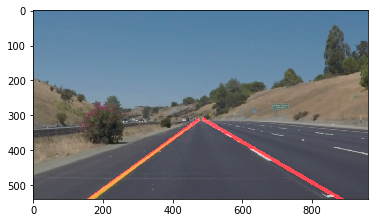

In [38]:
yellow_output = 'test_videos/modified_solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [194]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  0
mean_positive_slope =  nan
avg_pos_slope =  0
[MoviePy] >>>> Building video test_videos/modified_challenge.mp4
[MoviePy] Writing video test_videos/modified_challenge.mp4



  0%|          | 1/251 [00:00<00:38,  6.48it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  0
mean_positive_slope =  nan
avg_pos_slope =  0


(720, 1280, 3)



  1%|          | 2/251 [00:00<00:41,  5.94it/s]

mean_negative_slope =  nan
avg_neg_slope =  0
mean_positive_slope =  nan
avg_pos_slope =  0
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  0
mean_positive_slope =  nan



  1%|          | 3/251 [00:00<00:41,  5.94it/s]

avg_pos_slope =  0
(720, 1280, 3)
mean_negative_slope =  -0.555956562827
avg_neg_slope =  -0.555956562827
highest =  [683, 417]
bottom =  [173.96742637388959, 700]
end-points =  683 417 173 700
mean_positive_slope =  nan
avg_pos_slope =  0



  2%|▏         | 5/251 [00:00<00:41,  5.86it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.555956562827
highest =  [456, 568]
bottom =  [218.57137908605443, 700]
end-points =  456 568 218 700
mean_positive_slope =  nan
avg_pos_slope =  0
(720, 1280, 3)
mean_negative_slope =  nan



  2%|▏         | 6/251 [00:01<00:41,  5.84it/s]

avg_neg_slope =  -0.555956562827
highest =  [0, 1000]
bottom =  [539.61050207714891, 700]
end-points =  0 1000 539 700
mean_positive_slope =  nan
avg_pos_slope =  0
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.555956562827
highest =  [0, 1000]
bottom =  [539.61050207714891, 700]
end-points =  0 1000 539 700
mean_positive_slope =  nan



  3%|▎         | 7/251 [00:01<00:42,  5.70it/s]

avg_pos_slope =  0
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.555956562827
highest =  [0, 1000]
bottom =  [539.61050207714891, 700]
end-points =  0 1000 539 700
mean_positive_slope =  nan
avg_pos_slope =  0



  4%|▎         | 9/251 [00:01<00:43,  5.57it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.555956562827
highest =  [0, 1000]
bottom =  [539.61050207714891, 700]
end-points =  0 1000 539 700
mean_positive_slope =  nan
avg_pos_slope =  0
(720, 1280, 3)
mean_negative_slope =  nan



  4%|▍         | 10/251 [00:01<00:40,  5.99it/s]

avg_neg_slope =  -0.555956562827
highest =  [0, 1000]
bottom =  [539.61050207714891, 700]
end-points =  0 1000 539 700
mean_positive_slope =  0.268518518519
avg_pos_slope =  0.268518518519
highest =  [611, 410]
bottom =  [1691.0, 700]
end points =  611 410 1691 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.555956562827
highest =  [0, 1000]
bottom =  [539.61050207714891, 700]
end-points =  0 1000 539 700
mean_positive_slope =  nan
avg_pos_slope =  0.268518518519
highest =  [612, 409]
bottom =  [1695.7241379310344, 700]
end points =  612 409 1695 700



  5%|▍         | 12/251 [00:02<00:39,  6.06it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.555956562827
highest =  [646, 438]
bottom =  [174.74016151928987, 700]
end-points =  646 438 174 700
mean_positive_slope =  nan
avg_pos_slope =  0.268518518519
highest =  [0, 1000]
bottom =  [-1117.2413793103447, 700]
end points =  0 1000 -1117 700
(720, 1280, 3)
mean_negative_slope =  -0.530303030303
avg_neg_slope =  -0.554246327325
highest =  [485, 557]
bottom =  [226.99197549916011, 700]
end-points =  485 557 226 700
mean_positive_slope =  nan
avg_pos_slope = 


  6%|▌         | 14/251 [00:02<00:34,  6.84it/s]

 0.268518518519
highest =  [0, 1000]
bottom =  [-1117.2413793103447, 700]
end points =  0 1000 -1117 700
(720, 1280, 3)
mean_negative_slope =  -0.466666666667
avg_neg_slope =  -0.548772598534
highest =  [0, 1000]
bottom =  [546.67452566225677, 700]
end-points =  0 1000 546 700
mean_positive_slope =  nan
avg_pos_slope =  0.268518518519
highest =  [0, 1000]
bottom =  [-1117.2413793103447, 700]
end points =  0 1000 -1117 700



  6%|▌         | 15/251 [00:02<00:35,  6.61it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.548772598534
highest =  [0, 1000]
bottom =  [546.67452566225677, 700]
end-points =  0 1000 546 700
mean_positive_slope =  nan
avg_pos_slope =  0.268518518519
highest =  [0, 1000]
bottom =  [-1117.2413793103447, 700]
end points =  0 1000 -1117 700
(720, 1280, 3)
mean_negative_slope =  nan



  7%|▋         | 17/251 [00:02<00:33,  7.03it/s]

avg_neg_slope =  -0.548772598534
highest =  [0, 1000]
bottom =  [546.67452566225677, 700]
end-points =  0 1000 546 700
mean_positive_slope =  nan
avg_pos_slope =  0.268518518519
highest =  [608, 415]
bottom =  [1669.3793103448274, 700]
end points =  608 415 1669 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.548772598534
highest =  [679, 415]
bottom =  [159.65920062085604, 700]
end-points =  679 415 159 700
mean_positive_slope =  0.366972477064
avg_pos_slope =  0.27370030581
highest =  [0, 1000]
bottom =  [-1096.0893854748604, 700]
end points =  0 1000 -1096 700



  7%|▋         | 18/251 [00:02<00:33,  6.90it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.548772598534
highest =  [0, 1000]
bottom =  [546.67452566225677, 700]
end-points =  0 1000 546 700
mean_positive_slope =  nan
avg_pos_slope =  0.27370030581
highest =  [0, 1000]
bottom =  [-1096.0893854748604, 700]
end points =  0 1000 -1096 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.548772598534
highest =  [0, 1000]
bottom =  [546.67452566225677, 700]
end-points =  0 1000 546 700
mean_positive_slope =  nan



  8%|▊         | 20/251 [00:03<00:32,  7.00it/s]

avg_pos_slope =  0.27370030581
highest =  [0, 1000]
bottom =  [-1096.0893854748604, 700]
end points =  0 1000 -1096 700
(720, 1280, 3)
mean_negative_slope =  -0.533980582524
avg_neg_slope =  -0.54810023417
highest =  [0, 1000]
bottom =  [547.34514108419819, 700]
end-points =  0 1000 547 700
mean_positive_slope =  nan
avg_pos_slope =  0.27370030581
highest =  [610, 414]
bottom =  [1654.9385474860335, 700]
end points =  610 414 1654 700


(720, 1280, 3)
mean_negative_slope =  -0.425101214575
avg_neg_slope =  -0.542752450709
highest =  [0, 1000]
bottom =  [552.73817669174502, 700]
end-points =  0 1000 552 700
mean_positive_slope =  0.507142857143
avg_pos_slope =  0.283849981955
highest =  [0, 1000]
bottom =  [-1056.8963152065901, 700]
end points =  0 1000 -1056 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.542752450709
highest =  [0, 1000]
bottom =  [552.73817669174502, 700]
end-points =  0 1000 552 700
mean_positive_slope =  nan
avg_pos_slope =  0.283849981955
highest =  [0, 1000]
bottom =  [-1056.8963152065901, 700]
end points =  0 1000 -1056 700



  9%|▉         | 23/251 [00:03<00:28,  7.91it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.542752450709
highest =  [0, 1000]
bottom =  [552.73817669174502, 700]
end-points =  0 1000 552 700
mean_positive_slope =  0.48743718593
avg_pos_slope =  0.291993470114
highest =  [0, 1000]
bottom =  [-1027.4202360847498, 700]
end points =  0 1000 -1027 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.542752450709
highest =  [0, 1000]
bottom =  [552.73817669174502, 700]
end-points =  0 1000 552 700
mean_positive_slope =  nan
avg_pos_slope =  0.291993470114
highest =  [0, 1000]
bottom =  [-1027.4202360847498, 700]
end points =  0 1000 -1027 700



 10%|▉         | 24/251 [00:03<00:30,  7.36it/s]

(720, 1280, 3)
mean_negative_slope =  -0.554794520548
avg_neg_slope =  -0.543198453296
highest =  [0, 1000]
bottom =  [552.28434134845236, 700]
end-points =  0 1000 552 700
mean_positive_slope =  0.362111801242
avg_pos_slope =  0.294590445341
highest =  [0, 1000]
bottom =  [-1018.3629671101876, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.543198453296
highest =  [0, 1000]
bottom =  [552.28434134845236, 700]
end-points =  0 1000 552 700
mean_positive_slope =  nan
avg_pos_slope =  0.294590445341
highest =  [0, 1000]
bottom =  [-1018.3629671101876, 700]
end points =  0 1000 -1018 700



 11%|█         | 27/251 [00:04<00:28,  7.81it/s]

(720, 1280, 3)
mean_negative_slope =  -0.432432432432
avg_neg_slope =  -0.539378935335
highest =  [677, 423]
bottom =  [163.44638888625738, 700]
end-points =  677 423 163 700
mean_positive_slope =  nan
avg_pos_slope =  0.294590445341
highest =  [0, 1000]
bottom =  [-1018.3629671101876, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.539378935335
highest =  [500, 630]
bottom =  [370.22110910483042, 700]
end-points =  500 630 370 700
mean_positive_slope =  nan



 11%|█         | 28/251 [00:04<00:31,  7.05it/s]

avg_pos_slope =  0.294590445341
highest =  [0, 1000]
bottom =  [-1018.3629671101876, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.539378935335
highest =  [0, 1000]
bottom =  [556.19524669358407, 700]
end-points =  0 1000 556 700
mean_positive_slope =  nan
avg_pos_slope =  0.294590445341
highest =  [0, 1000]
bottom =  [-1018.3629671101876, 700]
end points =  0 1000 -1018 700



 12%|█▏        | 30/251 [00:04<00:31,  7.12it/s]

(720, 1280, 3)
mean_negative_slope =  -0.444444444444
avg_neg_slope =  -0.536412232495
highest =  [0, 1000]
bottom =  [559.27136225953723, 700]
end-points =  0 1000 559 700
mean_positive_slope =  nan
avg_pos_slope =  0.294590445341
highest =  [0, 1000]
bottom =  [-1018.3629671101876, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.536412232495
highest =  [683, 417]
bottom =  [155.42068160183641, 700]
end-points =  683 417 155 700
mean_positive_slope =  0.361111111111
avg_pos_slope =  0.296606223092
highest =  [0, 1000]
bottom =  [-1011.4420286695168, 700]
end points =  0 1000 -1011 700



 13%|█▎        | 32/251 [00:04<00:30,  7.09it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.536412232495
highest =  [0, 1000]
bottom =  [559.27136225953723, 700]
end-points =  0 1000 559 700
mean_positive_slope =  nan
avg_pos_slope =  0.296606223092
highest =  [0, 1000]
bottom =  [-1011.4420286695168, 700]
end points =  0 1000 -1011 700
(720, 1280, 3)
mean_negative_slope =  nan



 13%|█▎        | 33/251 [00:04<00:32,  6.75it/s]

avg_neg_slope =  -0.536412232495
highest =  [684, 419]
bottom =  [160.14915735023337, 700]
end-points =  684 419 160 700
mean_positive_slope =  nan
avg_pos_slope =  0.296606223092
highest =  [0, 1000]
bottom =  [-1011.4420286695168, 700]
end points =  0 1000 -1011 700
(720, 1280, 3)
mean_negative_slope =  -0.509433962264
avg_neg_slope =  -0.535662836099
highest =  [0, 1000]
bottom =  [560.05378716308314, 700]
end-points =  0 1000 560 700
mean_positive_slope =  nan
avg_pos_slope =  0.296606223092
highest =  [0, 1000]
bottom =  [-1011.4420286695168, 700]
end points =  0 1000 -1011 700



 14%|█▍        | 35/251 [00:05<00:33,  6.54it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.535662836099
highest =  [0, 1000]
bottom =  [560.05378716308314, 700]
end-points =  0 1000 560 700
mean_positive_slope =  nan
avg_pos_slope =  0.296606223092
highest =  [0, 1000]
bottom =  [-1011.4420286695168, 700]
end points =  0 1000 -1011 700
(720, 1280, 3)



 14%|█▍        | 36/251 [00:05<00:31,  6.72it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.535662836099
highest =  [0, 1000]
bottom =  [560.05378716308314, 700]
end-points =  0 1000 560 700
mean_positive_slope =  0.304470638035
avg_pos_slope =  0.29681318138
highest =  [591, 420]
bottom =  [1534.35433048615, 700]
end points =  591 420 1534 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.535662836099
highest =  [332, 600]
bottom =  [145.31540427897227, 700]
end-points =  332 600 145 700
mean_positive_slope =  nan
avg_pos_slope =  0.29681318138
highest =  [0, 1000]
bottom =  [-1010.7367826637321, 700]
end points =  0 1000 -1010 700



 15%|█▌        | 38/251 [00:05<00:30,  6.93it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.535662836099
highest =  [0, 1000]
bottom =  [560.05378716308314, 700]
end-points =  0 1000 560 700
mean_positive_slope =  0.357723577236
avg_pos_slope =  0.298335941276
highest =  [0, 1000]
bottom =  [-1005.5778017113458, 700]
end points =  0 1000 -1005 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.535662836099
highest =  [686, 419]
bottom =  [161.41628602391205, 700]
end-points =  686 419 161 700
mean_positive_slope =  nan



 16%|█▌        | 39/251 [00:05<00:31,  6.75it/s]

avg_pos_slope =  0.298335941276
highest =  [0, 1000]
bottom =  [-1005.5778017113458, 700]
end points =  0 1000 -1005 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.535662836099
highest =  [0, 1000]
bottom =  [560.05378716308314, 700]
end-points =  0 1000 560 700
mean_positive_slope =  nan
avg_pos_slope =  0.298335941276
highest =  [0, 1000]
bottom =  [-1005.5778017113458, 700]
end points =  0 1000 -1005 700



 16%|█▋        | 41/251 [00:06<00:29,  7.05it/s]

(720, 1280, 3)
mean_negative_slope =  -0.421052631579
avg_neg_slope =  -0.532997482506
highest =  [0, 1000]
bottom =  [562.85444086814357, 700]
end-points =  0 1000 562 700
mean_positive_slope =  nan
avg_pos_slope =  0.298335941276
highest =  [622, 423]
bottom =  [1550.4835035801427, 700]
end points =  622 423 1550 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.532997482506
highest =  [0, 1000]
bottom =  [562.85444086814357, 700]
end-points =  0 1000 562 700
mean_positive_slope =  nan
avg_pos_slope =  0.298335941276
highest =  [0, 1000]
bottom =  [-1005.5778017113458, 700]
end points =  0 1000 -1005 700



 17%|█▋        | 43/251 [00:06<00:27,  7.46it/s]

(720, 1280, 3)
mean_negative_slope =  -0.401960784314
avg_neg_slope =  -0.530085555879
highest =  [0, 1000]
bottom =  [565.94637728298289, 700]
end-points =  0 1000 565 700
mean_positive_slope =  0.384279475983
avg_pos_slope =  0.300245797603
highest =  [0, 1000]
bottom =  [-999.18134540112305, 700]
end points =  0 1000 -999 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.530085555879
highest =  [0, 1000]
bottom =  [565.94637728298289, 700]
end-points =  0 1000 565 700
mean_positive_slope =  0.307086614173
avg_pos_slope =  0.300394511007
highest =  [600, 416]
bottom =  [1545.4234002087476, 700]
end points =  600 416 1545 700



 18%|█▊        | 45/251 [00:06<00:30,  6.66it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.530085555879
highest =  [0, 1000]
bottom =  [565.94637728298289, 700]
end-points =  0 1000 565 700
mean_positive_slope =  nan
avg_pos_slope =  0.300394511007
highest =  [593, 420]
bottom =  [1525.1075776705961, 700]
end points =  593 420 1525 700
(720, 1280, 3)
mean_negative_slope =  -0.42
avg_neg_slope = 


 18%|█▊        | 46/251 [00:07<00:55,  3.66it/s]

 -0.527792106799
highest =  [0, 1000]
bottom =  [568.40562057604166, 700]
end-points =  0 1000 568 700
mean_positive_slope =  0.324675324675
avg_pos_slope =  0.300900361291
highest =  [0, 1000]
bottom =  [-997.00777597075546, 700]
end points =  0 1000 -997 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.527792106799
highest =  [0, 1000]
bottom =  [568.40562057604166, 700]
end-points =  0 1000 568 700
mean_positive_slope =  nan
avg_pos_slope =  0.300900361291
highest =  [0, 1000]
bottom =  [-997.00777597075546, 700]
end points =  0 1000 -997 700



 19%|█▉        | 48/251 [00:07<00:45,  4.50it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.527792106799
highest =  [687, 420]
bottom =  [156.48808746236094, 700]
end-points =  687 420 156 700
mean_positive_slope =  nan
avg_pos_slope =  0.300900361291
highest =  [0, 1000]
bottom =  [-997.00777597075546, 700]
end points =  0 1000 -997 700
(720, 1280, 3)



 20%|█▉        | 49/251 [00:07<00:44,  4.58it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.527792106799
highest =  [686, 420]
bottom =  [155.48808746236111, 700]
end-points =  686 420 155 700
mean_positive_slope =  nan
avg_pos_slope =  0.300900361291
highest =  [0, 1000]
bottom =  [-997.00777597075546, 700]
end points =  0 1000 -997 700
(720, 1280, 3)
mean_negative_slope =  -0.53326675301
avg_neg_slope =  -0.527897388457
highest =  [686, 420]
bottom =  [155.59389055007921, 700]
end-points =  686 420 155 700
mean_positive_slope =  nan



 20%|█▉        | 50/251 [00:07<00:38,  5.17it/s]

avg_pos_slope =  0.300900361291
highest =  [613, 427]
bottom =  [1520.2770761333875, 700]
end points =  613 427 1520 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.527897388457
highest =  [685, 419]
bottom =  [152.69958301632954, 700]
end-points =  685 419 152 700
mean_positive_slope =  nan
avg_pos_slope =  0.300900361291
highest =  [0, 1000]
bottom =  [-997.00777597075546, 700]
end points =  0 1000 -997 700



 21%|██        | 53/251 [00:08<00:29,  6.73it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.527897388457
highest =  [0, 1000]
bottom =  [568.29226012491517, 700]
end-points =  0 1000 568 700
mean_positive_slope =  0.304417482719
avg_pos_slope =  0.30096549317
highest =  [604, 417]
bottom =  [1544.3071329522236, 700]
end points =  604 417 1544 700
(720, 1280, 3)
mean_negative_slope =  -0.4
avg_neg_slope =  -0.525571981394
highest =  [0, 1000]
bottom =  [570.80668418525192, 700]
end-points =  0 1000 570 700
mean_positive_slope =  0.34375
avg_pos_slope =  0.301743393294
highest =  [0, 1000]
bottom =  [-994.22226523369659, 700]
end points =  0 1000 -994 700



 22%|██▏       | 54/251 [00:08<00:29,  6.77it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.525571981394
highest =  [0, 1000]
bottom =  [570.80668418525192, 700]
end-points =  0 1000 570 700
mean_positive_slope =  0.271945269799
avg_pos_slope =  0.301211283946
highest =  [0, 1000]
bottom =  [-995.97862360947613, 700]
end points =  0 1000 -995 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.525571981394
highest =  [0, 1000]
bottom =  [570.80668418525192, 700]
end-points =  0 1000 570 700
mean_positive_slope =  0.25
avg_pos_slope =  


 22%|██▏       | 56/251 [00:08<00:25,  7.60it/s]

0.300312840368
highest =  [0, 1000]
bottom =  [-998.95828507552631, 700]
end points =  0 1000 -998 700
(720, 1280, 3)
mean_negative_slope =  -0.398305084746
avg_neg_slope =  -0.523377724555
highest =  [0, 1000]
bottom =  [573.19978655017781, 700]
end-points =  0 1000 573 700
mean_positive_slope =  0.407142857143
avg_pos_slope =  0.302154737209
highest =  [0, 1000]
bottom =  [-992.86876244709572, 700]
end points =  0 1000 -992 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.523377724555
highest =  [0, 1000]
bottom =  [573.19978655017781, 700]
end-points =  0 1000 573 700
mean_positive_slope =  nan
avg_pos_slope =  0.302154737209
highest =  [0, 1000]
bottom =  [-992.86876244709572, 700]
end points =  0 1000 -992 700



 23%|██▎       | 58/251 [00:09<00:27,  7.11it/s]

(720, 1280, 3)
mean_negative_slope =  -0.405172413793
avg_neg_slope =  -0.521407636042
highest =  [0, 1000]
bottom =  [575.36556671315066, 700]
end-points =  0 1000 575 700
mean_positive_slope =  nan
avg_pos_slope =  0.302154737209
highest =  [620, 413]
bottom =  [1569.8444494077216, 700]
end points =  620 413 1569 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.521407636042
highest =  [0, 1000]
bottom =  [575.36556671315066, 700]
end-points =  0 1000 575 700
mean_positive_slope =  nan



 24%|██▎       | 59/251 [00:09<00:28,  6.79it/s]

avg_pos_slope =  0.302154737209
highest =  [0, 1000]
bottom =  [-992.86876244709572, 700]
end points =  0 1000 -992 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.521407636042
highest =  [688, 420]
bottom =  [150.99213773439283, 700]
end-points =  688 420 150 700
mean_positive_slope =  nan
avg_pos_slope =  0.302154737209
highest =  [0, 1000]
bottom =  [-992.86876244709572, 700]
end points =  0 1000 -992 700



 24%|██▍       | 61/251 [00:09<00:29,  6.39it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.521407636042
highest =  [0, 1000]
bottom =  [575.36556671315066, 700]
end-points =  0 1000 575 700
mean_positive_slope =  nan
avg_pos_slope =  0.302154737209
highest =  [614, 428]
bottom =  [1514.2010112853668, 700]
end points =  614 428 1514 700
(720, 1280, 3)
mean_negative_slope =  nan



 25%|██▌       | 63/251 [00:09<00:27,  6.75it/s]

avg_neg_slope =  -0.521407636042
highest =  [0, 1000]
bottom =  [575.36556671315066, 700]
end-points =  0 1000 575 700
mean_positive_slope =  0.4
avg_pos_slope =  0.30368356944
highest =  [0, 1000]
bottom =  [-987.87036965260234, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.532130584192
avg_neg_slope =  -0.521572604475
highest =  [686, 425]
bottom =  [158.74838126008294, 700]
end-points =  686 425 158 700
mean_positive_slope =  nan
avg_pos_slope =  0.30368356944
highest =  [602, 424]
bottom =  [1510.8407400803942, 700]
end points =  602 424 1510 700



 25%|██▌       | 64/251 [00:09<00:29,  6.36it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.521572604475
highest =  [0, 1000]
bottom =  [575.18358407990945, 700]
end-points =  0 1000 575 700
mean_positive_slope =  nan
avg_pos_slope =  0.30368356944
highest =  [0, 1000]
bottom =  [-987.87036965260234, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.446601941748
avg_neg_slope =  -0.52045363936
highest =  [0, 1000]
bottom =  [576.42021750280719, 700]
end-points =  0 1000 576 700
mean_positive_slope =  nan



 26%|██▌       | 65/251 [00:10<00:27,  6.69it/s]

avg_pos_slope =  0.30368356944
highest =  [0, 1000]
bottom =  [-987.87036965260234, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.471014492754
avg_neg_slope =  -0.519726593086
highest =  [0, 1000]
bottom =  [577.22657256862658, 700]
end-points =  0 1000 577 700
mean_positive_slope =  0.289473684211
avg_pos_slope =  0.303474600539
highest =  [995, 629]
bottom =  [1228.9569765436429, 700]
end points =  995 629 1228 700
(720, 1280, 3)
mean_negative_slope =  nan



 27%|██▋       | 67/251 [00:10<00:26,  7.04it/s]

avg_neg_slope =  -0.519726593086
highest =  [0, 1000]
bottom =  [577.22657256862658, 700]
end-points =  0 1000 577 700
mean_positive_slope =  nan
avg_pos_slope =  0.303474600539
highest =  [0, 1000]
bottom =  [-988.55060511398335, 700]
end points =  0 1000 -988 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.519726593086
highest =  [0, 1000]
bottom =  [577.22657256862658, 700]
end-points =  0 1000 577 700
mean_positive_slope =  nan
avg_pos_slope = 


 27%|██▋       | 69/251 [00:10<00:26,  6.99it/s]

 0.303474600539
highest =  [0, 1000]
bottom =  [-988.55060511398335, 700]
end points =  0 1000 -988 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.519726593086
highest =  [0, 1000]
bottom =  [577.22657256862658, 700]
end-points =  0 1000 577 700
mean_positive_slope =  0.302752293578
avg_pos_slope =  0.303464427202
highest =  [597, 419]
bottom =  [1522.973441404333, 700]
end points =  597 419 1522 700



 28%|██▊       | 70/251 [00:10<00:25,  7.03it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.519726593086
highest =  [684, 426]
bottom =  [156.79973038732118, 700]
end-points =  684 426 156 700
mean_positive_slope =  0.326732673267
avg_pos_slope =  0.303787597286
highest =  [603, 414]
bottom =  [1544.4472564215657, 700]
end points =  603 414 1544 700
(720, 1280, 3)
mean_negative_slope =  -0.441666666667
avg_neg_slope =  -0.518657279026
highest =  [633, 413]
bottom =  [79.648082257565704, 700]
end-points =  633 413 79 700
mean_positive_slope =  nan
avg_pos_slope =  


 29%|██▊       | 72/251 [00:11<00:28,  6.32it/s]

0.303787597286
highest =  [626, 423]
bottom =  [1537.8212938069012, 700]
end points =  626 423 1537 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.518657279026
highest =  [685, 426]
bottom =  [156.71280327028913, 700]
end-points =  685 426 156 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700
(720, 1280, 3)



 29%|██▉       | 73/251 [00:11<00:31,  5.58it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.518657279026
highest =  [637, 401]
bottom =  [60.511416707359402, 700]
end-points =  637 401 60 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [624, 419]
bottom =  [1548.9883883023076, 700]
end points =  624 419 1548 700
(720, 1280, 3)
mean_negative_slope =  nan



 29%|██▉       | 74/251 [00:11<00:31,  5.64it/s]

avg_neg_slope =  -0.518657279026
highest =  [0, 1000]
bottom =  [578.41663875515781, 700]
end-points =  0 1000 578 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.506923076923
avg_neg_slope =  -0.518504886791
highest =  [0, 1000]
bottom =  [578.58663947577713, 700]
end-points =  0 1000 578 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [604, 420]
bottom =  [1525.6966146784562, 700]
end points =  604 420 1525 700



 30%|███       | 76/251 [00:11<00:28,  6.15it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.518504886791
highest =  [0, 1000]
bottom =  [578.58663947577713, 700]
end-points =  0 1000 578 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan



 31%|███       | 77/251 [00:12<00:28,  6.11it/s]

avg_neg_slope =  -0.518504886791
highest =  [0, 1000]
bottom =  [578.58663947577713, 700]
end-points =  0 1000 578 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.451219512195
avg_neg_slope =  -0.517663819608
highest =  [641, 408]
bottom =  [76.927354898065289, 700]
end-points =  641 408 76 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700



 31%|███▏      | 79/251 [00:12<00:27,  6.32it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.517663819608
highest =  [642, 400]
bottom =  [62.473309826779243, 700]
end-points =  642 400 62 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan



 32%|███▏      | 80/251 [00:12<00:27,  6.19it/s]

avg_neg_slope =  -0.517663819608
highest =  [638, 407]
bottom =  [71.995599264154379, 700]
end-points =  638 407 71 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.517663819608
highest =  [0, 1000]
bottom =  [579.52669017322069, 700]
end-points =  0 1000 579 700
mean_positive_slope =  0.303834546423
avg_pos_slope =  0.303788162938
highest =  [616, 413]
bottom =  [1560.7372709454187, 700]
end points =  616 413 1560 700



 33%|███▎      | 82/251 [00:12<00:25,  6.73it/s]

(720, 1280, 3)
mean_negative_slope =  -0.360248447205
avg_neg_slope =  -0.51578982708
highest =  [617, 409]
bottom =  [52.816713083282238, 700]
end-points =  617 409 52 700
mean_positive_slope =  nan
avg_pos_slope =  0.303788162938
highest =  [0, 1000]
bottom =  [-987.53024837500232, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.421641791045
avg_neg_slope =  -0.514682203126
highest =  [630, 403]
bottom =  [52.944880946036506, 700]
end-points =  630 403 52 700
mean_positive_slope =  nan
avg_pos_slope =  0.303788162938
highest =  [0, 1000]
bottom =  [-987.53024837500232, 700]
end points =  0 1000 -987 700



 33%|███▎      | 84/251 [00:12<00:22,  7.49it/s]

(720, 1280, 3)
mean_negative_slope =  -0.286363636364
avg_neg_slope =  -0.512027336071
highest =  [0, 1000]
bottom =  [585.90621801967745, 700]
end-points =  0 1000 585 700
mean_positive_slope =  0.325396825397
avg_pos_slope =  0.304039426455
highest =  [0, 1000]
bottom =  [-986.71413604969723, 700]
end points =  0 1000 -986 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.512027336071
highest =  [631, 406]
bottom =  [56.811906340715922, 700]
end-points =  631 406 56 700
mean_positive_slope =  nan
avg_pos_slope =  0.304039426455
highest =  [0, 1000]
bottom =  [-986.71413604969723, 700]



 34%|███▍      | 86/251 [00:13<00:25,  6.41it/s]

end points =  0 1000 -986 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.512027336071
highest =  [634, 400]
bottom =  [48.093781980322511, 700]
end-points =  634 400 48 700
mean_positive_slope =  nan
avg_pos_slope =  0.304039426455
highest =  [0, 1000]
bottom =  [-986.71413604969723, 700]
end points =  0 1000 -986 700
(720, 1280, 3)
mean_negative_slope =  nan



 35%|███▌      | 88/251 [00:13<00:22,  7.29it/s]

avg_neg_slope =  -0.512027336071
highest =  [632, 401]
bottom =  [48.046802707054823, 700]
end-points =  632 401 48 700
mean_positive_slope =  0.218453919035
avg_pos_slope =  0.303077791541
highest =  [0, 1000]
bottom =  [-989.84487934619892, 700]
end points =  0 1000 -989 700
(720, 1280, 3)
mean_negative_slope =  -0.383419689119
avg_neg_slope =  -0.510598362216
highest =  [630, 402]
bottom =  [46.371022604265178, 700]
end-points =  630 402 46 700
mean_positive_slope =  0.19251591255
avg_pos_slope =  0.301849326218
highest =  [360, 547]
bottom =  [866.87540673609055, 700]
end points =  360 547 866 700
(720, 1280, 3)
mean_negative_slope =  nan


 36%|███▌      | 90/251 [00:13<00:22,  7.12it/s]


avg_neg_slope =  -0.510598362216
highest =  [627, 404]
bottom =  [47.287995606921164, 700]
end-points =  627 404 47 700
mean_positive_slope =  0.202768210231
avg_pos_slope =  0.300760522746
highest =  [397, 522]
bottom =  [988.83299182612768, 700]
end points =  397 522 988 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.510598362216
highest =  [0, 1000]
bottom =  [587.5459503983908, 700]
end-points =  0 1000 587 700
mean_positive_slope =  0.265454545455
avg_pos_slope =  0.300376762123
highest =  [411, 530]
bottom =  [976.95589751444936, 700]
end points =  411 530 976 700



 36%|███▋      | 91/251 [00:14<00:21,  7.43it/s]

(720, 1280, 3)
mean_negative_slope =  -0.266748889363
avg_neg_slope =  -0.507976324873
highest =  [0, 1000]
bottom =  [590.57870477481413, 700]
end-points =  0 1000 590 700
mean_positive_slope =  0.170542635659
avg_pos_slope =  0.298980696247
highest =  [654, 469]
bottom =  [1426.6251323224831, 700]
end points =  654 469 1426 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.507976324873
highest =  [623, 410]
bottom =  [52.107252051013035, 700]
end-points =  623 410 52 700
mean_positive_slope =  0.36119793235
avg_pos_slope =  0.299642581738
highest =  [0, 1000]
bottom =  [-1001.192815320493, 700]
end points =  0 1000 -1001 700



 37%|███▋      | 94/251 [00:14<00:19,  7.87it/s]

(720, 1280, 3)
mean_negative_slope =  -0.267716535433
avg_neg_slope =  -0.505447274458
highest =  [619, 406]
bottom =  [37.336956480524641, 700]
end-points =  619 406 37 700
mean_positive_slope =  0.174352961612
avg_pos_slope =  0.298323743631
highest =  [0, 1000]
bottom =  [-1005.6189170474782, 700]
end points =  0 1000 -1005 700
(720, 1280, 3)
mean_negative_slope =  -0.233644859813
avg_neg_slope =  -0.502615999306
highest =  [0, 1000]
bottom =  [596.87713963428052, 700]
end-points =  0 1000 596 700
mean_positive_slope =  0.169068491873
avg_pos_slope =  0.296977334759
highest =  [639, 475]
bottom =  [1396.6335755816929, 700]
end points =  639 475 1396 700



 38%|███▊      | 95/251 [00:14<00:19,  7.90it/s]

(720, 1280, 3)
mean_negative_slope =  -0.211508848094
avg_neg_slope =  -0.499614894654
highest =  [0, 1000]
bottom =  [600.46248262424319, 700]
end-points =  0 1000 600 700
mean_positive_slope =  0.317945277022
avg_pos_slope =  0.297193499112
highest =  [276, 597]
bottom =  [622.57554861652363, 700]
end points =  276 597 622 700
(720, 1280, 3)
mean_negative_slope =  -0.265486725664
avg_neg_slope =  -0.497225831705
highest =  [0, 1000]
bottom =  [603.34757542907789, 700]
end-points =  0 1000 603 700
mean_positive_slope =  nan
avg_pos_slope =  0.297193499112
highest =  [368, 566]
bottom =  [818.88469431664214, 700]
end points =  368 566 818 700



 39%|███▉      | 98/251 [00:14<00:18,  8.13it/s]

(720, 1280, 3)
mean_negative_slope =  -0.155676328502
avg_neg_slope =  -0.493775836723
highest =  [0, 1000]
bottom =  [607.56314442360838, 700]
end-points =  0 1000 607 700
mean_positive_slope =  0.286253369272
avg_pos_slope =  0.29708299275
highest =  [638, 493]
bottom =  [1334.7749923477359, 700]
end points =  638 493 1334 700
(720, 1280, 3)
mean_negative_slope =  -0.216394421999
avg_neg_slope =  -0.491002022576
highest =  [0, 1000]
bottom =  [610.99544646689083, 700]
end-points =  0 1000 610 700
mean_positive_slope =  0.233287101248
avg_pos_slope =  0.296445033835
highest =  [0, 1000]
bottom =  [-1011.9919909571847, 700]
end points =  0 1000 -1011 700



 40%|███▉      | 100/251 [00:15<00:17,  8.53it/s]

(720, 1280, 3)
mean_negative_slope =  -0.194112100335
avg_neg_slope =  -0.488062518395
highest =  [0, 1000]
bottom =  [614.67535140022153, 700]
end-points =  0 1000 614 700
mean_positive_slope =  0.230494505495
avg_pos_slope =  0.295792058307
highest =  [0, 1000]
bottom =  [-1014.2260130892674, 700]
end points =  0 1000 -1014 700
(720, 1280, 3)
mean_negative_slope =  -0.304132133554
avg_neg_slope =  -0.486259279328
highest =  [544, 512]
bottom =  [157.37498739424552, 700]
end-points =  544 512 157 700
mean_positive_slope =  0.263157894737
avg_pos_slope =  0.295472115527
highest =  [489, 475]
bottom =  [1250.4931771104705, 700]
end points =  489 475 1250 700



 40%|████      | 101/251 [00:15<00:22,  6.60it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.486259279328
highest =  [0, 1000]
bottom =  [616.95480734960836, 700]
end-points =  0 1000 616 700
mean_positive_slope =  nan
avg_pos_slope =  0.295472115527
highest =  [0, 1000]
bottom =  [-1015.3242361472941, 700]
end points =  0 1000 -1015 700



 41%|████      | 102/251 [00:15<00:22,  6.59it/s]

(720, 1280, 3)
mean_negative_slope =  -0.240384615385
avg_neg_slope =  -0.483895099867
highest =  [630, 407]
bottom =  [24.496864960400515, 700]
end-points =  630 407 24 700
mean_positive_slope =  0.191588785047
avg_pos_slope =  0.294473237349
highest =  [0, 1000]
bottom =  [-1018.768302005026, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  -0.285942492013
avg_neg_slope =  -0.482009836935
highest =  [722, 485]
bottom =  [275.95101194003257, 700]
end-points =  722 485 275 700
mean_positive_slope =  nan
avg_pos_slope =  0.294473237349
highest =  [0, 1000]
bottom =  [-1018.768302005026, 700]
end points =  0 1000 -1018 700



 41%|████▏     | 104/251 [00:15<00:22,  6.49it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.482009836935
highest =  [0, 1000]
bottom =  [622.39393682786147, 700]
end-points =  0 1000 622 700
mean_positive_slope =  nan
avg_pos_slope =  0.294473237349
highest =  [0, 1000]
bottom =  [-1018.768302005026, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  -0.266447368421
avg_neg_slope =  -0.479995234426
highest =  [0, 1000]
bottom =  [625.00620523614725, 700]
end-points =  0 1000 625 700
mean_positive_slope =  nan



 42%|████▏     | 106/251 [00:16<00:21,  6.84it/s]

avg_pos_slope =  0.294473237349
highest =  [0, 1000]
bottom =  [-1018.768302005026, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  -0.304377141191
avg_neg_slope =  -0.47836914097
highest =  [0, 1000]
bottom =  [627.13075386015987, 700]
end-points =  0 1000 627 700
mean_positive_slope =  nan
avg_pos_slope =  0.294473237349
highest =  [0, 1000]
bottom =  [-1018.768302005026, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)


 43%|████▎     | 108/251 [00:16<00:19,  7.45it/s]


mean_negative_slope =  -0.305
avg_neg_slope =  -0.476778598392
highest =  [0, 1000]
bottom =  [629.22287412136188, 700]
end-points =  0 1000 629 700
mean_positive_slope =  0.329355593018
avg_pos_slope =  0.294793258961
highest =  [0, 1000]
bottom =  [-1017.6623476998202, 700]
end points =  0 1000 -1017 700
(720, 1280, 3)
mean_negative_slope =  -0.247421707908
avg_neg_slope =  -0.474693535752
highest =  [0, 1000]
bottom =  [631.98669753317347, 700]
end-points =  0 1000 631 700
mean_positive_slope =  nan
avg_pos_slope =  0.294793258961
highest =  [759, 570]
bottom =  [1199.9870173365887, 700]
end points =  759 570 1199 700



 43%|████▎     | 109/251 [00:16<00:20,  6.86it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.474693535752
highest =  [0, 1000]
bottom =  [631.98669753317347, 700]
end-points =  0 1000 631 700
mean_positive_slope =  nan
avg_pos_slope =  0.294793258961
highest =  [724, 569]
bottom =  [1168.3792251622547, 700]
end points =  724 569 1168 700
(720, 1280, 3)
mean_negative_slope =  nan



 44%|████▍     | 111/251 [00:16<00:18,  7.63it/s]

avg_neg_slope =  -0.474693535752
highest =  [0, 1000]
bottom =  [631.98669753317347, 700]
end-points =  0 1000 631 700
mean_positive_slope =  0.44238776838
avg_pos_slope =  0.29611106708
highest =  [560, 566]
bottom =  [1012.5329003105996, 700]
end points =  560 566 1012 700
(720, 1280, 3)
mean_negative_slope =  -0.267924528302
avg_neg_slope =  -0.472863721526
highest =  [860, 536]
bottom =  [513.17703064507577, 700]
end-points =  860 536 513 700
mean_positive_slope =  0.268965517241
avg_pos_slope =  0.295870840976
highest =  [358, 619]
bottom =  [631.76810682958683, 700]
end points =  358 619 631 700
(720, 1280, 3)



 45%|████▍     | 112/251 [00:16<00:20,  6.86it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.472863721526
highest =  [556, 614]
bottom =  [374.12941850900319, 700]
end-points =  556 614 374 700
mean_positive_slope =  nan
avg_pos_slope =  0.295870840976
highest =  [608, 411]
bottom =  [1584.7775663426005, 700]
end points =  608 411 1584 700
(720, 1280, 3)
mean_negative_slope =  -0.285079365079
avg_neg_slope =  -0.471230814079
highest =  [0, 1000]
bottom =  [636.63069357280017, 700]
end-points =  0 1000 636 700
mean_positive_slope =  0.321428571429
avg_pos_slope =  0.29609308211
highest =  [0, 1000]
bottom =  [-1013.1948975709508, 700]
end points =  0 1000 -1013 700



 45%|████▌     | 114/251 [00:17<00:18,  7.32it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.471230814079
highest =  [945, 554]
bottom =  [635.17306246123724, 700]
end-points =  945 554 635 700
mean_positive_slope =  0.266375545852
avg_pos_slope =  0.295836896453
highest =  [0, 1000]
bottom =  [-1014.0722932035522, 700]
end points =  0 1000 -1014 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.471230814079
highest =  [0, 1000]
bottom =  [636.63069357280017, 700]
end-points =  0 1000 636 700
mean_positive_slope =  0.378571428571
avg_pos_slope =  0.296544029206
highest =  [853, 569]
bottom =  [1294.7556487339316, 700]
end points =  853 569 1294 700



 46%|████▌     | 116/251 [00:17<00:18,  7.32it/s]

(720, 1280, 3)
mean_negative_slope =  -0.341614906832
avg_neg_slope =  -0.470132374187
highest =  [0, 1000]
bottom =  [638.11814814652757, 700]
end-points =  0 1000 638 700
mean_positive_slope =  nan
avg_pos_slope =  0.296544029206
highest =  [0, 1000]
bottom =  [-1011.6541574059502, 700]
end points =  0 1000 -1011 700
(720, 1280, 3)
mean_negative_slope =  -0.301020408163
avg_neg_slope =  -0.468711265229
highest =  [0, 1000]
bottom =  [640.05289024466674, 700]
end-points =  0 1000 640 700
mean_positive_slope =  nan
avg_pos_slope =  0.296544029206
highest =  [0, 1000]
bottom =  [-1011.6541574059502, 700]
end points =  0 1000 -1011 700



 47%|████▋     | 118/251 [00:17<00:18,  7.25it/s]

(720, 1280, 3)
mean_negative_slope =  -0.324200913242
avg_neg_slope =  -0.467507012296
highest =  [0, 1000]
bottom =  [641.70160470289659, 700]
end-points =  0 1000 641 700
mean_positive_slope =  nan
avg_pos_slope =  0.296544029206
highest =  [0, 1000]
bottom =  [-1011.6541574059502, 700]
end points =  0 1000 -1011 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.467507012296
highest =  [0, 1000]
bottom =  [641.70160470289659, 700]
end-points =  0 1000 641 700
mean_positive_slope =  nan



 48%|████▊     | 120/251 [00:18<00:18,  6.98it/s]

avg_pos_slope =  0.296544029206
highest =  [0, 1000]
bottom =  [-1011.6541574059502, 700]
end points =  0 1000 -1011 700
(720, 1280, 3)
mean_negative_slope =  -0.29203539823
avg_neg_slope =  -0.466068720377
highest =  [0, 1000]
bottom =  [643.68190115237962, 700]
end-points =  0 1000 643 700
mean_positive_slope =  nan
avg_pos_slope =  0.296544029206
highest =  [0, 1000]
bottom =  [-1011.6541574059502, 700]
end points =  0 1000 -1011 700



 48%|████▊     | 121/251 [00:18<00:18,  6.91it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.466068720377
highest =  [642, 411]
bottom =  [21.919768556541037, 700]
end-points =  642 411 21 700
mean_positive_slope =  0.343137254902
avg_pos_slope =  0.296922835919
highest =  [0, 1000]
bottom =  [-1010.3635143846744, 700]
end points =  0 1000 -1010 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.466068720377
highest =  [0, 1000]
bottom =  [643.68190115237962, 700]
end-points =  0 1000 643 700
mean_positive_slope = 


 49%|████▊     | 122/251 [00:18<00:19,  6.48it/s]

 nan
avg_pos_slope =  0.296922835919
highest =  [625, 409]
bottom =  [1605.052608953134, 700]
end points =  625 409 1605 700
(720, 1280, 3)
mean_negative_slope =  -0.157605459278
avg_neg_slope =  -0.463601014288
highest =  [0, 1000]
bottom =  [647.1081614446623, 700]
end-points =  0 1000 647 700
mean_positive_slope =  nan
avg_pos_slope =  0.296922835919
highest =  [0, 1000]
bottom =  [-1010.3635143846744, 700]
end points =  0 1000 -1010 700



 49%|████▉     | 124/251 [00:18<00:19,  6.63it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.463601014288
highest =  [0, 1000]
bottom =  [647.1081614446623, 700]
end-points =  0 1000 647 700
mean_positive_slope =  0.339805825243
avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000 -1009 700
(720, 1280, 3)
mean_negative_slope =  -0.0663522012579
avg_neg_slope =  -0.460473070879
highest =  [0, 1000]
bottom =  [651.50389669381445, 700]
end-points =  0 1000 651 700
mean_positive_slope =  nan



 50%|████▉     | 125/251 [00:18<00:19,  6.57it/s]

avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000 -1009 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.460473070879
highest =  [0, 1000]
bottom =  [651.50389669381445, 700]
end-points =  0 1000 651 700
mean_positive_slope =  nan
avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000 -1009 700



 51%|█████     | 127/251 [00:19<00:20,  6.02it/s]

(720, 1280, 3)
mean_negative_slope =  -0.141358641359
avg_neg_slope =  -0.457999315611
highest =  [0, 1000]
bottom =  [655.02281286109303, 700]
end-points =  0 1000 655 700
mean_positive_slope =  nan
avg_pos_slope =  0.297263177104
highest =  [635, 435]
bottom =  [1526.4659480590569, 700]
end points =  635 435 1526 700
(720, 1280, 3)



 51%|█████     | 128/251 [00:19<00:19,  6.15it/s]

mean_negative_slope =  -0.15
avg_neg_slope =  -0.455630090106
highest =  [0, 1000]
bottom =  [658.42885822133007, 700]
end-points =  0 1000 658 700
mean_positive_slope =  nan
avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000 -1009 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.455630090106
highest =  [0, 1000]
bottom =  [658.42885822133007, 700]
end-points =  0 1000 658 700
mean_positive_slope =  nan
avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000


 52%|█████▏    | 130/251 [00:19<00:20,  6.01it/s]

 -1009 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.455630090106
highest =  [0, 1000]
bottom =  [658.42885822133007, 700]
end-points =  0 1000 658 700
mean_positive_slope =  nan
avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000 -1009 700
(720, 1280, 3)
mean_negative_slope =  nan



 53%|█████▎    | 132/251 [00:19<00:17,  6.64it/s]

avg_neg_slope =  -0.455630090106
highest =  [647, 400]
bottom =  [-11.428858221330227, 700]
end-points =  647 400 -11 700
mean_positive_slope =  nan
avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000 -1009 700
(720, 1280, 3)
mean_negative_slope =  -0.306306306306
avg_neg_slope =  -0.454515733511
highest =  [0, 1000]
bottom =  [660.04315776421686, 700]
end-points =  0 1000 660 700
mean_positive_slope =  0.366336633663
avg_pos_slope =  0.29777865066
highest =  [0, 1000]
bottom =  [-1007.4597333782422, 700]
end points =  0 1000 -1007 700



 53%|█████▎    | 133/251 [00:20<00:19,  6.05it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454515733511
highest =  [0, 1000]
bottom =  [660.04315776421686, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.29777865066
highest =  [0, 1000]
bottom =  [-1007.4597333782422, 700]
end points =  0 1000 -1007 700
(720, 1280, 3)



 53%|█████▎    | 134/251 [00:20<00:19,  5.92it/s]

mean_negative_slope =  -0.306604531576
avg_neg_slope =  -0.453428151144
highest =  [0, 1000]
bottom =  [661.62632214900759, 700]
end-points =  0 1000 661 700
mean_positive_slope =  nan
avg_pos_slope =  0.29777865066
highest =  [0, 1000]
bottom =  [-1007.4597333782422, 700]
end points =  0 1000 -1007 700
(720, 1280, 3)
mean_negative_slope =  nan



 54%|█████▍    | 135/251 [00:20<00:20,  5.75it/s]

avg_neg_slope =  -0.453428151144
highest =  [0, 1000]
bottom =  [661.62632214900759, 700]
end-points =  0 1000 661 700
mean_positive_slope =  0.304347826087
avg_pos_slope =  0.297826600846
highest =  [962, 605]
bottom =  [1280.9775518041879, 700]
end points =  962 605 1280 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.453428151144
highest =  [0, 1000]
bottom =  [661.62632214900759, 700]
end-points =  0 1000 661 700
mean_positive_slope =  nan
avg_pos_slope =  0.297826600846
highest =  [0, 1000]
bottom =  [-1007.2975320132249, 700]
end points =  0 1000 -1007 700



 55%|█████▍    | 137/251 [00:20<00:20,  5.69it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.453428151144
highest =  [0, 1000]
bottom =  [661.62632214900759, 700]
end-points =  0 1000 661 700
mean_positive_slope =  nan
avg_pos_slope =  0.297826600846
highest =  [0, 1000]
bottom =  [-1007.2975320132249, 700]
end points =  0 1000 -1007 700
(720, 1280, 3)
mean_negative_slope =  -0.268181818182


 55%|█████▍    | 138/251 [00:21<00:18,  5.96it/s]


avg_neg_slope =  -0.452104963051
highest =  [0, 1000]
bottom =  [663.56272219491723, 700]
end-points =  0 1000 663 700
mean_positive_slope =  nan
avg_pos_slope =  0.297826600846
highest =  [0, 1000]
bottom =  [-1007.2975320132249, 700]
end points =  0 1000 -1007 700
(720, 1280, 3)
mean_negative_slope =  -0.268817204301
avg_neg_slope =  -0.450805049868
highest =  [650, 438]
bottom =  [68.817513076977804, 700]
end-points =  650 438 68 700
mean_positive_slope =  nan
avg_pos_slope =  0.297826600846
highest =  [0, 1000]
bottom =  [-1007.2975320132249, 700]
end points =  0 1000 -1007 700



 56%|█████▌    | 140/251 [00:21<00:18,  5.95it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450805049868
highest =  [0, 1000]
bottom =  [665.47613006452923, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.297826600846
highest =  [0, 1000]
bottom =  [-1007.2975320132249, 700]
end points =  0 1000 -1007 700
(720, 1280, 3)
mean_negative_slope =  nan



 56%|█████▌    | 141/251 [00:21<00:18,  5.81it/s]

avg_neg_slope =  -0.450805049868
highest =  [0, 1000]
bottom =  [665.47613006452923, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.297826600846
highest =  [0, 1000]
bottom =  [-1007.2975320132249, 700]
end points =  0 1000 -1007 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450805049868
highest =  [649, 411]
bottom =  [7.9246613711701679, 700]
end-points =  649 411 7 700
mean_positive_slope =  0.323095435922
avg_pos_slope =  0.298002078867
highest =  [458, 544]
bottom =  [981.48628101170391, 700]
end points =  458 544 981 700



 57%|█████▋    | 143/251 [00:21<00:17,  6.18it/s]

(720, 1280, 3)
mean_negative_slope =  -0.83829787234
avg_neg_slope =  -0.453477414161
highest =  [0, 1000]
bottom =  [661.55444710473421, 700]
end-points =  0 1000 661 700
mean_positive_slope =  nan
avg_pos_slope =  0.298002078867
highest =  [0, 1000]
bottom =  [-1006.7043865609691, 700]
end points =  0 1000 -1006 700
(720, 1280, 3)



 57%|█████▋    | 144/251 [00:22<00:18,  5.82it/s]

mean_negative_slope =  -0.553189758258
avg_neg_slope =  -0.454160375422
highest =  [0, 1000]
bottom =  [660.55960897304772, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.298002078867
highest =  [464, 493]
bottom =  [1158.6260267270686, 700]
end points =  464 493 1158 700
(720, 1280, 3)
mean_negative_slope =  -0.485613605025
avg_neg_slope =  -0.454374342971
highest =  [644, 417]
bottom =  [21.165536791090869, 700]
end-points =  644 417 21 700
mean_positive_slope =  nan
avg_pos_slope = 


 58%|█████▊    | 145/251 [00:22<00:17,  6.00it/s]

 0.298002078867
highest =  [602, 416]
bottom =  [1555.013485944384, 700]
end points =  602 416 1555 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454374342971
highest =  [651, 415]
bottom =  [23.763879807282368, 700]
end-points =  651 415 23 700
mean_positive_slope =  0.286267814727
avg_pos_slope =  0.297922793299
highest =  [659, 442]
bottom =  [1524.9961768727567, 700]
end points =  659 442 1524 700



 59%|█████▊    | 147/251 [00:22<00:16,  6.16it/s]

(720, 1280, 3)
mean_negative_slope =  -0.339861895794
avg_neg_slope =  -0.453605803057
highest =  [646, 445]
bottom =  [83.837879758913061, 700]
end-points =  646 445 83 700
mean_positive_slope =  nan
avg_pos_slope =  0.297922793299
highest =  [842, 550]
bottom =  [1345.4861493446258, 700]
end points =  842 550 1345 700
(720, 1280, 3)
mean_negative_slope =  -0.324014896355
avg_neg_slope =  -0.452741863679
highest =  [657, 415]
bottom =  [27.502215800656593, 700]
end-points =  657 415 27 700
mean_positive_slope =  0.421800947867
avg_pos_slope =  0.298748647663
highest =  [879, 565]
bottom =  [1330.8848907141412, 700]
end points =  879 565 1330 700



 60%|█████▉    | 150/251 [00:22<00:13,  7.50it/s]

(720, 1280, 3)
mean_negative_slope =  -0.361774150388
avg_neg_slope =  -0.452139428491
highest =  [845, 599]
bottom =  [621.61757936702122, 700]
end-points =  845 599 621 700
mean_positive_slope =  0.465107273406
avg_pos_slope =  0.299850360416
highest =  [0, 1000]
bottom =  [-1000.4990475380769, 700]
end points =  0 1000 -1000 700
(720, 1280, 3)
mean_negative_slope =  -0.283783783784
avg_neg_slope =  -0.451031825566
highest =  [637, 413]
bottom =  [0.68126652681882238, 700]
end-points =  637 413 0 700
mean_positive_slope =  0.484303838647
avg_pos_slope =  0.301063870141
highest =  [224, 624]
bottom =  [476.43812870801975, 700]
end points =  224 624 476 700



 60%|██████    | 151/251 [00:23<00:14,  6.93it/s]

(720, 1280, 3)
mean_negative_slope =  -0.382978723404
avg_neg_slope =  -0.450587034048
highest =  [689, 423]
bottom =  [74.246402872824774, 700]
end-points =  689 423 74 700
mean_positive_slope =  nan
avg_pos_slope =  0.301063870141
highest =  [0, 1000]
bottom =  [-996.46629753165757, 700]
end points =  0 1000 -996 700
(720, 1280, 3)
mean_negative_slope =  -0.445378151261
avg_neg_slope =  -0.450553210134
highest =  [338, 625]
bottom =  [171.53797439886401, 700]
end-points =  338 625 171 700
mean_positive_slope =  nan



 61%|██████    | 153/251 [00:23<00:14,  6.92it/s]

avg_pos_slope =  0.301063870141
highest =  [331, 555]
bottom =  [812.62537714030123, 700]
end points =  331 555 812 700
(720, 1280, 3)
mean_negative_slope =  -0.423076923077
avg_neg_slope =  -0.450375943766
highest =  [624, 413]
bottom =  [-13.245403473825871, 700]
end-points =  624 413 -13 700
mean_positive_slope =  nan
avg_pos_slope =  0.301063870141
highest =  [0, 1000]
bottom =  [-996.46629753165757, 700]
end points =  0 1000 -996 700



 61%|██████▏   | 154/251 [00:23<00:14,  6.84it/s]

(720, 1280, 3)
mean_negative_slope =  -0.323101915185
avg_neg_slope =  -0.449560084608
highest =  [662, 429]
bottom =  [59.18847540455014, 700]
end-points =  662 429 59 700
mean_positive_slope =  nan
avg_pos_slope =  0.301063870141
highest =  [0, 1000]
bottom =  [-996.46629753165757, 700]
end points =  0 1000 -996 700
(720, 1280, 3)
mean_negative_slope =  -0.70004033384
avg_neg_slope =  -0.451155500209
highest =  [381, 594]
bottom =  [146.04774972042341, 700]
end-points =  381 594 146 700
mean_positive_slope =  0.31
avg_pos_slope =  0.301120788166
highest =  [621, 412]
bottom =  [1577.4268271029875, 700]
end points =  621 412 1577 700



 62%|██████▏   | 156/251 [00:23<00:13,  6.96it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451155500209
highest =  [679, 430]
bottom =  [80.536720985984005, 700]
end-points =  679 430 80 700
mean_positive_slope =  nan
avg_pos_slope =  0.301120788166
highest =  [0, 1000]
bottom =  [-996.27794489894529, 700]
end points =  0 1000 -996 700
(720, 1280, 3)
mean_negative_slope =  -0.381165919283
avg_neg_slope =  -0.450715314165
highest =  [0, 1000]
bottom =  [665.60862382901053, 700]
end-points =  0 1000 665 700
mean_positive_slope =  0.34328358209
avg_pos_slope =  0.30138596297
highest =  [0, 1000]
bottom =  [-995.40136854245054, 700]
end points =  0 1000 -995 700



 63%|██████▎   | 158/251 [00:24<00:15,  6.18it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450715314165
highest =  [0, 1000]
bottom =  [665.60862382901053, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.30138596297
highest =  [0, 1000]
bottom =  [-995.40136854245054, 700]
end points =  0 1000 -995 700
(720, 1280, 3)



 63%|██████▎   | 159/251 [00:24<00:15,  5.97it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.450715314165
highest =  [628, 408]
bottom =  [-19.85906052690359, 700]
end-points =  628 408 -19 700
mean_positive_slope =  nan
avg_pos_slope =  0.30138596297
highest =  [411, 562]
bottom =  [868.88462952952727, 700]
end points =  411 562 868 700
(720, 1280, 3)
mean_negative_slope =  nan



 64%|██████▍   | 161/251 [00:24<00:13,  6.60it/s]

avg_neg_slope =  -0.450715314165
highest =  [676, 426]
bottom =  [68.077456902836872, 700]
end-points =  676 426 68 700
mean_positive_slope =  0.38
avg_pos_slope =  0.301871234804
highest =  [0, 1000]
bottom =  [-993.80121526016626, 700]
end points =  0 1000 -993 700
(720, 1280, 3)
mean_negative_slope =  -0.445054945055
avg_neg_slope =  -0.450680587974
highest =  [368, 597]
bottom =  [139.45676395114955, 700]
end-points =  368 597 139 700
mean_positive_slope =  nan
avg_pos_slope =  0.301871234804
highest =  [617, 410]
bottom =  [1577.6745080848273, 700]
end points =  617 410 1577 700



 65%|██████▍   | 162/251 [00:24<00:13,  6.84it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450680587974
highest =  [0, 1000]
bottom =  [665.65991082189475, 700]
end-points =  0 1000 665 700
mean_positive_slope =  0.346153846154
avg_pos_slope =  0.302141250727
highest =  [0, 1000]
bottom =  [-992.91308048333826, 700]
end points =  0 1000 -992 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450680587974
highest =  [0, 1000]
bottom =  [665.65991082189475, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan



 65%|██████▍   | 163/251 [00:24<00:13,  6.62it/s]

avg_pos_slope =  0.302141250727
highest =  [0, 1000]
bottom =  [-992.91308048333826, 700]
end points =  0 1000 -992 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450680587974
highest =  [685, 423]
bottom =  [70.37401567445059, 700]
end-points =  685 423 70 700
mean_positive_slope =  nan
avg_pos_slope =  0.302141250727
highest =  [613, 414]
bottom =  [1559.5771367274492, 700]
end points =  613 414 1559 700



 66%|██████▌   | 165/251 [00:25<00:12,  7.16it/s]

(720, 1280, 3)
mean_negative_slope =  -0.509647495362
avg_neg_slope =  -0.451033683228
highest =  [0, 1000]
bottom =  [665.13879374370617, 700]
end-points =  0 1000 665 700
mean_positive_slope =  0.508571428571
avg_pos_slope =  0.303377359576
highest =  [604, 414]
bottom =  [1546.7203150550736, 700]
end points =  604 414 1546 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451033683228
highest =  [0, 1000]
bottom =  [665.13879374370617, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303377359576
highest =  [0, 1000]
bottom =  [-988.86746334448287, 700]
end points =  0 1000 -988 700



 67%|██████▋   | 167/251 [00:25<00:13,  6.03it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451033683228
highest =  [0, 1000]
bottom =  [665.13879374370617, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303377359576
highest =  [0, 1000]
bottom =  [-988.86746334448287, 700]
end points =  0 1000 -988 700
(720, 1280, 3)
mean_negative_slope =  nan



 67%|██████▋   | 168/251 [00:25<00:14,  5.62it/s]

avg_neg_slope =  -0.451033683228
highest =  [0, 1000]
bottom =  [665.13879374370617, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303377359576
highest =  [0, 1000]
bottom =  [-988.86746334448287, 700]
end points =  0 1000 -988 700
(720, 1280, 3)
mean_negative_slope =  nan



 67%|██████▋   | 169/251 [00:25<00:14,  5.74it/s]

avg_neg_slope =  -0.451033683228
highest =  [0, 1000]
bottom =  [665.13879374370617, 700]
end-points =  0 1000 665 700
mean_positive_slope =  0.388429752066
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451033683228
highest =  


 68%|██████▊   | 170/251 [00:26<00:15,  5.33it/s]

[672, 437]
bottom =  [88.894990818017732, 700]
end-points =  672 437 88 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451033683228
highest =  [702, 427]
bottom =  [96.723697693227379, 700]
end-points =  702 427 96 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [360, 627]
bottom =  [600.23056185053099, 700]
end points =  360 627 600 700



 69%|██████▊   | 172/251 [00:26<00:13,  5.74it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451033683228
highest =  [0, 1000]
bottom =  [665.13879374370617, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.399248120301
avg_neg_slope =  -0.450737765725
highest =  [689, 431]
bottom =  [92.200662436097048, 700]
end-points =  689 431 92 700
mean_positive_slope =  nan



 69%|██████▉   | 173/251 [00:26<00:12,  6.13it/s]

avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450737765725
highest =  [0, 1000]
bottom =  [665.57546940212228, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700



 70%|██████▉   | 175/251 [00:26<00:12,  5.99it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450737765725
highest =  [0, 1000]
bottom =  [665.57546940212228, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.419847328244
avg_neg_slope =  -0.450564223942
highest =  [0, 1000]
bottom =  [665.83182609434118, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan



 70%|███████   | 176/251 [00:27<00:12,  6.17it/s]

avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450564223942
highest =  [0, 1000]
bottom =  [665.83182609434118, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700



 71%|███████   | 178/251 [00:27<00:11,  6.09it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450564223942
highest =  [0, 1000]
bottom =  [665.83182609434118, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan



 71%|███████▏  | 179/251 [00:27<00:12,  5.98it/s]

avg_neg_slope =  -0.450564223942
highest =  [0, 1000]
bottom =  [665.83182609434118, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450564223942
highest =  [648, 406]
bottom =  [-4.5151895724544042, 700]
end-points =  648 406 -4 700
mean_positive_slope =  nan
avg_pos_slope = 


 72%|███████▏  | 181/251 [00:27<00:10,  6.44it/s]

 0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.486111111111
avg_neg_slope =  -0.450758469227
highest =  [0, 1000]
bottom =  [665.5448992772026, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700



 73%|███████▎  | 182/251 [00:27<00:11,  6.18it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450758469227
highest =  [655, 403]
bottom =  [-3.8894502844304788, 700]
end-points =  655 403 -3 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.485981308411
avg_neg_slope =  -0.450948862952
highest =  [0, 1000]
bottom =  [665.26390162280848, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan



 73%|███████▎  | 183/251 [00:28<00:10,  6.53it/s]

avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450948862952
highest =  [650, 400]
bottom =  [-15.263901622808442, 700]
end-points =  650 400 -15 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700



 74%|███████▎  | 185/251 [00:28<00:10,  6.41it/s]

(720, 1280, 3)
mean_negative_slope =  -0.465437788018
avg_neg_slope =  -0.451026343835
highest =  [0, 1000]
bottom =  [665.14961731317726, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451026343835
highest =  [0, 1000]
bottom =  [665.14961731317726, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan



 74%|███████▍  | 186/251 [00:28<00:10,  6.04it/s]

avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan



 75%|███████▍  | 187/251 [00:28<00:12,  5.18it/s]

avg_neg_slope =  -0.451026343835
highest =  [647, 402]
bottom =  [-13.715286531089317, 700]
end-points =  647 402 -13 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.423076923077
avg_neg_slope =  -0.45087924162
highest =  [654, 409]
bottom =  [8.5943722000994551, 700]
end-points =  654 409 8 700
mean_positive_slope =  0.468965517241
avg_pos_slope =  0.304743640805
highest =  [0, 1000]
bottom =  [-984.43399575871831, 700]
end points =  0 1000 -984 700



 75%|███████▌  | 189/251 [00:29<00:11,  5.32it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.45087924162
highest =  [0, 1000]
bottom =  [665.36662659783553, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.304743640805
highest =  [617, 407]
bottom =  [1578.4638691910147, 700]
end points =  617 407 1578 700
(720, 1280, 3)



 76%|███████▌  | 190/251 [00:29<00:11,  5.53it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.45087924162
highest =  [0, 1000]
bottom =  [665.36662659783553, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.304743640805
highest =  [0, 1000]
bottom =  [-984.43399575871831, 700]
end points =  0 1000 -984 700
(720, 1280, 3)
mean_negative_slope =  nan



 76%|███████▌  | 191/251 [00:29<00:10,  5.61it/s]

avg_neg_slope =  -0.45087924162
highest =  [0, 1000]
bottom =  [665.36662659783553, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.304743640805
highest =  [619, 410]
bottom =  [1570.6195292334276, 700]
end points =  619 410 1570 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.45087924162
highest =  [0, 1000]
bottom =  [665.36662659783553, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope = 


 77%|███████▋  | 193/251 [00:29<00:10,  5.75it/s]

 0.304743640805
highest =  [1000, 622]
bottom =  [1255.9528388972669, 700]
end points =  1000 622 1255 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.45087924162
highest =  [0, 1000]
bottom =  [665.36662659783553, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.304743640805
highest =  [614, 410]
bottom =  [1565.6195292334276, 700]
end points =  614 410 1565 700
(720, 1280, 3)
mean_negative_slope =  -0.532374100719
avg_neg_slope =  -0.451295031718
highest =  [0, 1000]
bottom =  [664.75360665508151, 700]
end-points =  0 1000 664 700
mean_positive_slope =  0.489898989899
avg_pos_slope =  0.305688310954
highest =  [0, 1000]
bottom =  [-981.39179435429196, 700]
end points =  0 1000 -981 700



 78%|███████▊  | 195/251 [00:30<00:09,  6.17it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451295031718
highest =  [612, 460]
bottom =  [80.197114675934884, 700]
end-points =  612 460 80 700
mean_positive_slope =  nan
avg_pos_slope =  0.305688310954
highest =  [0, 1000]
bottom =  [-981.39179435429196, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  -0.508474576271
avg_neg_slope =  -0.451583817296
highest =  [608, 461]
bottom =  [78.751628278348946, 700]
end-points =  608 461 78 700
mean_positive_slope =  nan



 78%|███████▊  | 196/251 [00:30<00:08,  6.27it/s]

avg_pos_slope =  0.305688310954
highest =  [616, 408]
bottom =  [1571.221346504844, 700]
end points =  616 408 1571 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451583817296
highest =  [0, 1000]



 79%|███████▉  | 198/251 [00:30<00:08,  6.00it/s]

bottom =  [664.32850006901811, 700]
end-points =  0 1000 664 700
mean_positive_slope =  nan
avg_pos_slope =  0.305688310954
highest =  [616, 407]
bottom =  [1574.492652486025, 700]
end points =  616 407 1574 700
(720, 1280, 3)
mean_negative_slope =  -0.554455445545
avg_neg_slope =  -0.452098175438
highest =  [0, 1000]
bottom =  [663.57268464875517, 700]
end-points =  0 1000 663 700
mean_positive_slope =  nan
avg_pos_slope =  0.305688310954
highest =  [0, 1000]
bottom =  [-981.39179435429196, 700]
end points =  0 1000 -981 700



 79%|███████▉  | 199/251 [00:30<00:08,  5.82it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452098175438
highest =  [0, 1000]
bottom =  [663.57268464875517, 700]
end-points =  0 1000 663 700
mean_positive_slope =  nan
avg_pos_slope =  0.305688310954
highest =  [607, 412]
bottom =  [1549.1361225801202, 700]
end points =  607 412 1549 700
(720, 1280, 3)
mean_negative_slope =  -0.532710280374
avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  0.325
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700



 80%|████████  | 201/251 [00:31<00:08,  6.24it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan



 80%|████████  | 202/251 [00:31<00:08,  5.98it/s]

avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [643, 406]
bottom =  [-6.7277123276072013, 700]
end-points =  643 406 -6 700
mean_positive_slope =  nan



 81%|████████  | 203/251 [00:31<00:08,  5.92it/s]

avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [647, 438]
bottom =  [67.990950238663146, 700]
end-points =  647 438 67 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700



 82%|████████▏ | 205/251 [00:31<00:07,  6.00it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan



 82%|████████▏ | 206/251 [00:32<00:07,  5.91it/s]

avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700



 83%|████████▎ | 208/251 [00:32<00:07,  6.07it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [368, 629]
bottom =  [600.19010842139937, 700]
end points =  368 629 600 700
(720, 1280, 3)
mean_negative_slope =  nan



 83%|████████▎ | 209/251 [00:32<00:06,  6.07it/s]

avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [555, 500]
bottom =  [113.00835896081162, 700]
end-points =  555 500 113 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700



 84%|████████▍ | 211/251 [00:32<00:06,  6.17it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan



 85%|████████▍ | 213/251 [00:33<00:05,  6.84it/s]

avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  -0.464566929134
avg_neg_slope =  -0.452553383329
highest =  [0, 1000]
bottom =  [662.90521969681095, 700]
end-points =  0 1000 662 700
mean_positive_slope =  0.305087601078
avg_pos_slope =  0.305780674713
highest =  [372, 628]
bottom =  [607.4628855064276, 700]
end points =  372 628 607 700



 85%|████████▌ | 214/251 [00:33<00:05,  6.71it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452553383329
highest =  [0, 1000]
bottom =  [662.90521969681095, 700]
end-points =  0 1000 662 700
mean_positive_slope =  0.344155844156
avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452553383329
highest =  [0, 1000]
bottom =  [662.90521969681095, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan



 86%|████████▌ | 216/251 [00:33<00:05,  6.86it/s]

avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)
mean_negative_slope =  -0.482993197279
avg_neg_slope =  -0.452693015503
highest =  [0, 1000]
bottom =  [662.70074802645604, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)



 86%|████████▋ | 217/251 [00:33<00:05,  6.58it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.452693015503
highest =  [0, 1000]
bottom =  [662.70074802645604, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)
mean_negative_slope =  nan



 87%|████████▋ | 218/251 [00:33<00:05,  6.32it/s]

avg_neg_slope =  -0.452693015503
highest =  [0, 1000]
bottom =  [662.70074802645604, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452693015503
highest =  [636, 404]
bottom =  [-17.864738052769958, 700]
end-points =  636 404 -17 700
mean_positive_slope =  nan



 87%|████████▋ | 219/251 [00:34<00:05,  6.26it/s]

avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452693015503
highest =  [0, 1000]
bottom =  [662.70074802645604, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700



 88%|████████▊ | 221/251 [00:34<00:04,  6.18it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452693015503
highest =  [0, 1000]
bottom =  [662.70074802645604, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope = 


 88%|████████▊ | 222/251 [00:34<00:04,  6.57it/s]

 -0.452693015503
highest =  [0, 1000]
bottom =  [662.70074802645604, 700]
end-points =  0 1000 662 700
mean_positive_slope =  0.47027027027
avg_pos_slope =  0.306691872948
highest =  [0, 1000]
bottom =  [-978.18046861152573, 700]
end points =  0 1000 -978 700
(720, 1280, 3)
mean_negative_slope =  -0.695364238411
avg_neg_slope =  -0.453771554271
highest =  [0, 1000]
bottom =  [661.12561965642237, 700]
end-points =  0 1000 661 700
mean_positive_slope =  0.336448598131
avg_pos_slope =  0.30682412506
highest =  [0, 1000]
bottom =  [-977.75883803476029, 700]
end points =  0 1000 -977 700
(720, 1280, 3)
mean_negative_slope =  nan



 89%|████████▉ | 224/251 [00:34<00:03,  7.18it/s]

avg_neg_slope =  -0.453771554271
highest =  [0, 1000]
bottom =  [661.12561965642237, 700]
end-points =  0 1000 661 700
mean_positive_slope =  0.342342342342
avg_pos_slope =  0.306981285314
highest =  [0, 1000]
bottom =  [-977.25827062508381, 700]
end points =  0 1000 -977 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.453771554271
highest =  [0, 1000]
bottom =  [661.12561965642237, 700]
end-points =  0 1000 661 700
mean_positive_slope =  nan
avg_pos_slope =  0.306981285314
highest =  [0, 1000]
bottom =  [-977.25827062508381, 700]
end points =  0 1000 -977 700



 90%|█████████ | 226/251 [00:35<00:03,  7.15it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.453771554271
highest =  [0, 1000]
bottom =  [661.12561965642237, 700]
end-points =  0 1000 661 700
mean_positive_slope =  0.423076923077
avg_pos_slope =  0.307490476707
highest =  [0, 1000]
bottom =  [-975.6399717231119, 700]
end points =  0 1000 -975 700
(720, 1280, 3)
mean_negative_slope =  -0.48502994012
avg_neg_slope =  -0.453908053773
highest =  [658, 435]
bottom =  [74.181321751357444, 700]
end-points =  658 435 74 700
mean_positive_slope =  0.385245901639
avg_pos_slope =  0.307830020048
highest =  [0, 1000]
bottom =  [-974.56381919292278, 700]
end points =  0 1000 -974 700



 91%|█████████ | 228/251 [00:35<00:03,  7.31it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.453908053773
highest =  [675, 427]
bottom =  [73.556606936304036, 700]
end-points =  675 427 73 700
mean_positive_slope =  nan
avg_pos_slope =  0.307830020048
highest =  [0, 1000]
bottom =  [-974.56381919292278, 700]
end points =  0 1000 -974 700
(720, 1280, 3)
mean_negative_slope =  -0.508620689655
avg_neg_slope =  -0.45414490501
highest =  [0, 1000]
bottom =  [660.58211088638177, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan



 91%|█████████ | 229/251 [00:35<00:03,  7.13it/s]

avg_pos_slope =  0.307830020048
highest =  [0, 1000]
bottom =  [-974.56381919292278, 700]
end points =  0 1000 -974 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.45414490501
highest =  [0, 1000]
bottom =  [660.58211088638177, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.307830020048
highest =  [615, 409]
bottom =  [1560.3269046171351, 700]
end points =  615 409 1560 700



 92%|█████████▏| 231/251 [00:35<00:02,  6.99it/s]

(720, 1280, 3)
mean_negative_slope =  -0.509523809524
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.307830020048
highest =  [0, 1000]
bottom =  [-974.56381919292278, 700]
end points =  0 1000 -974 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan



 92%|█████████▏| 232/251 [00:35<00:02,  6.60it/s]

avg_pos_slope =  0.307830020048
highest =  [613, 409]
bottom =  [1558.3269046171351, 700]
end points =  613 409 1558 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.307830020048
highest =  [0, 1000]
bottom =  [-974.56381919292278, 700]
end points =  0 1000 -974 700



 93%|█████████▎| 234/251 [00:36<00:02,  6.68it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  0.509960159363
avg_pos_slope =  0.308686503689
highest =  [0, 1000]
bottom =  [-971.85978789115131, 700]
end points =  0 1000 -971 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan



 94%|█████████▎| 235/251 [00:36<00:02,  6.19it/s]

avg_pos_slope =  0.308686503689
highest =  [0, 1000]
bottom =  [-971.85978789115131, 700]
end points =  0 1000 -971 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]


 94%|█████████▍| 236/251 [00:36<00:02,  5.51it/s]


end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.308686503689
highest =  [0, 1000]
bottom =  [-971.85978789115131, 700]
end points =  0 1000 -971 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [687, 423]
bottom =  [77.381562720409207, 700]
end-points =  687 423 77 700
mean_positive_slope =  0.508928571429
avg_pos_slope =  0.309524336608
highest =  [0, 1000]
bottom =  [-969.22911874160741, 700]
end points =  0 1000 -969 700



 95%|█████████▍| 238/251 [00:37<00:02,  5.55it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309524336608
highest =  [0, 1000]
bottom =  [-969.22911874160741, 700]
end points =  0 1000 -969 700
(720, 1280, 3)
mean_negative_slope =  nan



 95%|█████████▌| 239/251 [00:37<00:02,  5.61it/s]

avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309524336608
highest =  [0, 1000]
bottom =  [-969.22911874160741, 700]
end points =  0 1000 -969 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan



 96%|█████████▌| 241/251 [00:37<00:01,  6.02it/s]

avg_pos_slope =  0.309524336608
highest =  [605, 413]
bottom =  [1532.2291902628044, 700]
end points =  605 413 1532 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [669, 430]
bottom =  [74.787082796066656, 700]
end-points =  669 430 74 700
mean_positive_slope =  0.423076923077
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700



 96%|█████████▋| 242/251 [00:37<00:01,  5.84it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700
(720, 1280, 3)
mean_negative_slope =  nan



 97%|█████████▋| 243/251 [00:37<00:01,  5.57it/s]

avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700
(720, 1280, 3)
mean_negative_slope =  -0.42328042328
avg_neg_slope =  -0.45425615117
highest =  [598, 473]
bottom =  [98.281945735914661, 700]
end-points =  598 473 98 700
mean_positive_slope =  nan



 98%|█████████▊| 245/251 [00:38<00:00,  6.02it/s]

avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700
(720, 1280, 3)
mean_negative_slope =  -0.484949832776
avg_neg_slope =  -0.454380417087
highest =  [0, 1000]
bottom =  [660.23972142815717, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700



 98%|█████████▊| 246/251 [00:38<00:00,  5.74it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454380417087
highest =  [0, 1000]
bottom =  [660.23972142815717, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700
(720, 1280, 3)
mean_negative_slope = 


 98%|█████████▊| 247/251 [00:38<00:00,  5.87it/s]

 nan
avg_neg_slope =  -0.454380417087
highest =  [0, 1000]
bottom =  [660.23972142815717, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454380417087
highest =  [0, 1000]
bottom =  [660.23972142815717, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700



 99%|█████████▉| 249/251 [00:38<00:00,  6.04it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454380417087
highest =  [673, 427]
bottom =  [72.18185350037696, 700]
end-points =  673 427 72 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [975, 613]
bottom =  [1255.6527378252395, 700]
end points =  975 613 1255 700
(720, 1280, 3)
mean_negative_slope =  nan



100%|█████████▉| 250/251 [00:39<00:00,  6.29it/s]

avg_neg_slope =  -0.454380417087
highest =  [687, 419]
bottom =  [68.575460928959487, 700]
end-points =  687 419 68 700
mean_positive_slope =  0.383177570093
avg_pos_slope =  0.310282051595
highest =  [0, 1000]
bottom =  [-966.86224181373848, 700]
end points =  0 1000 -966 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454380417087
highest =  [0, 1000]
bottom =  [660.23972142815717, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.310282051595
highest =  [0, 1000]
bottom =  [-966.86224181373848, 700]
end points =  0 1000 -966 700



100%|██████████| 251/251 [00:39<00:00,  6.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/modified_challenge.mp4 

CPU times: user 30.5 s, sys: 6.33 s, total: 36.8 s
Wall time: 41.1 s


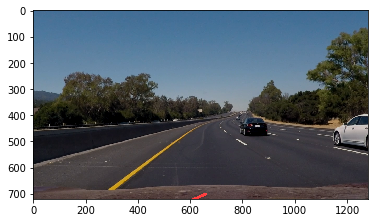

In [108]:
avg_pos_slope = 0
avg_neg_slope = 0
nFrames = 0
challenge_output = 'test_videos/modified_challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,2)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [197]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))